# Age - Sex - PA size and Mortality

This workbook walks through STATA code to replicate the CHEST article and attempt to add our analysis

In [2]:
import stata_setup
stata_setup.config(r"/Applications/Stata/", "be")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      Stata 18.0
___/   /   /___/   /   /___/       BE—Basic Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-782-8272        https://www.stata.com
                                   979-696-4600        service@stata.com

Stata license: 35-user network perpetual
Serial number: 301806305068
  Licensed to: Brian Locke
               University of Utah

Notes:
      1. Unicode is supported; see help unicode_advice.


Data Cleaning Code

In [3]:
%%stata
cd "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/Pulm Artery Stuff w Scarps/Local Analysis"

capture mkdir "Results and Figures"
capture mkdir "Results and Figures/$S_DATE/" //make new folder for figure output if needed
capture mkdir "Results and Figures/$S_DATE/Logs/" //new folder for stata logs
local a1=substr(c(current_time),1,2)
local a2=substr(c(current_time),4,2)
local a3=substr(c(current_time),7,2)
local b = "BL CombofilewithoutEMPI.do" // do file name
copy "`b'" "Results and Figures/$S_DATE/Logs/(`a1'_`a2'_`a3')`b'"

use final_noempi, clear

set scheme cleanplots //cleanplots white_tableau white_w3d //3 options I usually use

missings dropobs, force //drop all rows with no observations. None
missings dropvars, force //drop all columns with no observations
missings report
mdesc
codebook
count // n=990
count if lastfollowupday==0 // n=78 without any follow-up data

/* -----
Data Cleaning 
--------*/ 

label variable age "Age (years)"

label define male_lab 0 "Female" 1 "Male"
label variable male "Male Sex?"
label values male male_lab

bysort obesity: sum bmi, detail
label variable obesity "Obesity (ICD only)"

generate obesity_calc = . 
replace obesity_calc = 0 if !missing(obesity) & obesity == 0
replace obesity_calc = 1 if !missing(obesity) & obesity == 1
replace obesity_calc = 1 if !missing(bmi) & bmi >= 30
replace obesity_calc = 0 if !missing(bmi) & bmi < 30
label define obesity_calc_lab 0 "Not Obese" 1 "Obese"
label variable obesity_calc "Obesity"
label values obesity_calc obesity_calc_lab
tab obesity obesity_calc, missing
tab obesity_calc, missing
tab obesity, missing

//traditional cutpoints
label variable enlargedratio "PA:AA Ratio"
label define enlargedratio_lab 0 "Normal PA:AA (<0.9)" 1 "Increased PA:AA (0.9+)"
label values enlargedratio enlargedratio_lab

label variable enlargedpa "PA diameter"
label define enlargedpa_lab 0 "Normal PAd" 1 "Enlarged PAd"
label values enlargedpa enlargedpa_lab

gen pa_confusion_matrix = .
replace pa_confusion_matrix = 0 if (enlargedpa == 0) & (enlargedratio == 0)
replace pa_confusion_matrix = 1 if (enlargedpa == 1) & (enlargedratio == 0)
replace pa_confusion_matrix = 2 if (enlargedpa == 0) & (enlargedratio == 1)
replace pa_confusion_matrix = 3 if (enlargedpa == 1) & (enlargedratio == 1)
label variable pa_confusion_matrix "PAd high, PA:AA high, neither, or both?"
label define pa_confusion_lab 0 "Neither" 1 "Only Enlarged PAd" 2 "Only High PA:AA" 3 "Both"
label values pa_confusion_matrix pa_confusion_lab
tab enlargedpa pa_confusion_matrix, col //sanity checks
tab enlargedratio pa_confusion_matrix 


//label comorbdities
label variable pulmdisease "Pulmonary Disease"
label variable chf "Congestive Heart Failure"
label variable diabetes3 "Diabetes"
label define diabetes_val 0 "No DM" 1 "Uncomplicated DM" 2 "DM with Complication(s)"
label values diabetes3 diabetes_val 
label variable hypertension "Hypertension"
label variable pulmonarycircdisorder "Pulm Circ. Disorder"
label variable peripheralvascdisorders "Periph Vasc. Disease"
label variable renalfailure "Kidney Disease"

// [ ] remove? 
gen known_assoc_comorb = 0
replace known_assoc_comorb = 1 if (pulmdisease == 1 | pulmonarycircdisorders == 1 | chf == 1) 
tab chf known_assoc_comorb, missing //sanity checks
tab pulmdisease known_assoc_comorb, missing
tab pulmonarycircdisorders known_assoc_comorb, missing
label variable known_assoc_comorb "Known Comorbidity w PA->Mortality Association?"
label define known_assoc_comorb_lab 0 "No Pulm Dz/CHF/Pulm Vasc Dz" 1 "Any of Pulm Dz/CHF/Pulm Vasc Dz"
label values known_assoc_comorb known_assoc_comorb_lab

// Split diabetes into complicated vs not. 
tab diabetes3
capture drop diabetes1
gen diabetes1=cond(diabetes3==1,1,0)
tab diabetes3 diabetes1, missing
capture drop diabetes2
gen diabetes2=cond(diabetes3==2,1,0)
tab diabetes3 diabetes2, missing
label variable diabetes1 "Uncomplicated Diabetes"
label variable diabetes2 "Diabetes with Complication(s)"

// Outcomes
label variable death "Death"
label define death_label 0 "Alive or Censored" 1 "Died"
label values death death_label
label variable lastfollowupyear "Follow-up or death(years)"

label variable anyemergency "Any Emergency Visits in Follow-up?"
label variable anyadmission "Any Hospital Admission in Follow-up?"

gen time_of_death = lastfollowupyear if death == 1
label variable time_of_death "Time of Death"
gen time_of_censoring = lastfollowupyear if death != 1
label variable time_of_censoring "Time of longest follow-up alive"


//Categorizations of continuous variables; for graphs
 
recode age min/30=0 30/40=1 40/50=2 50/60=3 60/70=4 70/max=5, gen(age_decade)
label define age_dec_lab 0 "<30 years" 1 "30-40 years" 2 "40-50 years" 3 "50-60 years" 4 "60-70 years" 5 "70+ years"
label variable age_decade "Age (by decade)"
label values age_decade age_dec_lab 

gen sex_norm_mpad = .
replace sex_norm_mpad = mpad + 1 if male == 0
replace sex_norm_mpad = mpad - 1 if male == 1
sum sex_norm_mpad, detail
recode sex_norm_mpad min/25=0 25/28=1 28/31=2 31/max=3, gen(mpad_cat) 
label define mpad_cat_lab 0 "F:<24 mm, M:<26 mm" 1 "F:24-27 mm, M:26-29 mm" 2 "F:27-30 mm, M:29-32 mm" 3 "F:30+ mm, M32+ mm"
//TODO: Cutpoints for mPA were defined with ≤27 mm(F) and ≤29 mm(M) as the normal reference range; mild as >27 to <31 mm(F) and >29 to <31 mm(M); moderate≥31–34 mm; and severe>34 mm.  from -  Truong QA, Bhatia HS, Szymonifka J, et al. A four-tier classification system of pulmonary artery metrics on computed tomography for the diagnosis and prognosis of pulmonary hypertension. J Cardiovasc Comput Tomogr 2018;12(1):60–66.
label variable mpad_cat "PA_d strata"
label values mpad_cat mpad_cat_lab 
bysort mpad_cat: sum sex_norm_mpad, detail
bysort mpad_cat: sum mpad if male == 0, detail  //sanity check
bysort mpad_cat: sum mpad if male == 1, detail  //sanity check

gen sex_norm_aa = .
replace sex_norm_aa = ascendingaorta + 1.5 if male == 0 //men 3mm larger; more dispersion (not accounted for)
replace sex_norm_aa = ascendingaorta - 1.5 if male == 1
sum sex_norm_aa, detail
recode sex_norm_aa min/30=0 30/33.5=1 33.5/37=2 37/max=3, gen(aa_cat)
label define aa_cat_lab 0 "F:<28.5 mm, M:<31.5 mm" 1 "F:28.5-32 mm, M:31.5-35 mm" 2 "F:32-35.5 mm, M:35-38.5mm" 3 "F:35.5+mm, M:38.5+mm" //35 and 32 as thresholds (similar percentil as for MPAd) 33.5 as threshold for abn, roughly
label variable aa_cat "AA_d strata"
label values aa_cat aa_cat_lab 
bysort aa_cat: sum sex_norm_aa, detail
bysort aa_cat: sum ascendingaorta if male == 0, detail
bysort aa_cat: sum ascendingaorta if male == 1, detail 

save cleaned_noempi, replace



. cd "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Rese
> arch Projects/Pulm Artery Stuff w Scarps/Local Analysis"
/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research P
> rojects/Pulm Artery Stuff w Scarps/Local Analysis

. 
. capture mkdir "Results and Figures"

. capture mkdir "Results and Figures/$S_DATE/" //make new folder for figure out
> put if needed

. capture mkdir "Results and Figures/$S_DATE/Logs/" //new folder for stata logs

. local a1=substr(c(current_time),1,2)

. local a2=substr(c(current_time),4,2)

. local a3=substr(c(current_time),7,2)

. local b = "BL CombofilewithoutEMPI.do" // do file name

. copy "`b'" "Results and Figures/$S_DATE/Logs/(`a1'_`a2'_`a3')`b'"

. 
. use final_noempi, clear

. 
. set scheme cleanplots //cleanplots white_tableau white_w3d //3 options I usua
> lly use

. 
. missings dropobs, force //drop all rows with no observations. None

Checking missings in tagempi masterdate ctdate followupday firs

Data Analysis

In [6]:
%%stata
clear
use cleaned_noempi

/* Analysis */ 

/* 
Table 1
*/ 

table1_mc, by (age_decade) ///
vars( ///
male bin %4.1f \ /// 
obesity_calc bin %4.1f \ /// 
pulmdisease bin %4.1f \ /// 
chf bin %4.1f \ /// 
diabetes3 cat %4.1f \ /// 
hypertension bin %4.1f \ ///
pulmonarycircdisorders bin %4.1f \ /// 
peripheralvascdisorders bin %4.1f \ /// 
renalfailure bin %4.1f \ /// 
mpad conts %4.1f \ ///
enlargedpa cat %4.1f \ ///
ascendingaorta conts %4.1f \ ///
mpaaa conts %4.2f \ ///
enlargedratio cat %4.1f \ /// 
anyemergency bin %4.1f \ /// 
anyadmission bin %4.1f \ /// 
death bin %4.1f \ /// 
time_of_death conts %4.1f \ /// 
time_of_death conts %4.1f \ /// 
) ///
percent_n percsign("%") iqrmiddle(",") sdleft(" (±") sdright(")") onecol total(before) ///
saving("Results and Figures/$S_DATE/Table 1 PA enlargement by Age.xlsx", replace)



. clear

. use cleaned_noempi

. 
. /* Analysis */ 
. 
. /* 
> Table 1
> */ 
. 
. table1_mc, by (age_decade) ///
> vars( ///
> male bin %4.1f \ /// 
> obesity_calc bin %4.1f \ /// 
> pulmdisease bin %4.1f \ /// 
> chf bin %4.1f \ /// 
> diabetes3 cat %4.1f \ /// 
> hypertension bin %4.1f \ ///
> pulmonarycircdisorders bin %4.1f \ /// 
> peripheralvascdisorders bin %4.1f \ /// 
> renalfailure bin %4.1f \ /// 
> mpad conts %4.1f \ ///
> enlargedpa cat %4.1f \ ///
> ascendingaorta conts %4.1f \ ///
> mpaaa conts %4.2f \ ///
> enlargedratio cat %4.1f \ /// 
> anyemergency bin %4.1f \ /// 
> anyadmission bin %4.1f \ /// 
> death bin %4.1f \ /// 
> time_of_death conts %4.1f \ /// 
> time_of_death conts %4.1f \ /// 
> ) ///
> percent_n percsign("%") iqrmiddle(",") sdleft(" (±") sdright(")") onecol tota
> l(before) ///
> saving("Results and Figures/$S_DATE/Table 1 PA enlargement by Age.xlsx", repl
> ace)

  +----------------------------------------------------------------------------
> ------

Table 1 Details - all the pertinent info is easier to see in images below


. colorpalette Spectral, n(6) nograph  // [ ] TODO: use same CET C6 pallette so
> mehow?

. local color6 `"`r(p1)'"' // Reverse order

. local color5 `"`r(p2)'"'

. local color4 `"`r(p3)'"'

. local color3 `"`r(p4)'"'

. local color2 `"`r(p5)'"'

. local color1 `"`r(p6)'"'

. 
. twoway ///
>     (scatter ascendingaorta mpad if age_decade == 0 & male == 0, mcolor("`col
> or1'") msymbol(O)) || /// <30 years, Female
>     (scatter ascendingaorta mpad if age_decade == 0 & male == 1, mcolor("`col
> or1'") msymbol(S)) || /// <30 years, Male
>     (scatter ascendingaorta mpad if age_decade == 1 & male == 0, mcolor("`col
> or2'") msymbol(O)) || /// 30-40 years, Female
>     (scatter ascendingaorta mpad if age_decade == 1 & male == 1, mcolor("`col
> or2'") msymbol(S)) || /// 30-40 years, Male
>     (scatter ascendingaorta mpad if age_decade == 2 & male == 0, mcolor("`col
> or3'") msymbol(O)) || /// 40-50 years, Female
>     (scatter ascendingaorta mpad if age_decade == 2 & male == 1, mcolor("`

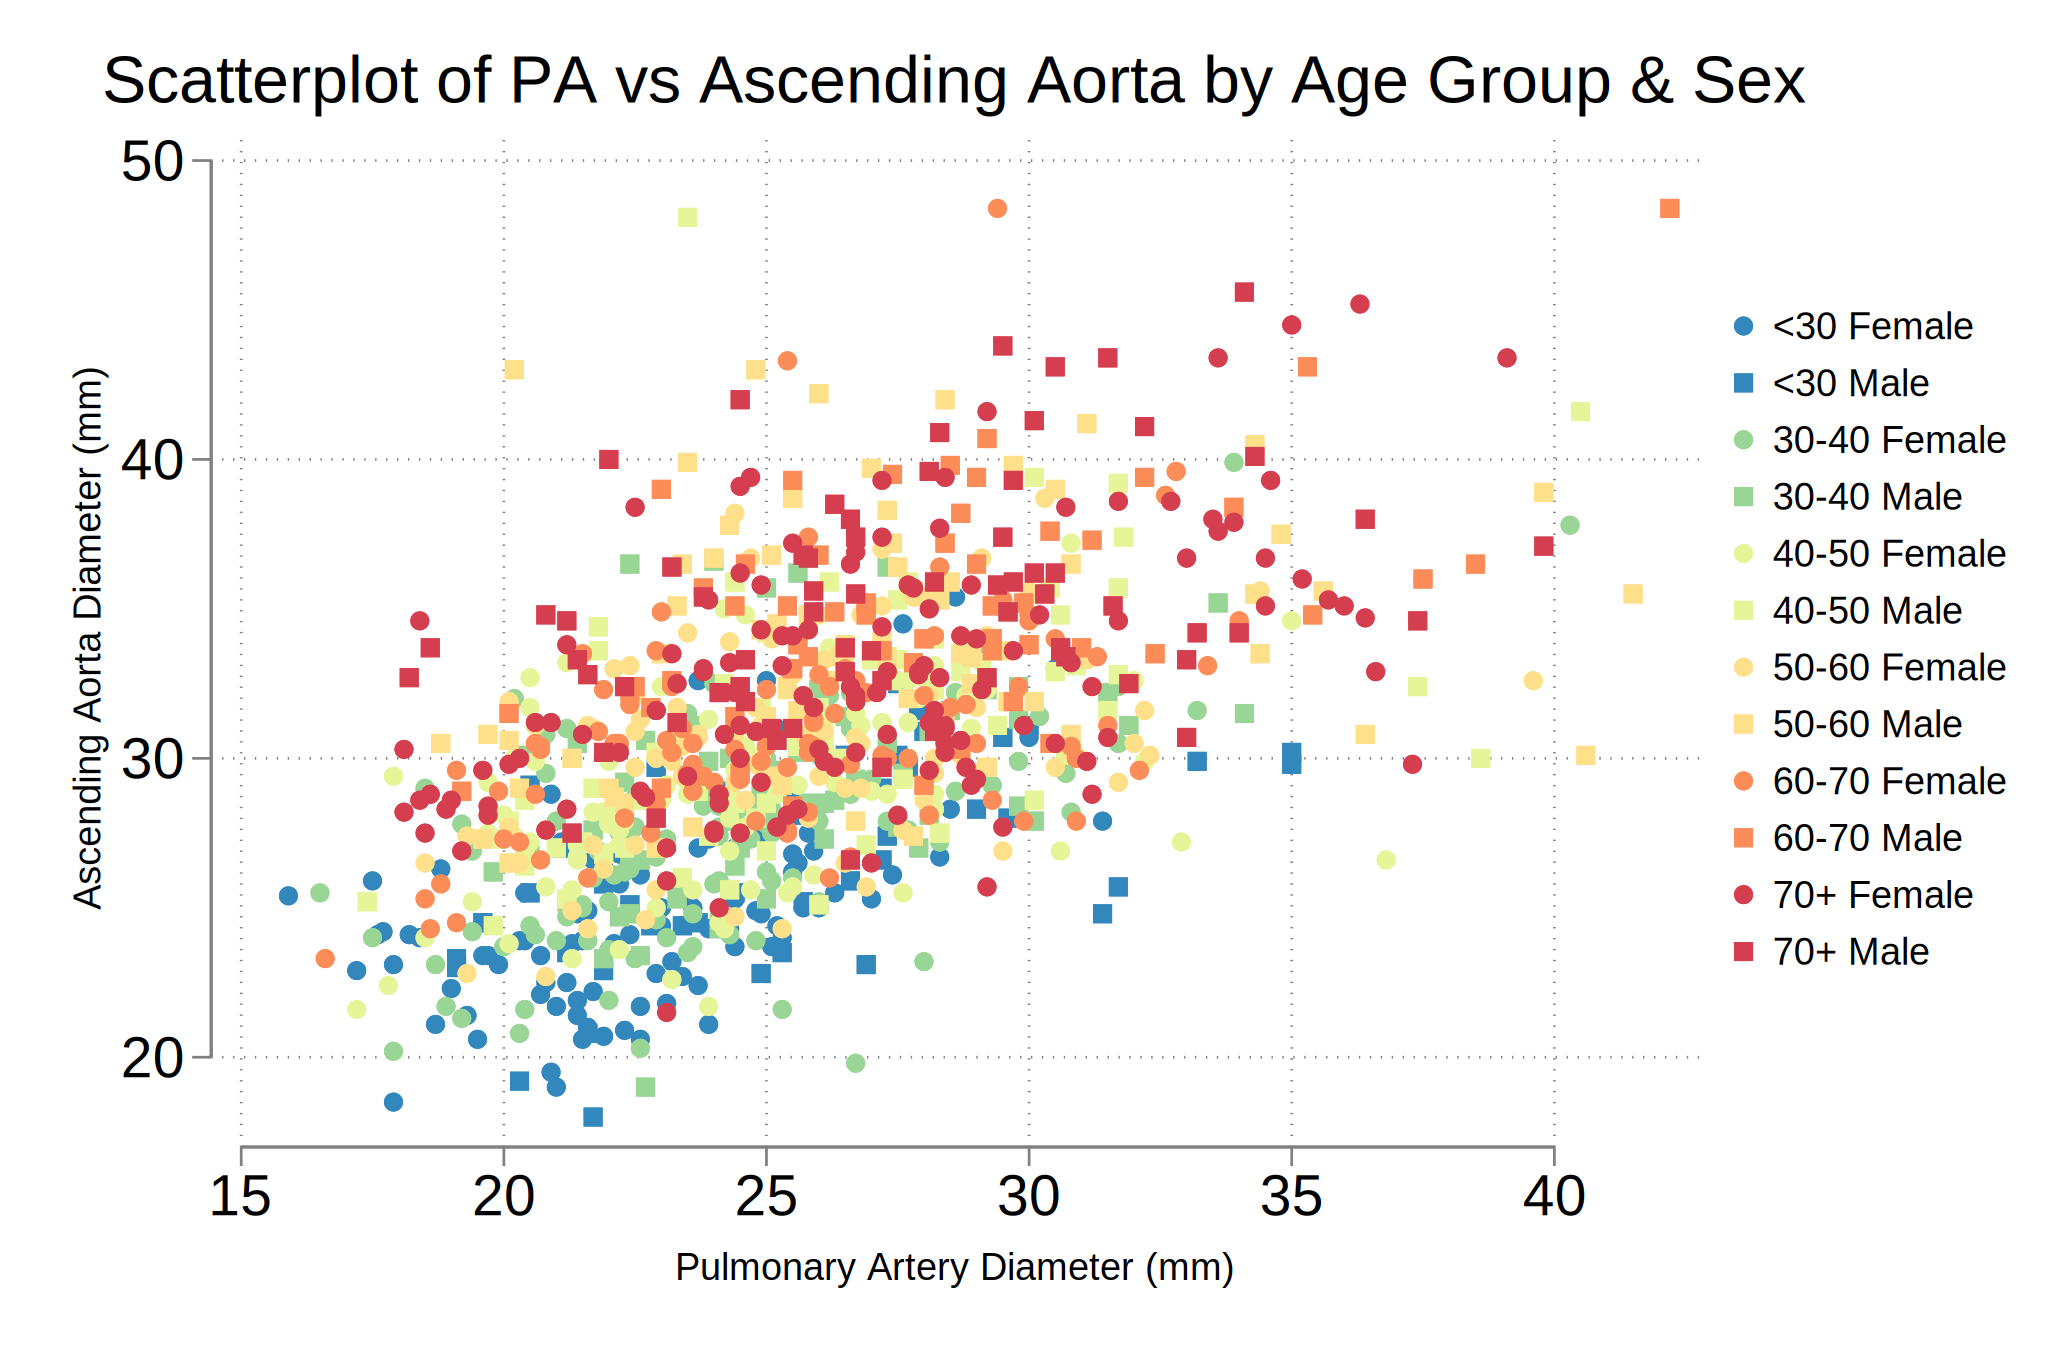

In [ ]:
%%stata
colorpalette Spectral, n(6) nograph  // [ ] TODO: use same CET C6 pallette somehow?
local color6 `"`r(p1)'"' // Reverse order
local color5 `"`r(p2)'"'
local color4 `"`r(p3)'"'
local color3 `"`r(p4)'"'
local color2 `"`r(p5)'"'
local color1 `"`r(p6)'"'

twoway ///
    (scatter ascendingaorta mpad if age_decade == 0 & male == 0, mcolor("`color1'") msymbol(O)) || /// <30 years, Female
    (scatter ascendingaorta mpad if age_decade == 0 & male == 1, mcolor("`color1'") msymbol(S)) || /// <30 years, Male
    (scatter ascendingaorta mpad if age_decade == 1 & male == 0, mcolor("`color2'") msymbol(O)) || /// 30-40 years, Female
    (scatter ascendingaorta mpad if age_decade == 1 & male == 1, mcolor("`color2'") msymbol(S)) || /// 30-40 years, Male
    (scatter ascendingaorta mpad if age_decade == 2 & male == 0, mcolor("`color3'") msymbol(O)) || /// 40-50 years, Female
    (scatter ascendingaorta mpad if age_decade == 2 & male == 1, mcolor("`color3'") msymbol(S)) || /// 40-50 years, Male
    (scatter ascendingaorta mpad if age_decade == 3 & male == 0, mcolor("`color4'") msymbol(O)) || /// 50-60 years, Female
    (scatter ascendingaorta mpad if age_decade == 3 & male == 1, mcolor("`color4'") msymbol(S)) || /// 50-60 years, Male
    (scatter ascendingaorta mpad if age_decade == 4 & male == 0, mcolor("`color5'") msymbol(O)) || /// 60-70 years, Female
    (scatter ascendingaorta mpad if age_decade == 4 & male == 1, mcolor("`color5'") msymbol(S)) || /// 60-70 years, Male
    (scatter ascendingaorta mpad if age_decade == 5 & male == 0, mcolor("`color6'") msymbol(O)) || /// 70+ years, Female
    (scatter ascendingaorta mpad if age_decade == 5 & male == 1, mcolor("`color6'") msymbol(S)), /// 70+ years, Male
    ///
    legend(order(1 "<30 Female" 2 "<30 Male" 3 "30-40 Female" 4 "30-40 Male" ///
                 5 "40-50 Female" 6 "40-50 Male" 7 "50-60 Female" 8 "50-60 Male" ///
                 9 "60-70 Female" 10 "60-70 Male" 11 "70+ Female" 12 "70+ Male")) ///
    xtitle("Pulmonary Artery Diameter (mm)") ytitle("Ascending Aorta Diameter (mm)") ///
    title("Scatterplot of PA vs Ascending Aorta by Age Group & Sex") ///
    xlabel(, labsize(medlarge)) ylabel(, labsize(medlarge)) ///
    scheme(white_w3d)


this one shows how sex, age, PA and AA size relate. (no correlation to outcomes yet). Clearly an upward trend as people get older, and somewhat shifted distributions by sex

## Assessing the relationship between Age, Sex and PA size


. /* PAd */ 
. ridgeline mpad, by(age_decade) yline ylw(0.2) overlap(1.7) ylc(blue) ylp(dot)
>  ////
>         labpos(right) bwid(1.2) laboffset(-3) showstats xlabel(15(5)40) ///
>         palette(CET C6) alpha(75) xtitle("Pulmonary Artery Diameter (mm)")

. 


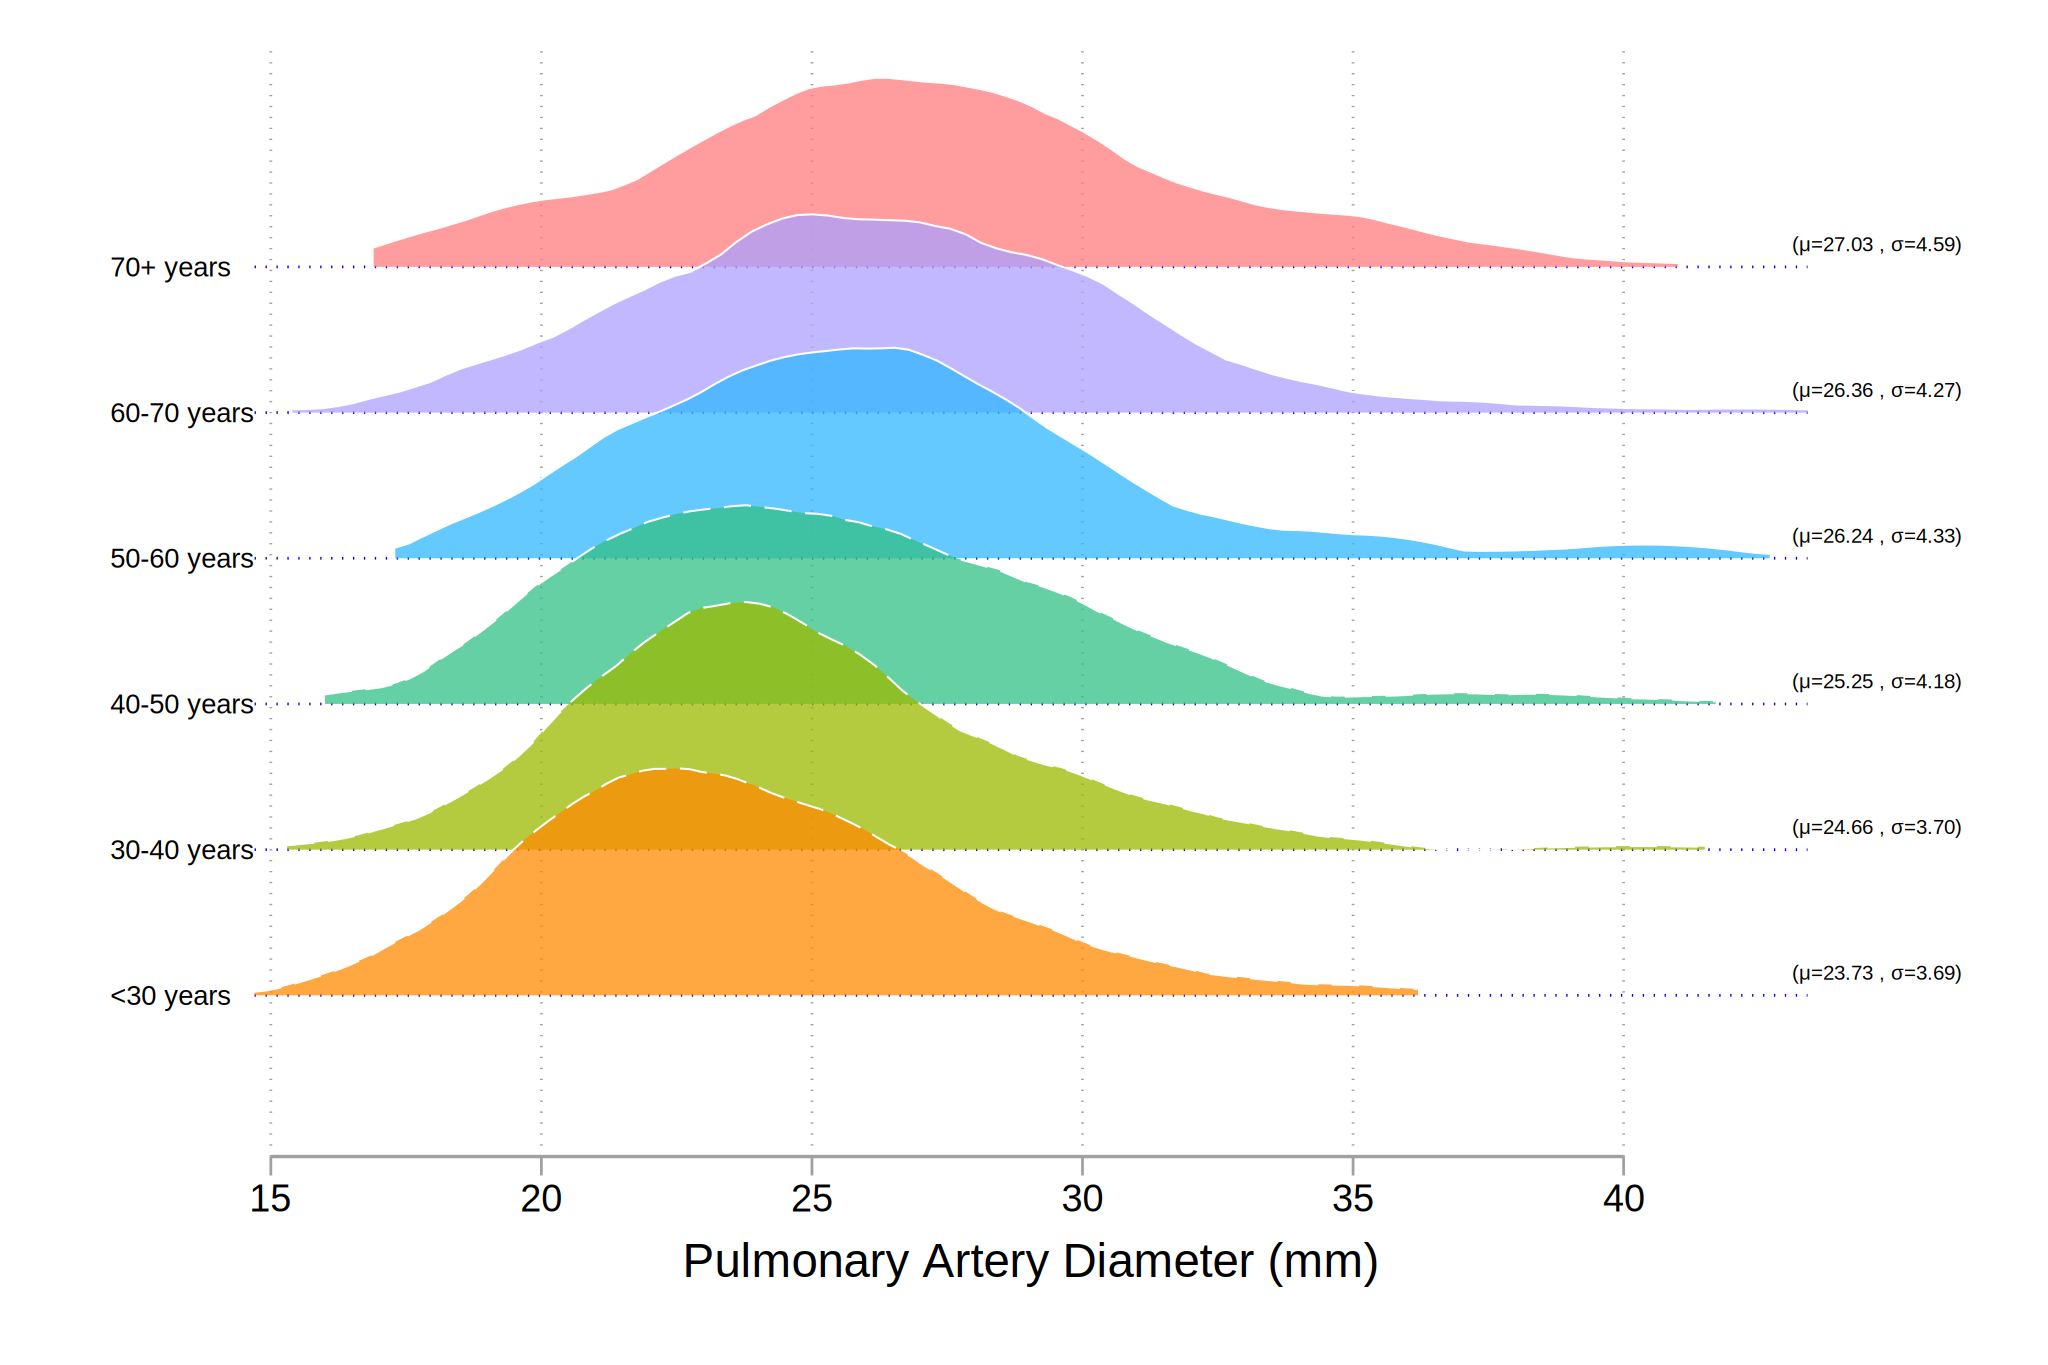

In [9]:
%%stata
/* PAd */ 
ridgeline mpad, by(age_decade) yline ylw(0.2) overlap(1.7) ylc(blue) ylp(dot) ////
	labpos(right) bwid(1.2) laboffset(-3) showstats xlabel(15(5)40) ///
	palette(CET C6) alpha(75) xtitle("Pulmonary Artery Diameter (mm)")



. * Ridgeline plot for Females (male == 0)
. ridgeline mpad if male == 0, by(age_decade) yline ylw(0.2) overlap(1.7) ///
>     ylc(blue) ylp(dot) labpos(right) bwid(1.2) laboffset(-3) ///
>     showstats xlabel(15(5)40) palette(CET C6) alpha(75) ///
>     xtitle("Pulmonary Artery Diameter (mm)") ///
>     title("PA Diameter by Age Group - Female") ///
>     saving(ridgeline_female, replace)

. 
. * Ridgeline plot for Males (male == 1)
. ridgeline mpad if male == 1, by(age_decade) yline ylw(0.2) overlap(1.7) ///
>     ylc(red) ylp(dot) labpos(right) bwid(1.2) laboffset(-3) ///
>     showstats xlabel(15(5)40) palette(CET C6) alpha(75) ///
>     xtitle("Pulmonary Artery Diameter (mm)") ///
>     title("PA Diameter by Age Group - Male") ///
>     saving(ridgeline_male, replace)

. 
. graph combine ridgeline_female.gph ridgeline_male.gph, ///
>     title("Ridgeline Plot of PA Diameter by Age Group & Sex")
(note:  named style i not found in class symbol, default attributes used)
(note:  nam

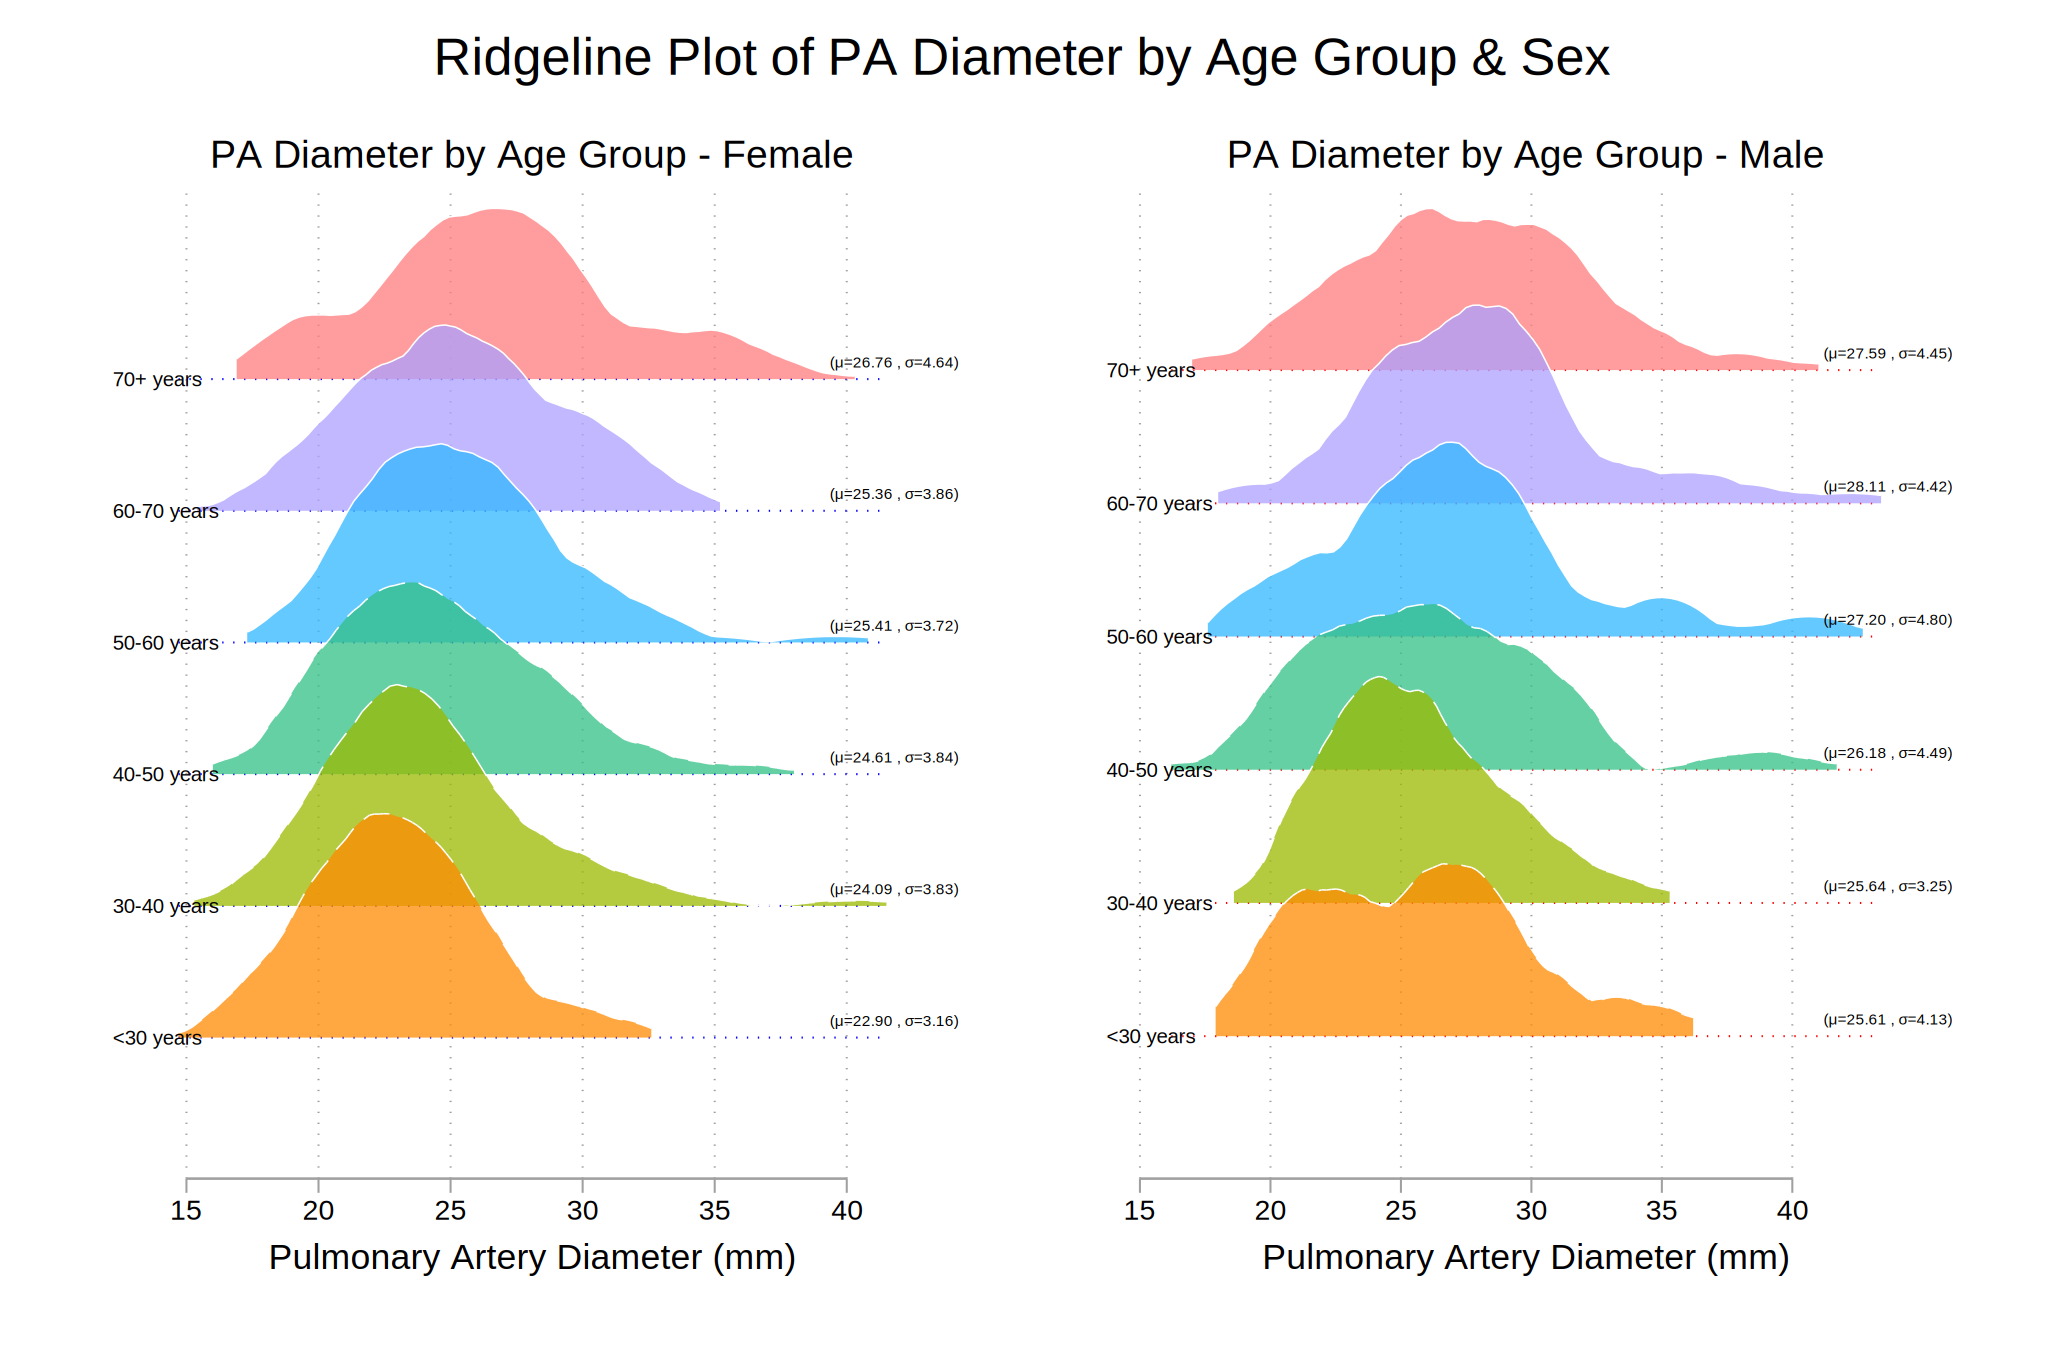

In [10]:
%%stata
* Ridgeline plot for Females (male == 0)
ridgeline mpad if male == 0, by(age_decade) yline ylw(0.2) overlap(1.7) ///
    ylc(blue) ylp(dot) labpos(right) bwid(1.2) laboffset(-3) ///
    showstats xlabel(15(5)40) palette(CET C6) alpha(75) ///
    xtitle("Pulmonary Artery Diameter (mm)") ///
    title("PA Diameter by Age Group - Female") ///
    saving(ridgeline_female, replace)

* Ridgeline plot for Males (male == 1)
ridgeline mpad if male == 1, by(age_decade) yline ylw(0.2) overlap(1.7) ///
    ylc(red) ylp(dot) labpos(right) bwid(1.2) laboffset(-3) ///
    showstats xlabel(15(5)40) palette(CET C6) alpha(75) ///
    xtitle("Pulmonary Artery Diameter (mm)") ///
    title("PA Diameter by Age Group - Male") ///
    saving(ridgeline_male, replace)

graph combine ridgeline_female.gph ridgeline_male.gph, ///
    title("Ridgeline Plot of PA Diameter by Age Group & Sex")

larger PAs as you get older; true of both sexes. 

In [ ]:
%%stata 
/* Run Bootstrap Quantile Regressions for the Full Population */
bsqreg mpad c.age, quantile(50) reps(500) // 50th Percentile


. /* Run Bootstrap Quantile Regressions for the Full Population */
. bsqreg mpad c.age, quantile(50) reps(500) // 50th Percentile
(fitting base model)

Bootstrap replications (500): .........10.........20.........30.........40.....
> ....50.........60.........70.........80.........90.........100.........110...
> ......120.........130.........140.........150.........160.........170........
> .180.........190.........200.........210.........220.........230.........240.
> ........250.........260.........270.........280.........290.........300......
> ...310.........320.........330.........340.........350.........360.........37
> 0.........380.........390.........400.........410.........420.........430....
> .....440.........450.........460.........470.........480.........490.........
> 500 done

Median regression, bootstrap(500) SEs               Number of obs =        990
  Raw sum of deviations  1665.45 (about 25.200001)
  Min sum of deviations 1591.973                    Pseudo R2    

In [14]:
%%stata

bsqreg mpad c.age, quantile(90) reps(500) // 90th Percentile


. 
. bsqreg mpad c.age, quantile(90) reps(500) // 90th Percentile
(fitting base model)

Bootstrap replications (500): .........10.........20.........30.........40.....
> ....50.........60.........70.........80.........90.........100.........110...
> ......120.........130.........140.........150.........160.........170........
> .180.........190.........200.........210.........220.........230.........240.
> ........250.........260.........270.........280.........290.........300......
> ...310.........320.........330.........340.........350.........360.........37
> 0.........380.........390.........400.........410.........420.........430....
> .....440.........450.........460.........470.........480.........490.........
> 500 done

.9 Quantile regression, bootstrap(500) SEs          Number of obs =        990
  Raw sum of deviations   842.75 (about 30.9)
  Min sum of deviations 805.1974                    Pseudo R2     =     0.0446

------------------------------------------------------

In [15]:
%%stata 

bsqreg mpad c.age, quantile(95) reps(500) // 95th Percentile


. 
. bsqreg mpad c.age, quantile(95) reps(500) // 95th Percentile
(fitting base model)

Bootstrap replications (500): .........10.........20.........30.........40.....
> ....50.........60.........70.........80.........90.........100.........110...
> ......120.........130.........140.........150.........160.........170........
> .180.........190.........200.........210.........220.........230.........240.
> ........250.........260.........270.........280.........290.........300......
> ...310.........320.........330.........340.........350.........360.........37
> 0.........380.........390.........400.........410.........420.........430....
> .....440.........450.........460.........470.........480.........490.........
> 500 done

.95 Quantile regression, bootstrap(500) SEs         Number of obs =        990
  Raw sum of deviations  526.025 (about 33.599998)
  Min sum of deviations 497.4948                    Pseudo R2     =     0.0542

-------------------------------------------------

The preceding three quantile regressions ask how the 50th, 90th, and 95th percentile are expected to change as one gets older. 

The 95th percentile is expected to get 0.096 mm bigger each year. The fact that this is more than the median suggests that the distribution widens with age. 


. 
. /* Extract Colors from Spectral Palette */
. colorpalette Spectral, n(6) nograph  

. local color6 `"`r(p1)'"' // Reverse order

. local color5 `"`r(p2)'"'

. local color4 `"`r(p3)'"'

. local color3 `"`r(p4)'"'

. local color2 `"`r(p5)'"'

. local color1 `"`r(p6)'"'

. 
. /* Run Quantile Regressions for the Full Population */
. qreg mpad c.age, quantile(50) // 50th Percentile

Iteration 1:  WLS sum of weighted deviations =  1598.5126

Iteration 1:  Sum of abs. weighted deviations =  1598.1065
Iteration 2:  Sum of abs. weighted deviations =  1592.1619
Iteration 3:  Sum of abs. weighted deviations =  1592.0304
Iteration 4:  Sum of abs. weighted deviations =  1591.9727

Median regression                                   Number of obs =        990
  Raw sum of deviations  1665.45 (about 25.200001)
  Min sum of deviations 1591.973                    Pseudo R2     =     0.0441

------------------------------------------------------------------------------
        mpad | Coefficient  

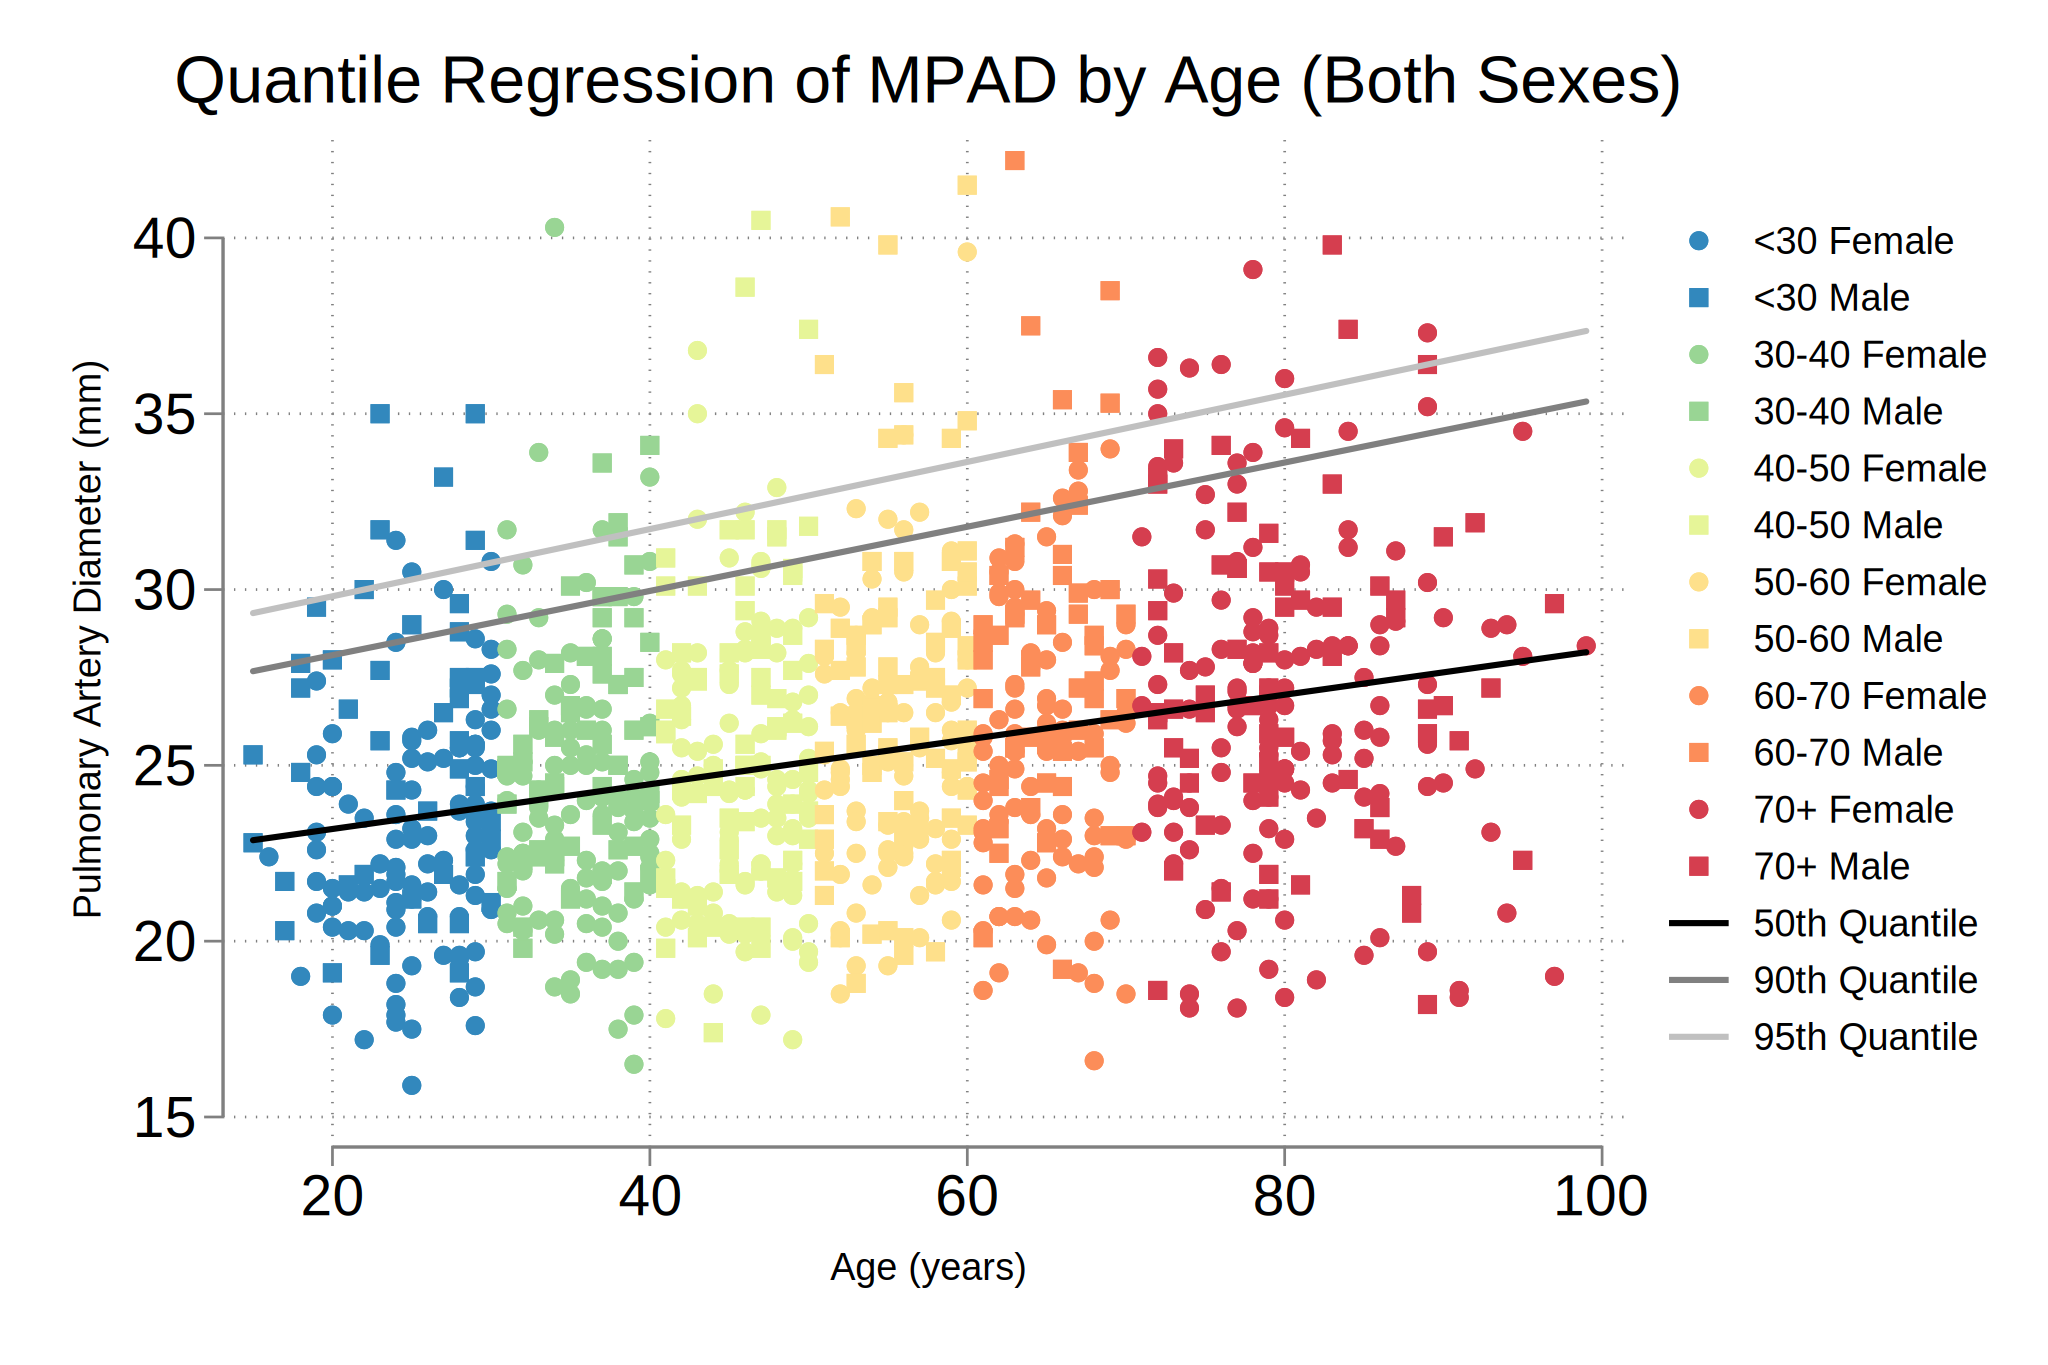

In [16]:
%%stata 

/* Extract Colors from Spectral Palette */
colorpalette Spectral, n(6) nograph  
local color6 `"`r(p1)'"' // Reverse order
local color5 `"`r(p2)'"'
local color4 `"`r(p3)'"'
local color3 `"`r(p4)'"'
local color2 `"`r(p5)'"'
local color1 `"`r(p6)'"'

/* Run Quantile Regressions for the Full Population */
qreg mpad c.age, quantile(50) // 50th Percentile
predict mpad_q50_all, xb

qreg mpad c.age, quantile(90) // 90th Percentile
predict mpad_q90_all, xb

qreg mpad c.age, quantile(95) // 95th Percentile
predict mpad_q95_all, xb

/* Scatter Plot with Both Genders + Quantile Regression Lines */
twoway ///
    (scatter mpad age if age_decade == 0 & male == 0, mcolor("`color1'") msymbol(O)) || /// <30 years, Female
    (scatter mpad age if age_decade == 0 & male == 1, mcolor("`color1'") msymbol(S)) || /// <30 years, Male
    (scatter mpad age if age_decade == 1 & male == 0, mcolor("`color2'") msymbol(O)) || /// 30-40 years, Female
    (scatter mpad age if age_decade == 1 & male == 1, mcolor("`color2'") msymbol(S)) || /// 30-40 years, Male
    (scatter mpad age if age_decade == 2 & male == 0, mcolor("`color3'") msymbol(O)) || /// 40-50 years, Female
    (scatter mpad age if age_decade == 2 & male == 1, mcolor("`color3'") msymbol(S)) || /// 40-50 years, Male
    (scatter mpad age if age_decade == 3 & male == 0, mcolor("`color4'") msymbol(O)) || /// 50-60 years, Female
    (scatter mpad age if age_decade == 3 & male == 1, mcolor("`color4'") msymbol(S)) || /// 50-60 years, Male
    (scatter mpad age if age_decade == 4 & male == 0, mcolor("`color5'") msymbol(O)) || /// 60-70 years, Female
    (scatter mpad age if age_decade == 4 & male == 1, mcolor("`color5'") msymbol(S)) || /// 60-70 years, Male
    (scatter mpad age if age_decade == 5 & male == 0, mcolor("`color6'") msymbol(O)) || /// 70+ years, Female
    (scatter mpad age if age_decade == 5 & male == 1, mcolor("`color6'") msymbol(S)) || /// 70+ years, Male
    (line mpad_q50_all age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 50th quantile
    (line mpad_q90_all age, lcolor(gs8) lpattern(solid) lwidth(medthick)) || /// 90th quantile
    (line mpad_q95_all age, lcolor(gs12) lpattern(solid) lwidth(medthick)), /// 95th quantile
    legend(order(1 "<30 Female" 2 "<30 Male" 3 "30-40 Female" 4 "30-40 Male" ///
                 5 "40-50 Female" 6 "40-50 Male" 7 "50-60 Female" 8 "50-60 Male" ///
                 9 "60-70 Female" 10 "60-70 Male" 11 "70+ Female" 12 "70+ Male" ///
                 13 "50th Quantile" 14 "90th Quantile" 15 "95th Quantile")) ///
    xtitle("Age (years)") ytitle("Pulmonary Artery Diameter (mm)") ///
    title("Quantile Regression of MPAD by Age (Both Sexes)") ///
    xlabel(, labsize(medlarge)) ylabel(, labsize(medlarge)) ///
    scheme(white_w3d)

confirmed visually. 

In [ ]:
%%stata

//this code gives confidence intervals - all signficant

/* Run Bootstrap Quantile Regressions for the Men */
bsqreg mpad c.age if male == 1, quantile(50) reps(500) // 50th Percentile
bsqreg mpad c.age if male == 1, quantile(90) reps(500) // 90th Percentile
bsqreg mpad c.age if male == 1, quantile(95) reps(500) // 95th Percentile

/* Run Bootstrap Quantile Regressions for the Women */
bsqreg mpad c.age if male == 0, quantile(50) reps(500) // 50th Percentile
bsqreg mpad c.age if male == 0, quantile(90) reps(500) // 90th Percentile
bsqreg mpad c.age if male == 0, quantile(95) reps(500) // 95th Percentile


. 
. /* Run Bootstrap Quantile Regressions for the Men */
. bsqreg mpad c.age if male == 1, quantile(50) reps(500) // 50th Percentile
(fitting base model)

Bootstrap replications (500): .........10.........20.........30.........40.....
> ....50.........60.........70.........80.........90.........100.........110...
> ......120.........130.........140.........150.........160.........170........
> .180.........190.........200.........210.........220.........230.........240.
> ........250.........260.........270.........280.........290.........300......
> ...310.........320.........330.........340.........350.........360.........37
> 0.........380.........390.........400.........410.........420.........430....
> .....440.........450.........460.........470.........480.........490.........
> 500 done

Median regression, bootstrap(500) SEs               Number of obs =        370
  Raw sum of deviations      629 (about 26.4)
  Min sum of deviations   615.95                    Pseudo R2     


. 
. /* -----
> Sex-Stratified Quantile Regression Scatter Plots
> -----*/ 
. 
. /* Extract Colors from Spectral Palette */
. colorpalette Spectral, n(6) nograph  

. local color6 `"`r(p1)'"' // Reverse order

. local color5 `"`r(p2)'"'

. local color4 `"`r(p3)'"'

. local color3 `"`r(p4)'"'

. local color2 `"`r(p5)'"'

. local color1 `"`r(p6)'"'

. 
. /* -----
> Generate Quantile Regression Predictions for Males
> -----*/ 
. qreg mpad c.age if male == 1, quantile(50) // Male

Iteration 1:  WLS sum of weighted deviations =  616.82051

Iteration 1:  Sum of abs. weighted deviations =  616.81601
Iteration 2:  Sum of abs. weighted deviations =  616.59395
Iteration 3:  Sum of abs. weighted deviations =  615.95001

Median regression                                   Number of obs =        370
  Raw sum of deviations      629 (about 26.4)
  Min sum of deviations   615.95                    Pseudo R2     =     0.0207

---------------------------------------------------------------------------

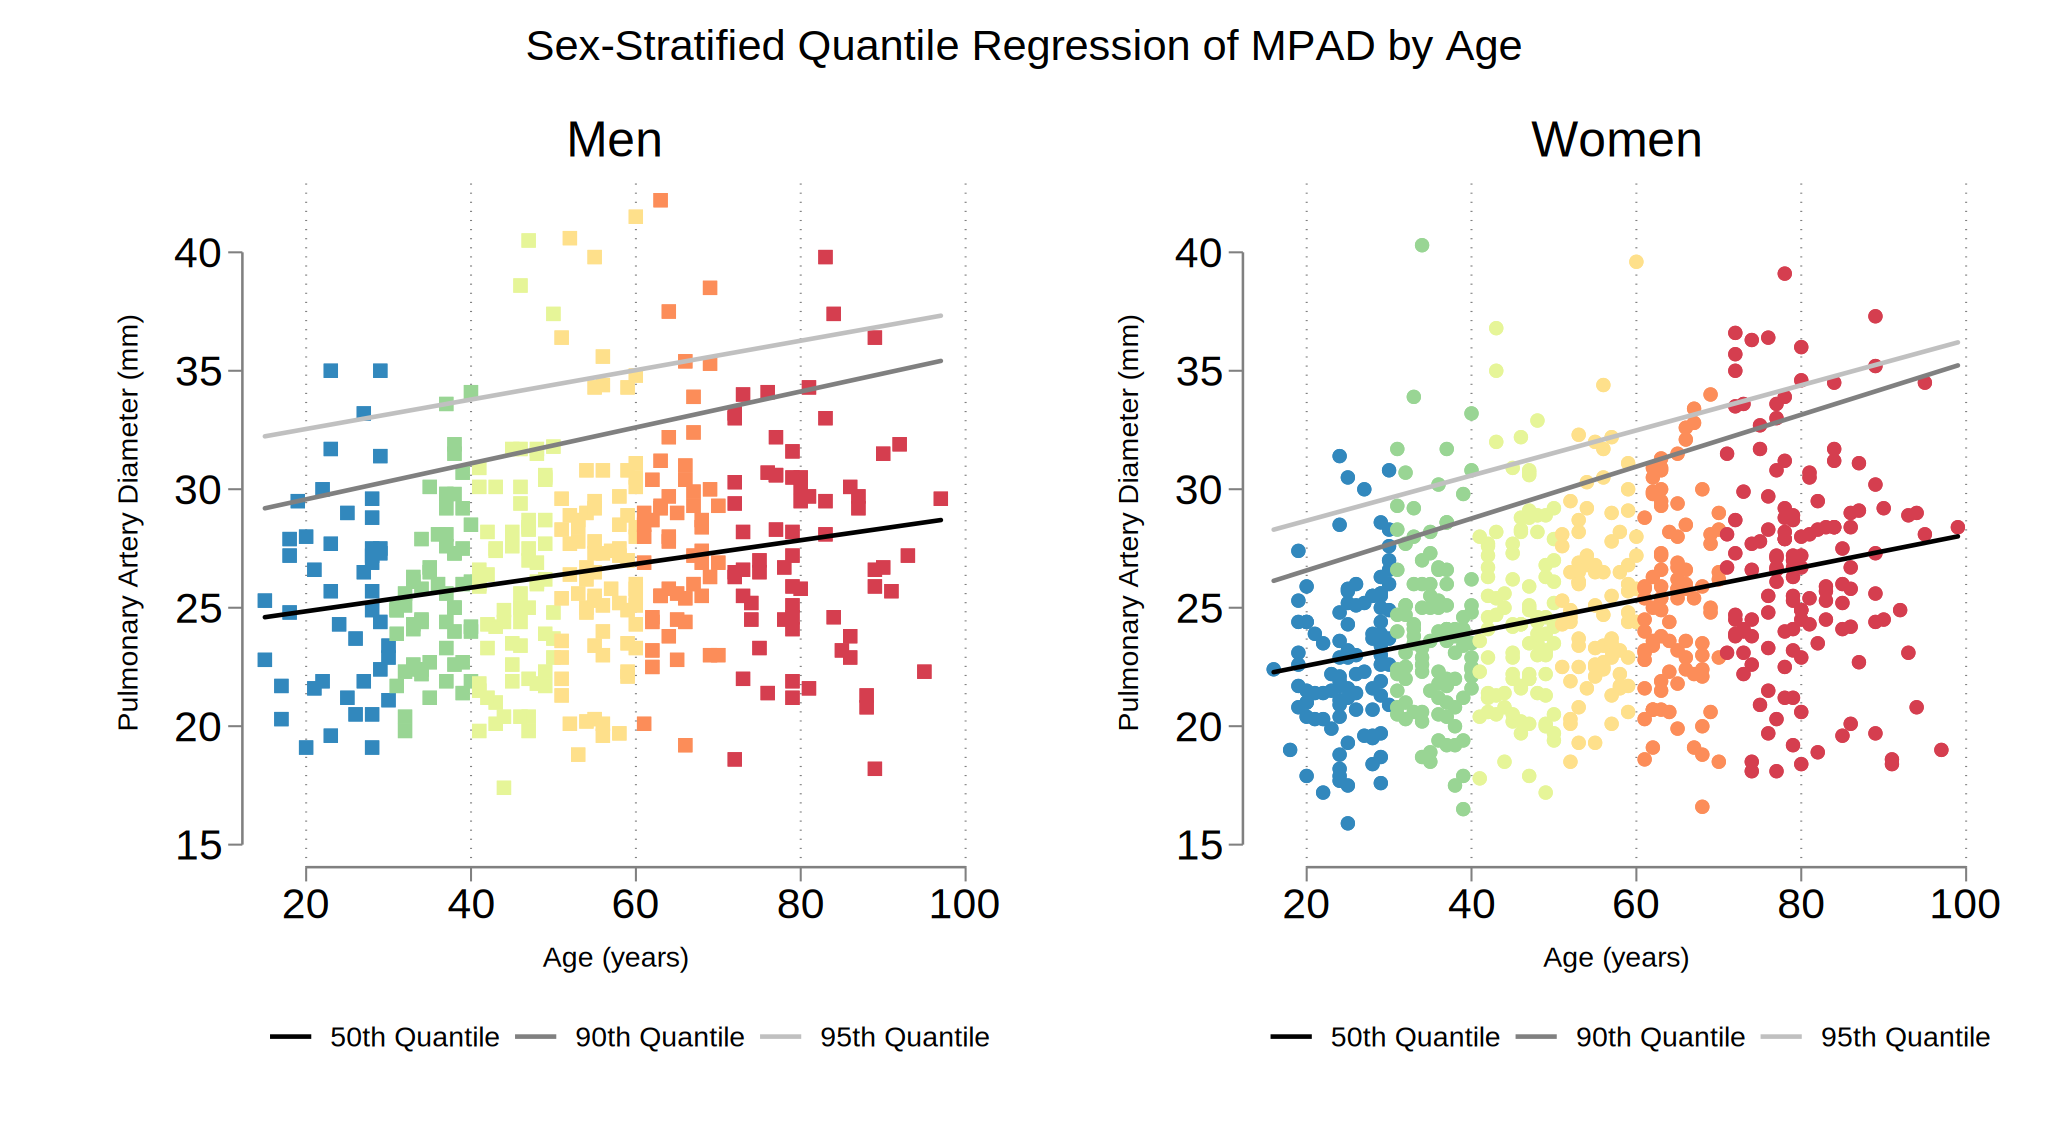

In [ ]:
%%stata 

/* -----
Sex-Stratified Quantile Regression Scatter Plots
-----*/ 

/* Extract Colors from Spectral Palette */
colorpalette Spectral, n(6) nograph  
local color6 `"`r(p1)'"' // Reverse order
local color5 `"`r(p2)'"'
local color4 `"`r(p3)'"'
local color3 `"`r(p4)'"'
local color2 `"`r(p5)'"'
local color1 `"`r(p6)'"'

/* -----
Generate Quantile Regression Predictions for Males
-----*/ 
qreg mpad c.age if male == 1, quantile(50) // Male
predict mpad_q50_male if male == 1, xb
qreg mpad c.age if male == 1, quantile(90) // Male
predict mpad_q90_male if male == 1, xb
qreg mpad c.age if male == 1, quantile(95) // Male
predict mpad_q95_male if male == 1, xb

/* -----
Male Scatter Plot
-----*/ 
twoway ///
    (scatter mpad age if age_decade == 0 & male == 1, mcolor("`color1'") msymbol(S)) || /// <30 years
    (scatter mpad age if age_decade == 1 & male == 1, mcolor("`color2'") msymbol(S)) || /// 30-40 years
    (scatter mpad age if age_decade == 2 & male == 1, mcolor("`color3'") msymbol(S)) || /// 40-50 years
    (scatter mpad age if age_decade == 3 & male == 1, mcolor("`color4'") msymbol(S)) || /// 50-60 years
    (scatter mpad age if age_decade == 4 & male == 1, mcolor("`color5'") msymbol(S)) || /// 60-70 years
    (scatter mpad age if age_decade == 5 & male == 1, mcolor("`color6'") msymbol(S)) || /// 70+ years
    (line mpad_q50_male age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 50th percentile line
    (line mpad_q90_male age, lcolor(gs8) lpattern(solid) lwidth(medthick)) || /// 90th percentile line
    (line mpad_q95_male age, lcolor(gs12) lpattern(solid) lwidth(medthick)), /// 95th percentile line
    ///
    legend(order(7 "50th Quantile" 8 "90th Quantile" 9 "95th Quantile") pos(6) row(1)) /// Only quantile labels in legend
    xtitle("Age (years)") ytitle("Pulmonary Artery Diameter (mm)", margin(medlarge)) ///
    title("Men") ///
    xlabel(, labsize(medlarge)) ylabel(15(5)40, nogrid labsize(medlarge)) /// Adjusted Y-axis range
    scheme(white_w3d) yscale(range(15 40)) ///
    saving(male_qreg_plot, replace)

/* -----
Generate Quantile Regression Predictions for Females
-----*/ 
qreg mpad c.age if male == 0, quantile(50) // Female
predict mpad_q50_female if male == 0, xb
qreg mpad c.age if male == 0, quantile(90) // Female
predict mpad_q90_female if male == 0, xb
qreg mpad c.age if male == 0, quantile(95) // Female
predict mpad_q95_female if male == 0, xb

/* -----
Female Scatter Plot
-----*/ 
twoway ///
    (scatter mpad age if age_decade == 0 & male == 0, mcolor("`color1'") msymbol(O)) || /// <30 years
    (scatter mpad age if age_decade == 1 & male == 0, mcolor("`color2'") msymbol(O)) || /// 30-40 years
    (scatter mpad age if age_decade == 2 & male == 0, mcolor("`color3'") msymbol(O)) || /// 40-50 years
    (scatter mpad age if age_decade == 3 & male == 0, mcolor("`color4'") msymbol(O)) || /// 50-60 years
    (scatter mpad age if age_decade == 4 & male == 0, mcolor("`color5'") msymbol(O)) || /// 60-70 years
    (scatter mpad age if age_decade == 5 & male == 0, mcolor("`color6'") msymbol(O)) || /// 70+ years
    (line mpad_q50_female age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 50th percentile line
    (line mpad_q90_female age, lcolor(gs8) lpattern(solid) lwidth(medthick)) || /// 90th percentile line
    (line mpad_q95_female age, lcolor(gs12) lpattern(solid) lwidth(medthick)), /// 95th percentile line
    ///
    legend(order(7 "50th Quantile" 8 "90th Quantile" 9 "95th Quantile") pos(6) row(1)) /// Only quantile labels in legend
    xtitle("Age (years)") ytitle("Pulmonary Artery Diameter (mm)", margin(medlarge)) ///
    title("Women") ///
    xlabel(, labsize(medlarge)) ylabel(15(5)40, nogrid labsize(medlarge)) /// Adjusted Y-axis range
    scheme(white_w3d) yscale(range(15 40)) ///
    saving(female_qreg_plot, replace)

/* -----
Combine the Two Plots into a Single Figure
-----*/ 
graph combine male_qreg_plot.gph female_qreg_plot.gph, ///
    title("Sex-Stratified Quantile Regression of MPAD by Age") ///
    ycommon xcommon ///
    iscale(*1.2) ///
    rows(1) ///
    graphregion(margin(2 2 2 2)) ///
    xsize(9) ysize(5)
	

And true in both sexes

## Survival analysis 

Now we move to assessing the relation between PA size and mortality. 

In [19]:
%%stata 

stset lastfollowupyear, failure(death==1)	



. 
. stset lastfollowupyear, failure(death==1)       

Survival-time data settings

         Failure event: death==1
Observed time interval: (0, lastfollowupyear]
     Exit on or before: failure

--------------------------------------------------------------------------
        990  total observations
         78  observations end on or before enter()
--------------------------------------------------------------------------
        912  observations remaining, representing
        263  failures in single-record/single-failure data
  6,981.359  total analysis time at risk and under observation
                                                At risk from t =         0
                                     Earliest observed entry t =         0
                                          Last observed exit t =   12.4819

. 


### Non-age,sex standardized approach: 

mirrors the CHEST article

In [20]:
%%stata 

* Generate tertile cutoffs
xtile mpad_tertile = mpad, n(3)  // Divides into 3 equal-sized groups

* Label the tertile groups
label define mpad_tertile_lbl 1 "MPAD Tertile 1" 2 "MPAD Tertile 2" 3 "MPAD Tertile 3"
label values mpad_tertile mpad_tertile_lbl

* Verify the tertile distribution
tab mpad_tertile

sts test mpad_tertile, logrank 


. 
. * Generate tertile cutoffs
. xtile mpad_tertile = mpad, n(3)  // Divides into 3 equal-sized groups

. 
. * Label the tertile groups
. label define mpad_tertile_lbl 1 "MPAD Tertile 1" 2 "MPAD Tertile 2" 3 "MPAD T
> ertile 3"

. label values mpad_tertile mpad_tertile_lbl

. 
. * Verify the tertile distribution
. tab mpad_tertile

3 quantiles of |
          mpad |      Freq.     Percent        Cum.
---------------+-----------------------------------
MPAD Tertile 1 |        336       33.94       33.94
MPAD Tertile 2 |        336       33.94       67.88
MPAD Tertile 3 |        318       32.12      100.00
---------------+-----------------------------------
         Total |        990      100.00

. 
. sts test mpad_tertile, logrank 

        Failure _d: death==1
  Analysis time _t: lastfollowupyear

Equality of survivor functions
Log-rank test

               |  Observed       Expected
mpad_tertile   |    events         events
---------------+-------------------------
MPAD Tertile 1 | 

Unadjusted size predicts mortality


. 
. sts graph, by(mpad_tertile) tmax(10) ci surv ///
>  plotopts(lwidth(thick)) ///
>  risktable(0(1)10, order(1 "MPA Tertile 1" 2 "MPA Tertile 2" 3 "MPA Tertile 3
> ") title("Number Eligible", size(medium)) size(medsmall)) ///
>  xlabel(0(1)10, labsize(medlarge)) ///
>  ylabel(,labsize(medlarge)) ///
>  xtitle("Year of Followup", size(medlarge)) ///
>  ytitle("Survival", size(medlarge)) ///
>  legend(order(2 "MPA Tertile 1" 4 "MPA Tertile 2" 6 "MPA Tertile 3") position
> (6) ring(0) rows(1) size(medsmall)) ///
>  title("Survival by Main PA Diameter Tertile", size(large))

        Failure _d: death==1
  Analysis time _t: lastfollowupyear
(note:  named style i not found in class symbol, default attributes used)

. 


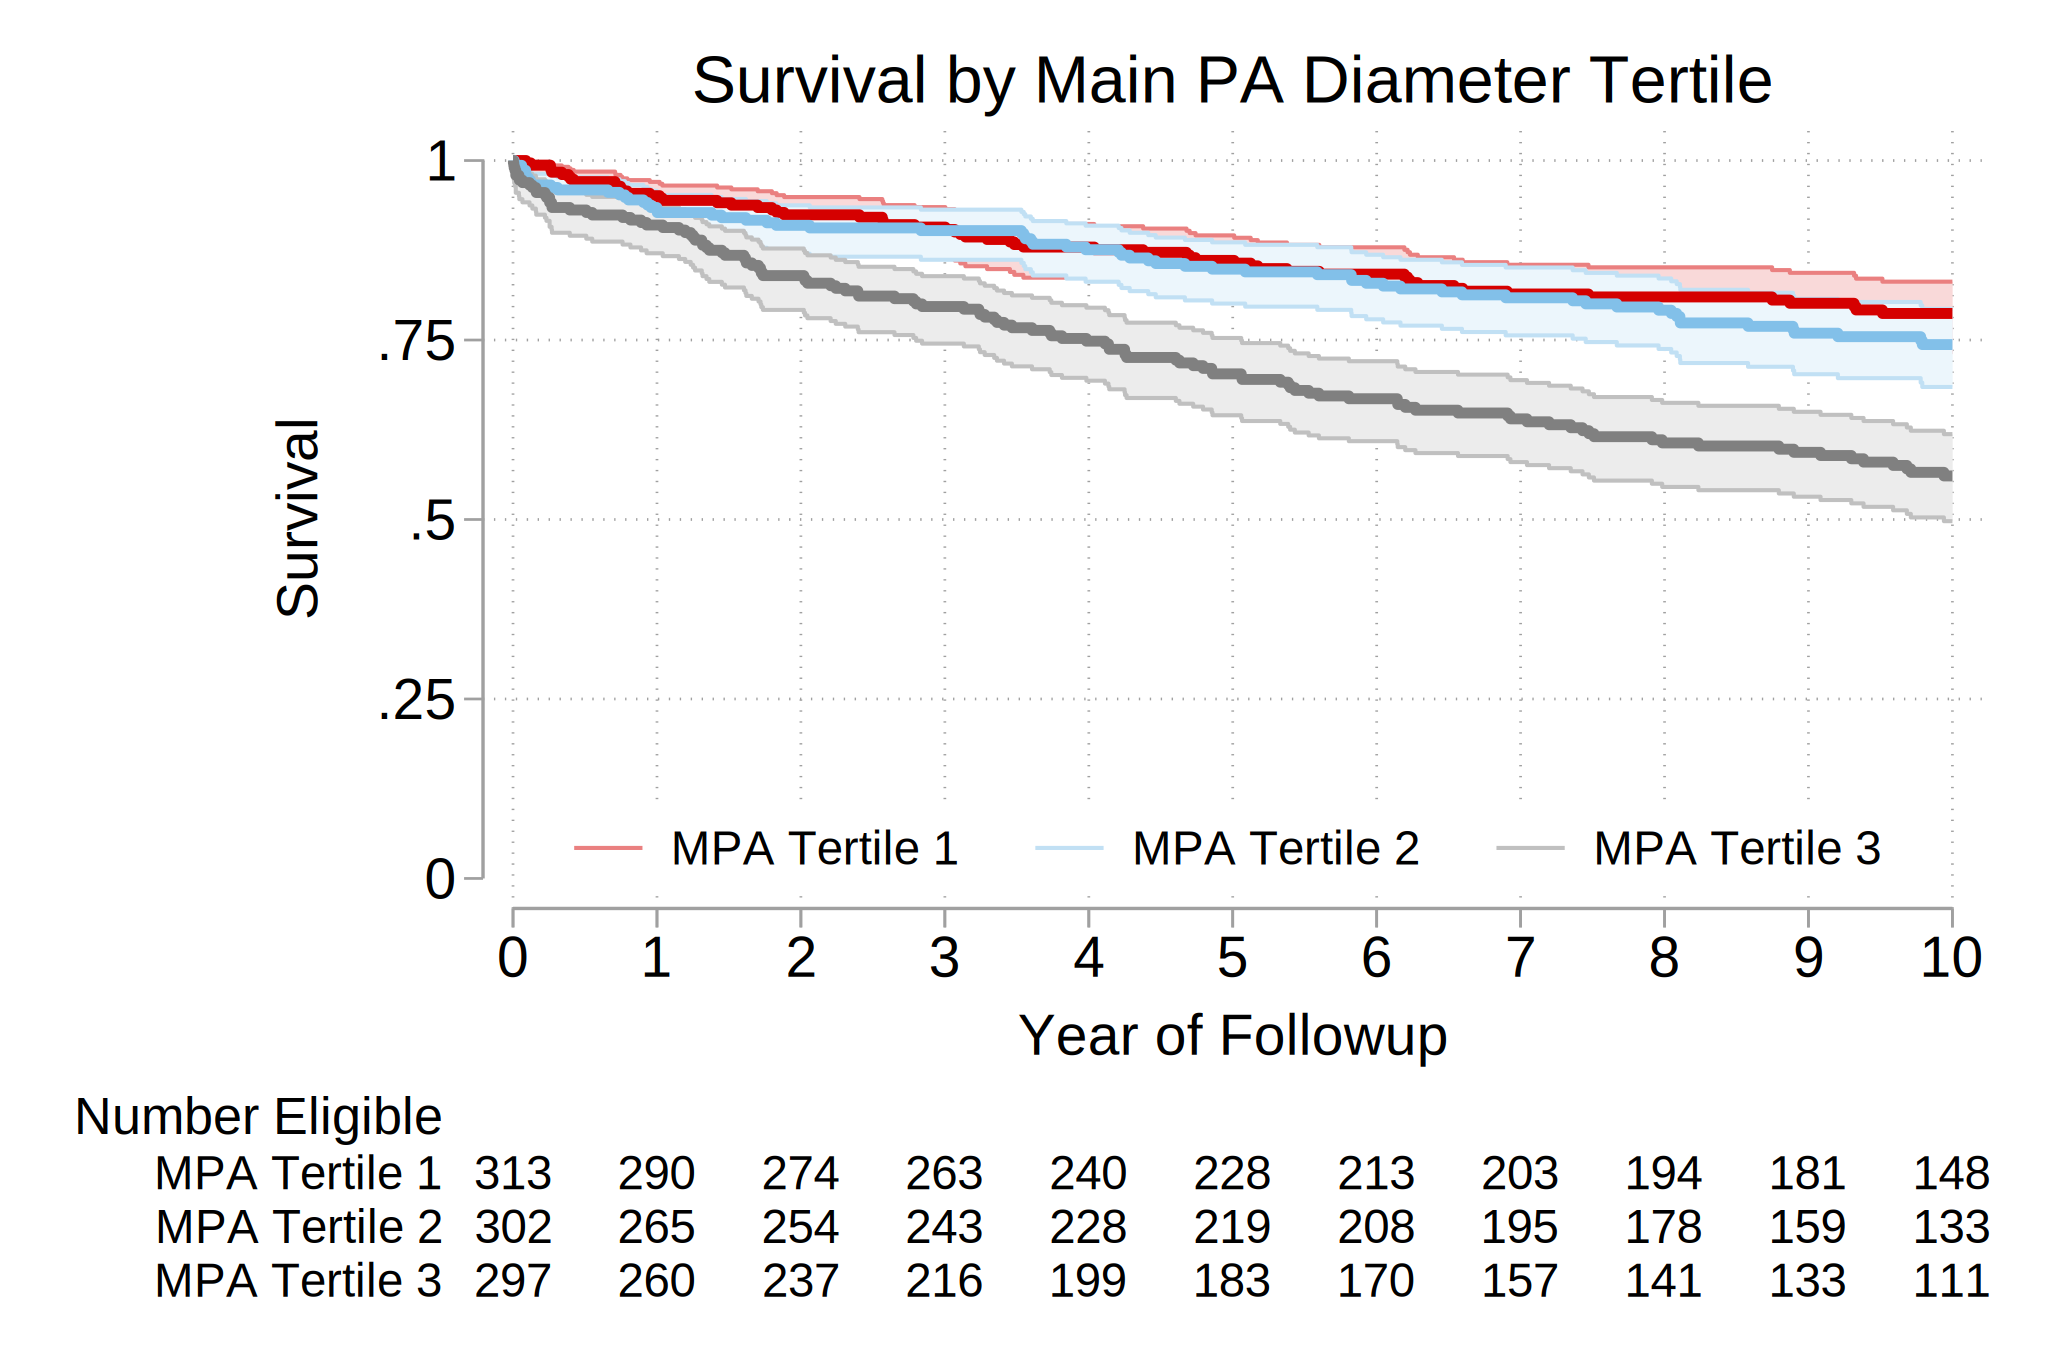

In [21]:
%%stata 

sts graph, by(mpad_tertile) tmax(10) ci surv ///
 plotopts(lwidth(thick)) ///
 risktable(0(1)10, order(1 "MPA Tertile 1" 2 "MPA Tertile 2" 3 "MPA Tertile 3") title("Number Eligible", size(medium)) size(medsmall)) ///
 xlabel(0(1)10, labsize(medlarge)) ///
 ylabel(,labsize(medlarge)) ///
 xtitle("Year of Followup", size(medlarge)) ///
 ytitle("Survival", size(medlarge)) ///
 legend(order(2 "MPA Tertile 1" 4 "MPA Tertile 2" 6 "MPA Tertile 3") position(6) ring(0) rows(1) size(medsmall)) ///
 title("Survival by Main PA Diameter Tertile", size(large))

mostly highest tertile PAs that die. (suspect age is confounding this)

In [22]:
%%stata

stcox i.mpad_tertile
estat concordance
stbrier i.mpad_tertile, bt(12.4819)


. 
. stcox i.mpad_tertile

        Failure _d: death==1
  Analysis time _t: lastfollowupyear

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood = -1674.8791
Iteration 2:  Log likelihood = -1674.5942
Iteration 3:  Log likelihood = -1674.5942
Refining estimates:
Iteration 0:  Log likelihood = -1674.5942

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(2)    =  37.54
Log likelihood = -1674.5942                             Prob > chi2   = 0.0000

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpad_tertile |
MPAD Tert..  |    1.26738   .2166131     1.39   0.166     .9066184    1.771696
MP

Harrell's C = 0.5980 .... not great prediction accuracy using just tertile

Adding age and sex as predictors to the model: 

In [ ]:
%%stata 

stcox i.mpad_tertile c.age i.male
estat concordance
stbrier i.mpad_tertile, bt(12.4819)


. 
. stcox i.mpad_tertile c.age

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood = -1573.5355
Iteration 2:  Log likelihood = -1572.9782
Iteration 3:  Log likelihood = -1572.9779
Refining estimates:
Iteration 0:  Log likelihood = -1572.9779

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(3)    = 240.77
Log likelihood = -1572.9779                             Prob > chi2   = 0.0000

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpad_tertile |
MPAD Tert..  |   1.138615   .1946306     0.76   0.448     .8144708    1.591761
MPAD Tert.

quite a bit better prediction: Harrell C 0.7539


. 
. stcox i.mpad_tertile c.age male

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood =  -1570.436
Iteration 2:  Log likelihood = -1569.7309
Iteration 3:  Log likelihood = -1569.7305
Refining estimates:
Iteration 0:  Log likelihood = -1569.7305

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(4)    = 247.27
Log likelihood = -1569.7305                             Prob > chi2   = 0.0000

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpad_tertile |
MPAD Tert..  |   1.102178   .1889749     0.57   0.570     .7876044    1.542394
MPAD 

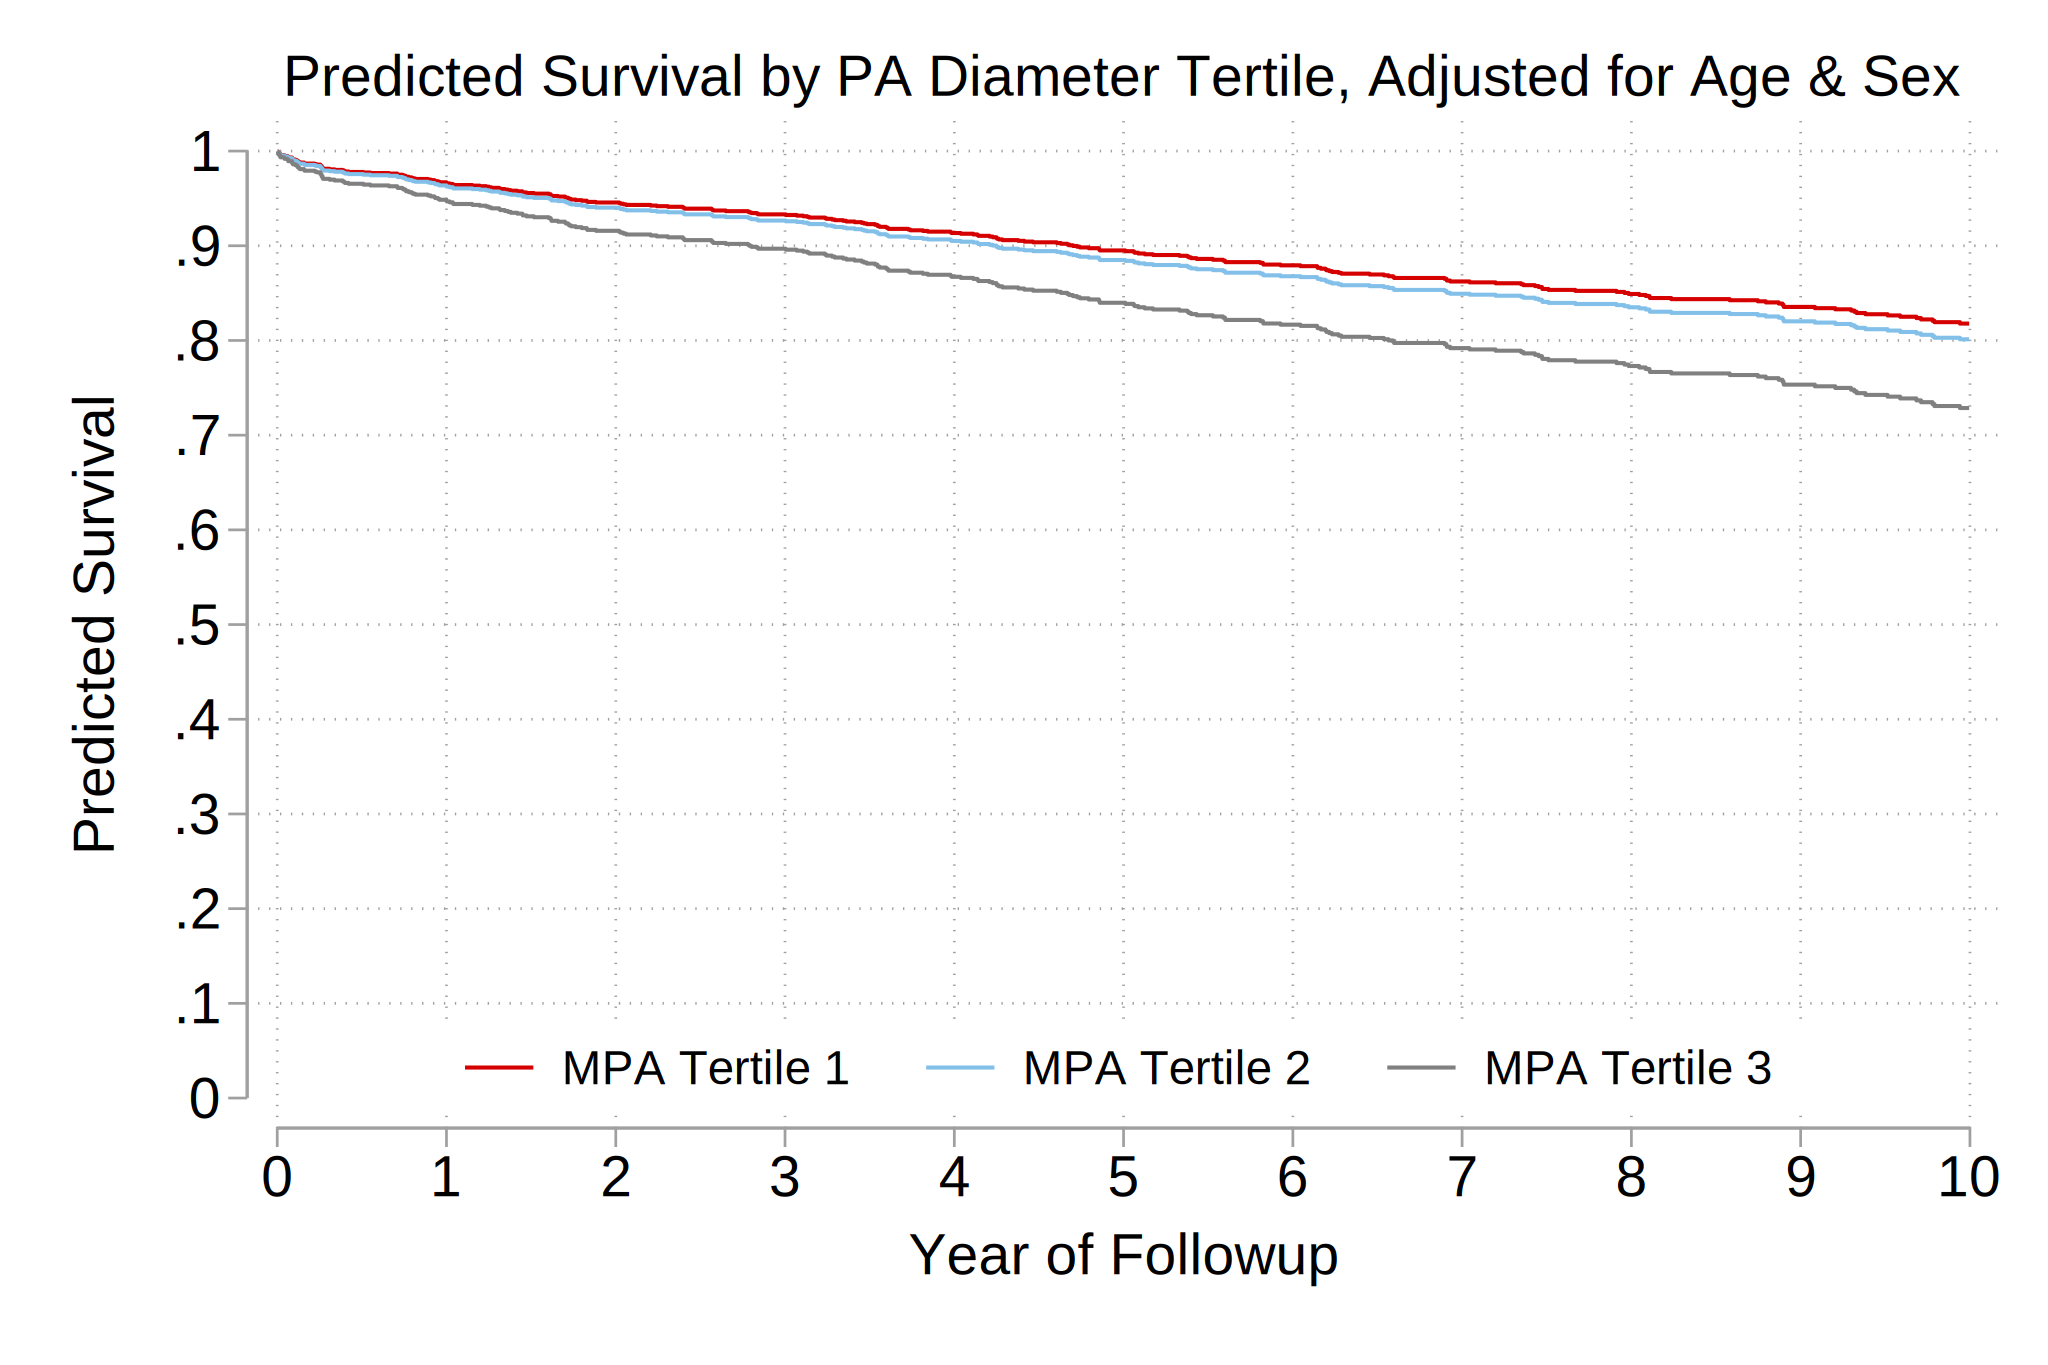

In [28]:
%%stata

stcox i.mpad_tertile c.age male
stcurve, surv at(mpad_tertile=1 male=0.3737 age=52) /// at mean values
          at(mpad_tertile=2 male=0.3737 age=52) ///
          at(mpad_tertile=3 male=0.3737 age=52) ///
          range(0 10) ///
          xlabel(0(1)10, labsize(medlarge)) ///
          ylabel(0(.1)1,labsize(medlarge)) ///
          xtitle("Year of Followup", size(medlarge)) ///
          ytitle("Predicted Survival", size(medlarge)) ///
          title("Predicted Survival by PA Diameter Tertile, Adjusted for Age & Sex", size(medlarge)) ///
          legend(order(1 "MPA Tertile 1" 2 "MPA Tertile 2" 3 "MPA Tertile 3") ///
                 position(6) ring(0) rows(1) size(medsmall)) 

note: predicted death rates are lower because this displays at the mean age of 52; hazard ratios are the same throughout tho because of proportional hazards assumption

### Age, Sex Specific Tertile Approach MPA diameter

In [29]:
%%stata 

/* Method = use conditional quantile regression to generate age-sex specific
quantile estimates, then split into tertiles based on that and repeat */ 

/* -----
Step 1: Compute 33.3rd and 66.6th Percentiles Using Quantile Regression
-----*/
* Run Quantile Regression Separately for Males
qreg mpad c.age if male == 1, quantile(0.333)
predict mpad_q33_male if male == 1, xb

qreg mpad c.age if male == 1, quantile(0.666)
predict mpad_q66_male if male == 1, xb

* Run Quantile Regression Separately for Females
qreg mpad c.age if male == 0, quantile(0.333)
predict mpad_q33_female if male == 0, xb

qreg mpad c.age if male == 0, quantile(0.666)
predict mpad_q66_female if male == 0, xb

/* -----
Step 2: Categorize Individuals Into Predicted Tertiles
-----*/

* Create an empty variable for tertile classification
gen mpad_pred_tertile = .

* Assign individuals into tertiles based on their predicted quantile cutoffs
replace mpad_pred_tertile = 1 if male == 1 & mpad < mpad_q33_male
replace mpad_pred_tertile = 2 if male == 1 & mpad >= mpad_q33_male & mpad < mpad_q66_male
replace mpad_pred_tertile = 3 if male == 1 & mpad >= mpad_q66_male

replace mpad_pred_tertile = 1 if male == 0 & mpad < mpad_q33_female
replace mpad_pred_tertile = 2 if male == 0 & mpad >= mpad_q33_female & mpad < mpad_q66_female
replace mpad_pred_tertile = 3 if male == 0 & mpad >= mpad_q66_female

/* -----
Step 3: Label the Categories
-----*/

label define mpad_pred_tertile_lbl 1 "MPA Pred Tertile 1" 2 "MPAD Pred Tertile 2" 3 "MPAD Pred Tertile 3"
label values mpad_pred_tertile mpad_pred_tertile_lbl

* Verify the tertile distribution
tab mpad_pred_tertile mpad_tertile


. 
. /* Method = use conditional quantile regression to generate age-sex specific
> quantile estimates, then split into tertiles based on that and repeat */ 
. 
. /* -----
> Step 1: Compute 33.3rd and 66.6th Percentiles Using Quantile Regression
> -----*/
. * Run Quantile Regression Separately for Males
. qreg mpad c.age if male == 1, quantile(0.333)

Iteration 1:  WLS sum of weighted deviations =  590.66637

Iteration 1:  Sum of abs. weighted deviations =  591.93094
Iteration 2:  Sum of abs. weighted deviations =   551.7607
Iteration 3:  Sum of abs. weighted deviations =  550.28064
Iteration 4:  Sum of abs. weighted deviations =  541.46338
Iteration 5:  Sum of abs. weighted deviations =  540.80858
Iteration 6:  Sum of abs. weighted deviations =  540.80635

.333 Quantile regression                            Number of obs =        370
  Raw sum of deviations 554.4912 (about 24.799999)
  Min sum of deviations 540.8063                    Pseudo R2     =     0.0247

---------------------

In [30]:
%%stata

tab mpad_pred_tertile mpad_tertile

kappaetc mpad_pred_tertile mpad_tertile


. 
. tab mpad_pred_tertile mpad_tertile

                    |       3 quantiles of mpad
  mpad_pred_tertile | MPAD Tert  MPAD Tert  MPAD Tert |     Total
--------------------+---------------------------------+----------
 MPA Pred Tertile 1 |       281         47          0 |       328 
MPAD Pred Tertile 2 |        55        224         49 |       328 
MPAD Pred Tertile 3 |         0         65        269 |       334 
--------------------+---------------------------------+----------
              Total |       336        336        318 |       990 

. 
. kappaetc mpad_pred_tertile mpad_tertile

Interrater agreement                             Number of subjects =     990
                                                Ratings per subject =       2
                                        Number of rating categories =       3
------------------------------------------------------------------------------
                     |   Coef.  Std. Err.    t    P>|t|   [95% Conf. Interval]
-----

In [31]:
%%stata 

tab3way mpad_pred_tertile mpad_tertile age_decade 


. 
. tab3way mpad_pred_tertile mpad_tertile age_decade 


Table entries are cell frequencies
Missing categories ignored

--------------------------------------------------------------------
                    |    Age (by decade) and 3 quantiles of mpad    
                    | ------------------ <30 years -----------------
  mpad_pred_tertile | MPAD Tertile 1  MPAD Tertile 2  MPAD Tertile 3
--------------------+-----------------------------------------------
 MPA Pred Tertile 1 |             52                                
MPAD Pred Tertile 2 |             23              20                
MPAD Pred Tertile 3 |                             27              25
--------------------------------------------------------------------

--------------------------------------------------------------------
                    |    Age (by decade) and 3 quantiles of mpad    
                    | ----------------- 30-40 years ----------------
  mpad_pred_tertile | MPAD Tertile 1  MPAD Tertil

actual tertile to age-sex-specific tertile shifts definitely change by age group


. 
. /* -----
> Define Colors for MPAD Predicted Tertiles
> -----*/ 
. 
. colorpalette Spectral, n(3) nograph  

. local color3 `"`r(p1)'"'  // MPAD Tertile 3 (High)

. local color2 `"`r(p2)'"'  // MPAD Tertile 2 (Middle)

. local color1 `"`r(p3)'"'  // MPAD Tertile 1 (Low)

. 
. /* -----
> Generate Quantile Regression Predictions for Males
> -----*/ 
. 
. qreg mpad c.age if male == 1, quantile(0.333) // Male

Iteration 1:  WLS sum of weighted deviations =  590.66637

Iteration 1:  Sum of abs. weighted deviations =  591.93094
Iteration 2:  Sum of abs. weighted deviations =   551.7607
Iteration 3:  Sum of abs. weighted deviations =  550.28064
Iteration 4:  Sum of abs. weighted deviations =  541.46338
Iteration 5:  Sum of abs. weighted deviations =  540.80858
Iteration 6:  Sum of abs. weighted deviations =  540.80635

.333 Quantile regression                            Number of obs =        370
  Raw sum of deviations 554.4912 (about 24.799999)
  Min sum of deviations 540.8063         

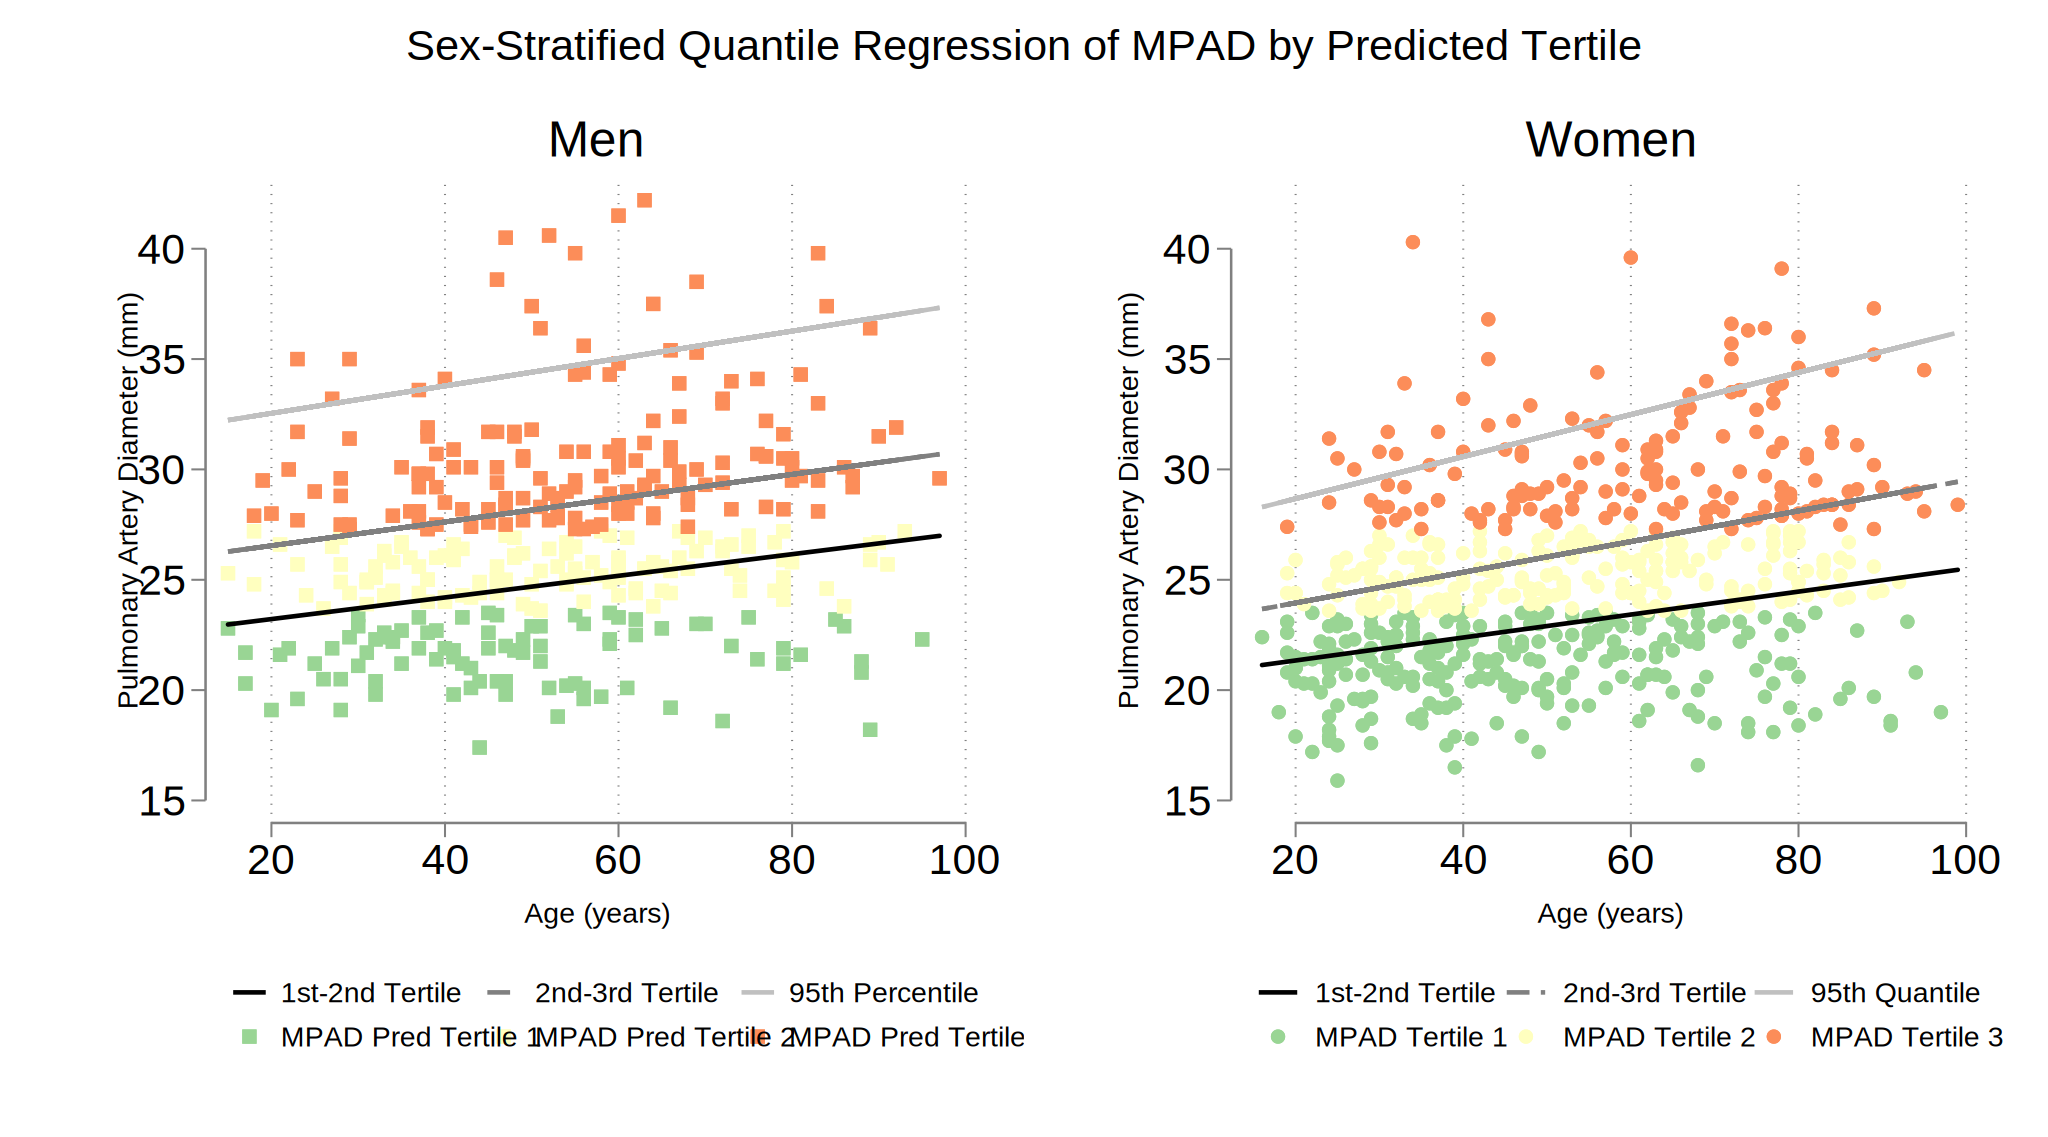

In [32]:
%%stata 

/* -----
Define Colors for MPAD Predicted Tertiles
-----*/ 

colorpalette Spectral, n(3) nograph  
local color3 `"`r(p1)'"'  // MPAD Tertile 3 (High)
local color2 `"`r(p2)'"'  // MPAD Tertile 2 (Middle)
local color1 `"`r(p3)'"'  // MPAD Tertile 1 (Low)

/* -----
Generate Quantile Regression Predictions for Males
-----*/ 

qreg mpad c.age if male == 1, quantile(0.333) // Male
predict mpad_33_male if male == 1, xb
qreg mpad c.age if male == 1, quantile(0.666) // Male
predict mpad_66_male if male == 1, xb
qreg mpad c.age if male == 1, quantile(95) // Male
predict mpad_95_male if male == 1, xb

/* -----
Male Scatter Plot (Color by MPAD Predicted Tertile)
-----*/ 
twoway ///
    (scatter mpad age if male == 1 & mpad_tertile == 1, mcolor("`color1'") msymbol(S)) || /// MPAD Tertile 1 (Low)
    (scatter mpad age if male == 1 & mpad_tertile == 2, mcolor("`color2'") msymbol(S)) || /// MPAD Tertile 2 (Middle)
    (scatter mpad age if male == 1 & mpad_tertile == 3, mcolor("`color3'") msymbol(S)) || /// MPAD Tertile 3 (High)
    (line mpad_33_male age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 50th percentile line
    (line mpad_66_male age, lcolor(gs8) lpattern(dash) lwidth(medthick)) || /// 90th percentile line
    (line mpad_95_male age, lcolor(gs12) lpattern(longdash) lwidth(medthick)), /// 95th percentile line
    ///
    legend(order(4 "1st-2nd Tertile" 5 "2nd-3rd Tertile" 6 "95th Percentile" ///
                 1 "MPAD Pred Tertile 1" 2 "MPAD Pred Tertile 2" 3 "MPAD Pred Tertile 3") ///
           pos(6) row(2)) ///
    xtitle("Age (years)") ytitle("Pulmonary Artery Diameter (mm)", margin(medlarge)) ///
    title("Men") ///
    xlabel(, labsize(medlarge)) ylabel(15(5)40, nogrid labsize(medlarge)) /// Adjusted Y-axis range
    scheme(white_w3d) yscale(range(15 40)) ///
    saving(male_qreg_plot, replace)


/* -----
Generate Quantile Regression Predictions for Females
-----*/ 

qreg mpad c.age if male == 0, quantile(0.333) // Female
predict mpad_33_female if male == 0, xb
qreg mpad c.age if male == 0, quantile(0.666) // Female
predict mpad_66_female if male == 0, xb
qreg mpad c.age if male == 0, quantile(95) // Female
predict mpad_95_female if male == 0, xb

/* -----
Female Scatter Plot (Color by MPAD Predicted Tertile)
-----*/ 
twoway ///
    (scatter mpad age if male == 0 & mpad_tertile == 1, mcolor("`color1'") msymbol(O)) || /// MPAD Tertile 1 (Low)
    (scatter mpad age if male == 0 & mpad_tertile == 2, mcolor("`color2'") msymbol(O)) || /// MPAD Tertile 2 (Middle)
    (scatter mpad age if male == 0 & mpad_tertile == 3, mcolor("`color3'") msymbol(O)) || /// MPAD Tertile 3 (High)
    (line mpad_33_female age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 50th percentile line
    (line mpad_66_female age, lcolor(gs8) lpattern(dash) lwidth(medthick)) || /// 90th percentile line
    (line mpad_95_female age, lcolor(gs12) lpattern(longdash) lwidth(medthick)), /// 95th percentile line
    ///
    legend(order(4 "1st-2nd Tertile" 5 "2nd-3rd Tertile" 6 "95th Quantile" ///
                 1 "MPAD Tertile 1" 2 "MPAD Tertile 2" 3 "MPAD Tertile 3") ///
           pos(6) row(2)) ///
    xtitle("Age (years)") ytitle("Pulmonary Artery Diameter (mm)", margin(medlarge)) ///
    title("Women") ///
    xlabel(, labsize(medlarge)) ylabel(15(5)40, nogrid labsize(medlarge)) /// Adjusted Y-axis range
    scheme(white_w3d) yscale(range(15 40)) ///
    saving(female_qreg_plot, replace)


/* -----
Combine the Two Plots into a Single Figure
-----*/ 
graph combine male_qreg_plot.gph female_qreg_plot.gph, ///
    title("Sex-Stratified Quantile Regression of MPAD by Predicted Tertile") ///
    ycommon xcommon ///
    iscale(*1.2) ///
    rows(1) ///
    graphregion(margin(2 2 2 2)) ///
    xsize(9) ysize(5)


this graph shows: 

- in colors = the overall tertile of PA size 
- the lines = the age-sex specific thresholds (and the 95th percentile)

when the color change and line don't line up, those are patients who's PA size will be classified differently 


. 
. * Log-rank test for survival differences across MPAAA tertiles
. sts test mpad_pred_tertile, logrank 

        Failure _d: death==1
  Analysis time _t: _t

Equality of survivor functions
Log-rank test

                    |  Observed       Expected
mpad_pred_~e        |    events         events
--------------------+-------------------------
 MPA Pred Tertile 1 |        77          89.80
MPAD Pred Tertile 2 |        77          87.70
MPAD Pred Tertile 3 |       109          85.50
--------------------+-------------------------
              Total |       263         263.00

                              chi2(2) =   9.59
                              Pr>chi2 = 0.0083

. 
. * Kaplan-Meier Survival Curve by MPAAA Tertile
. sts graph, by(mpad_pred_tertile) tmax(10) ci surv ///
>  plotopts(lwidth(thick)) ///
>  risktable(0(1)10, order(1 "Age-Sex MPA Tertile 1" 2 "Age-Sex MPA Tertile 2" 
> 3 "Age-Sex MPA Tertile 3") title("Number Eligible", size(medium)) size(medsma
> ll)) ///
>  xlabel(

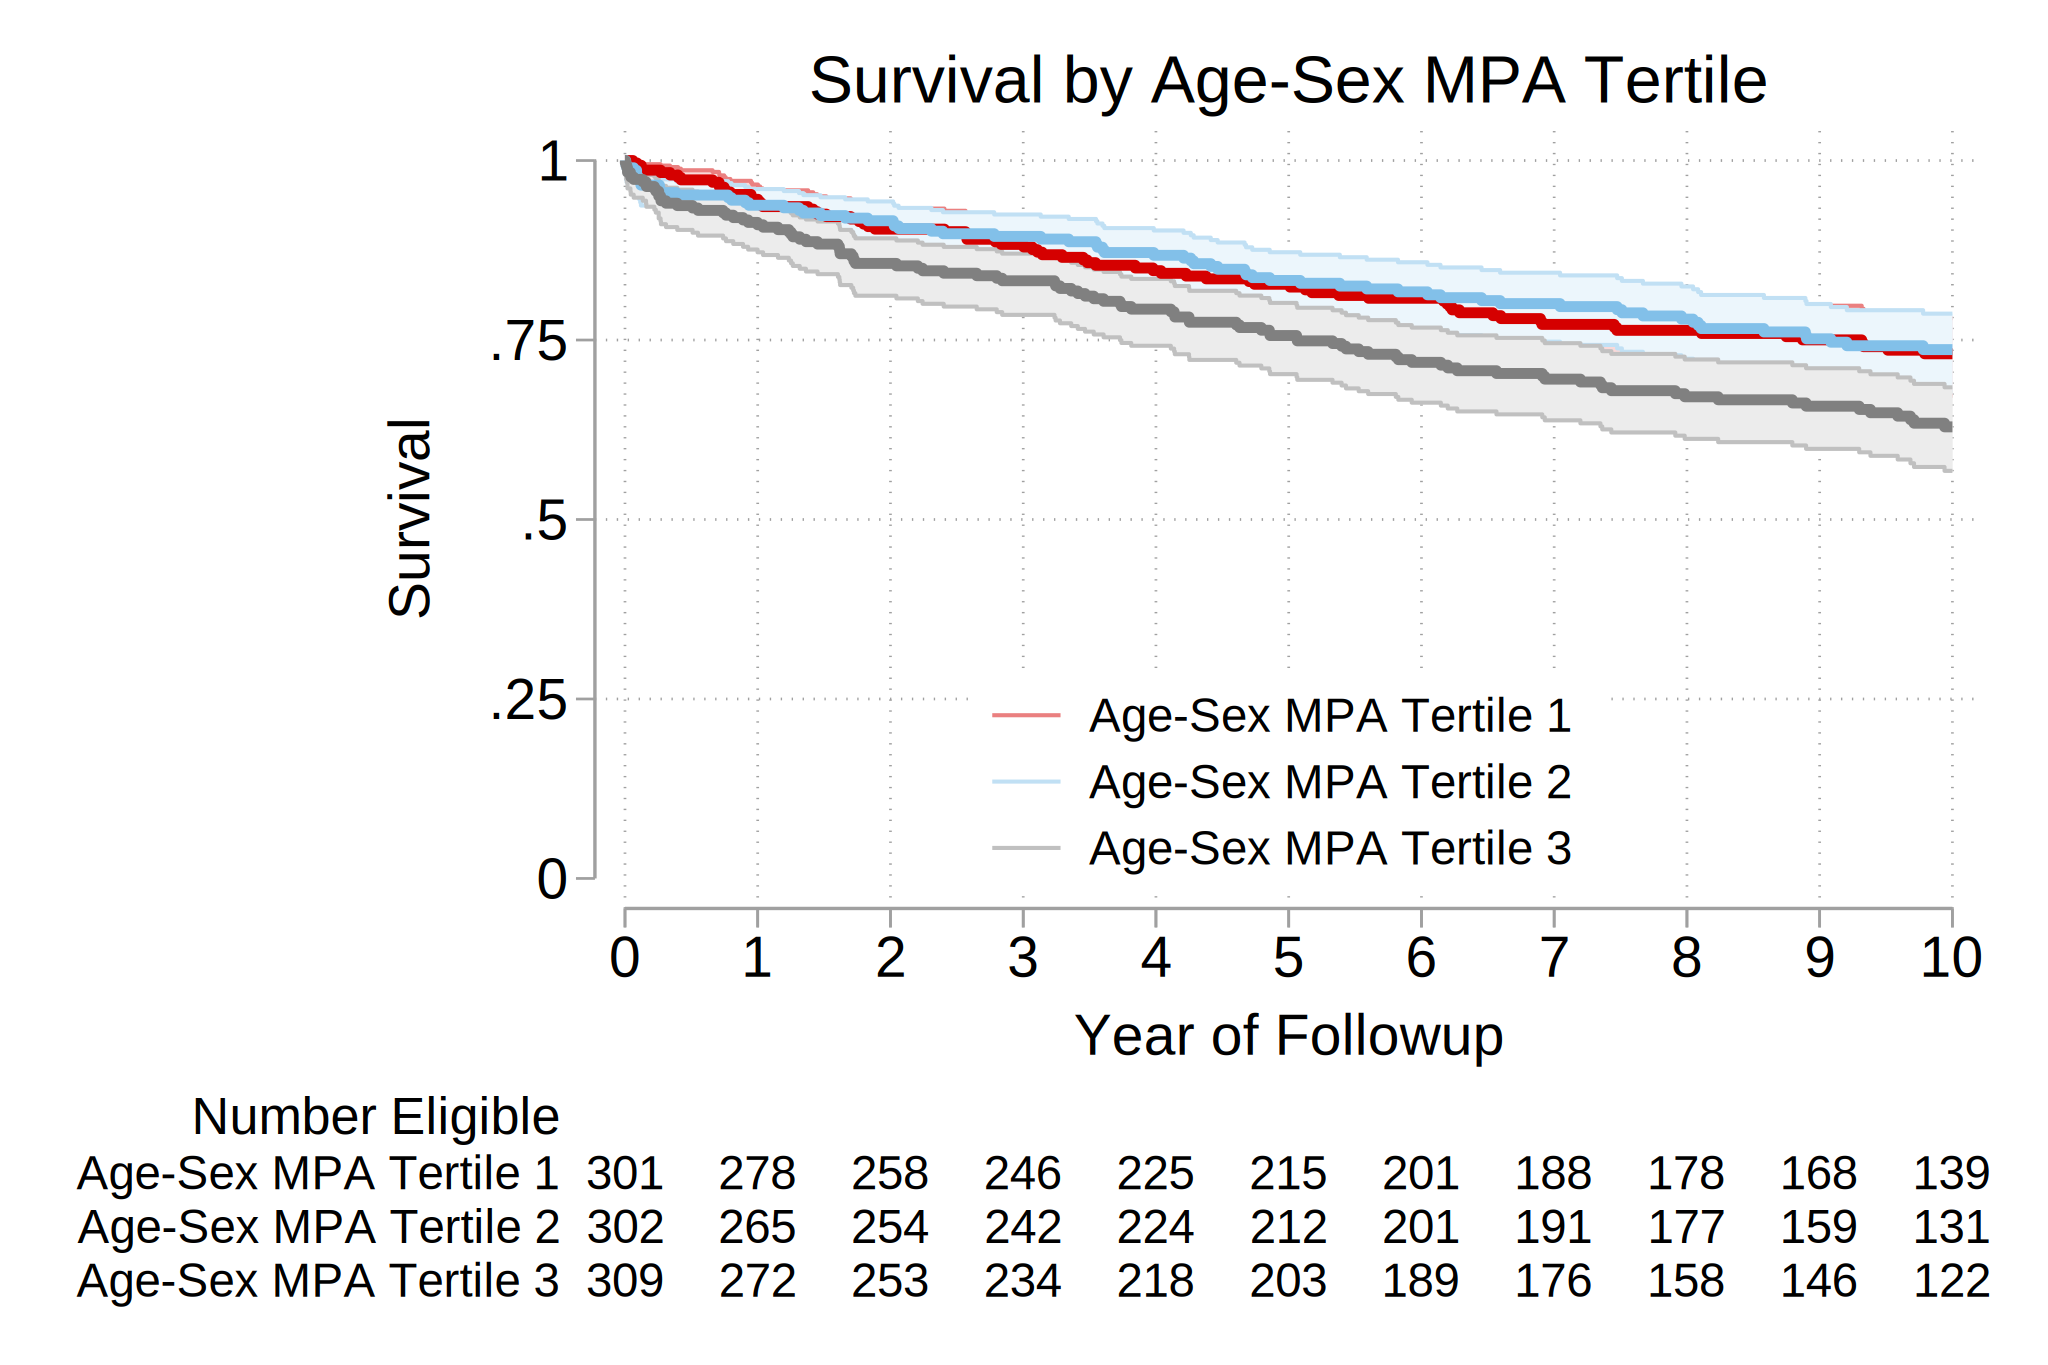

In [33]:
%%stata

* Log-rank test for survival differences across MPAAA tertiles
sts test mpad_pred_tertile, logrank 

* Kaplan-Meier Survival Curve by MPAAA Tertile
sts graph, by(mpad_pred_tertile) tmax(10) ci surv ///
 plotopts(lwidth(thick)) ///
 risktable(0(1)10, order(1 "Age-Sex MPA Tertile 1" 2 "Age-Sex MPA Tertile 2" 3 "Age-Sex MPA Tertile 3") title("Number Eligible", size(medium)) size(medsmall)) ///
 xlabel(0(1)10, labsize(medlarge)) ///
 ylabel(,labsize(medlarge)) ///
 xtitle("Year of Followup", size(medlarge)) ///
 ytitle("Survival", size(medlarge)) ///
 legend(order(2 "Age-Sex MPA Tertile 1" 4 "Age-Sex MPA Tertile 2" 6 "Age-Sex MPA Tertile 3") position(6) ring(0) rows(3) size(medsmall)) ///
 title("Survival by Age-Sex MPA Tertile", size(large))


interestingly, it works WORSE as a predictor. 

hmmm... 

In [ ]:
%%stata

stcox i.mpad_pred_tertile
estat concordance

/* -----
Brier Score for MPAAA Tertile Model
-----*/ 
stbrier i.mpad_tertile, bt(12.4819)


. 
. stcox i.mpad_pred_tertile

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood = -1688.7719
Iteration 2:  Log likelihood = -1688.7557
Iteration 3:  Log likelihood = -1688.7557
Refining estimates:
Iteration 0:  Log likelihood = -1688.7557

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(2)    =   9.22
Log likelihood = -1688.7557                             Prob > chi2   = 0.0100

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpad_pred_~e |
MPAD Pred..  |   1.023961   .1650353     0.15   0.883     .7466072    1.404347
MPAD Pred..

And if we add age and sex as predictors to the model: 

In [37]:
%%stata 

stcox i.mpad_pred_tertile c.age i.male


. 
. stcox i.mpad_pred_tertile c.age i.male

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood =  -1568.304
Iteration 2:  Log likelihood = -1567.7946
Iteration 3:  Log likelihood = -1567.7944
Refining estimates:
Iteration 0:  Log likelihood = -1567.7944

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(4)    = 251.14
Log likelihood = -1567.7944                             Prob > chi2   = 0.0000

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpad_pred_~e |
MPAD Pred..  |   1.085267   .1750404     0.51   0.612     .7911304    1.48876


. 
. stcox i.mpad_pred_tertile c.age male

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood =  -1568.304
Iteration 2:  Log likelihood = -1567.7946
Iteration 3:  Log likelihood = -1567.7944
Refining estimates:
Iteration 0:  Log likelihood = -1567.7944

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(4)    = 251.14
Log likelihood = -1567.7944                             Prob > chi2   = 0.0000

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpad_pred_~e |
MPAD Pred..  |   1.085267   .1750404     0.51   0.612     .7911304    1.488761


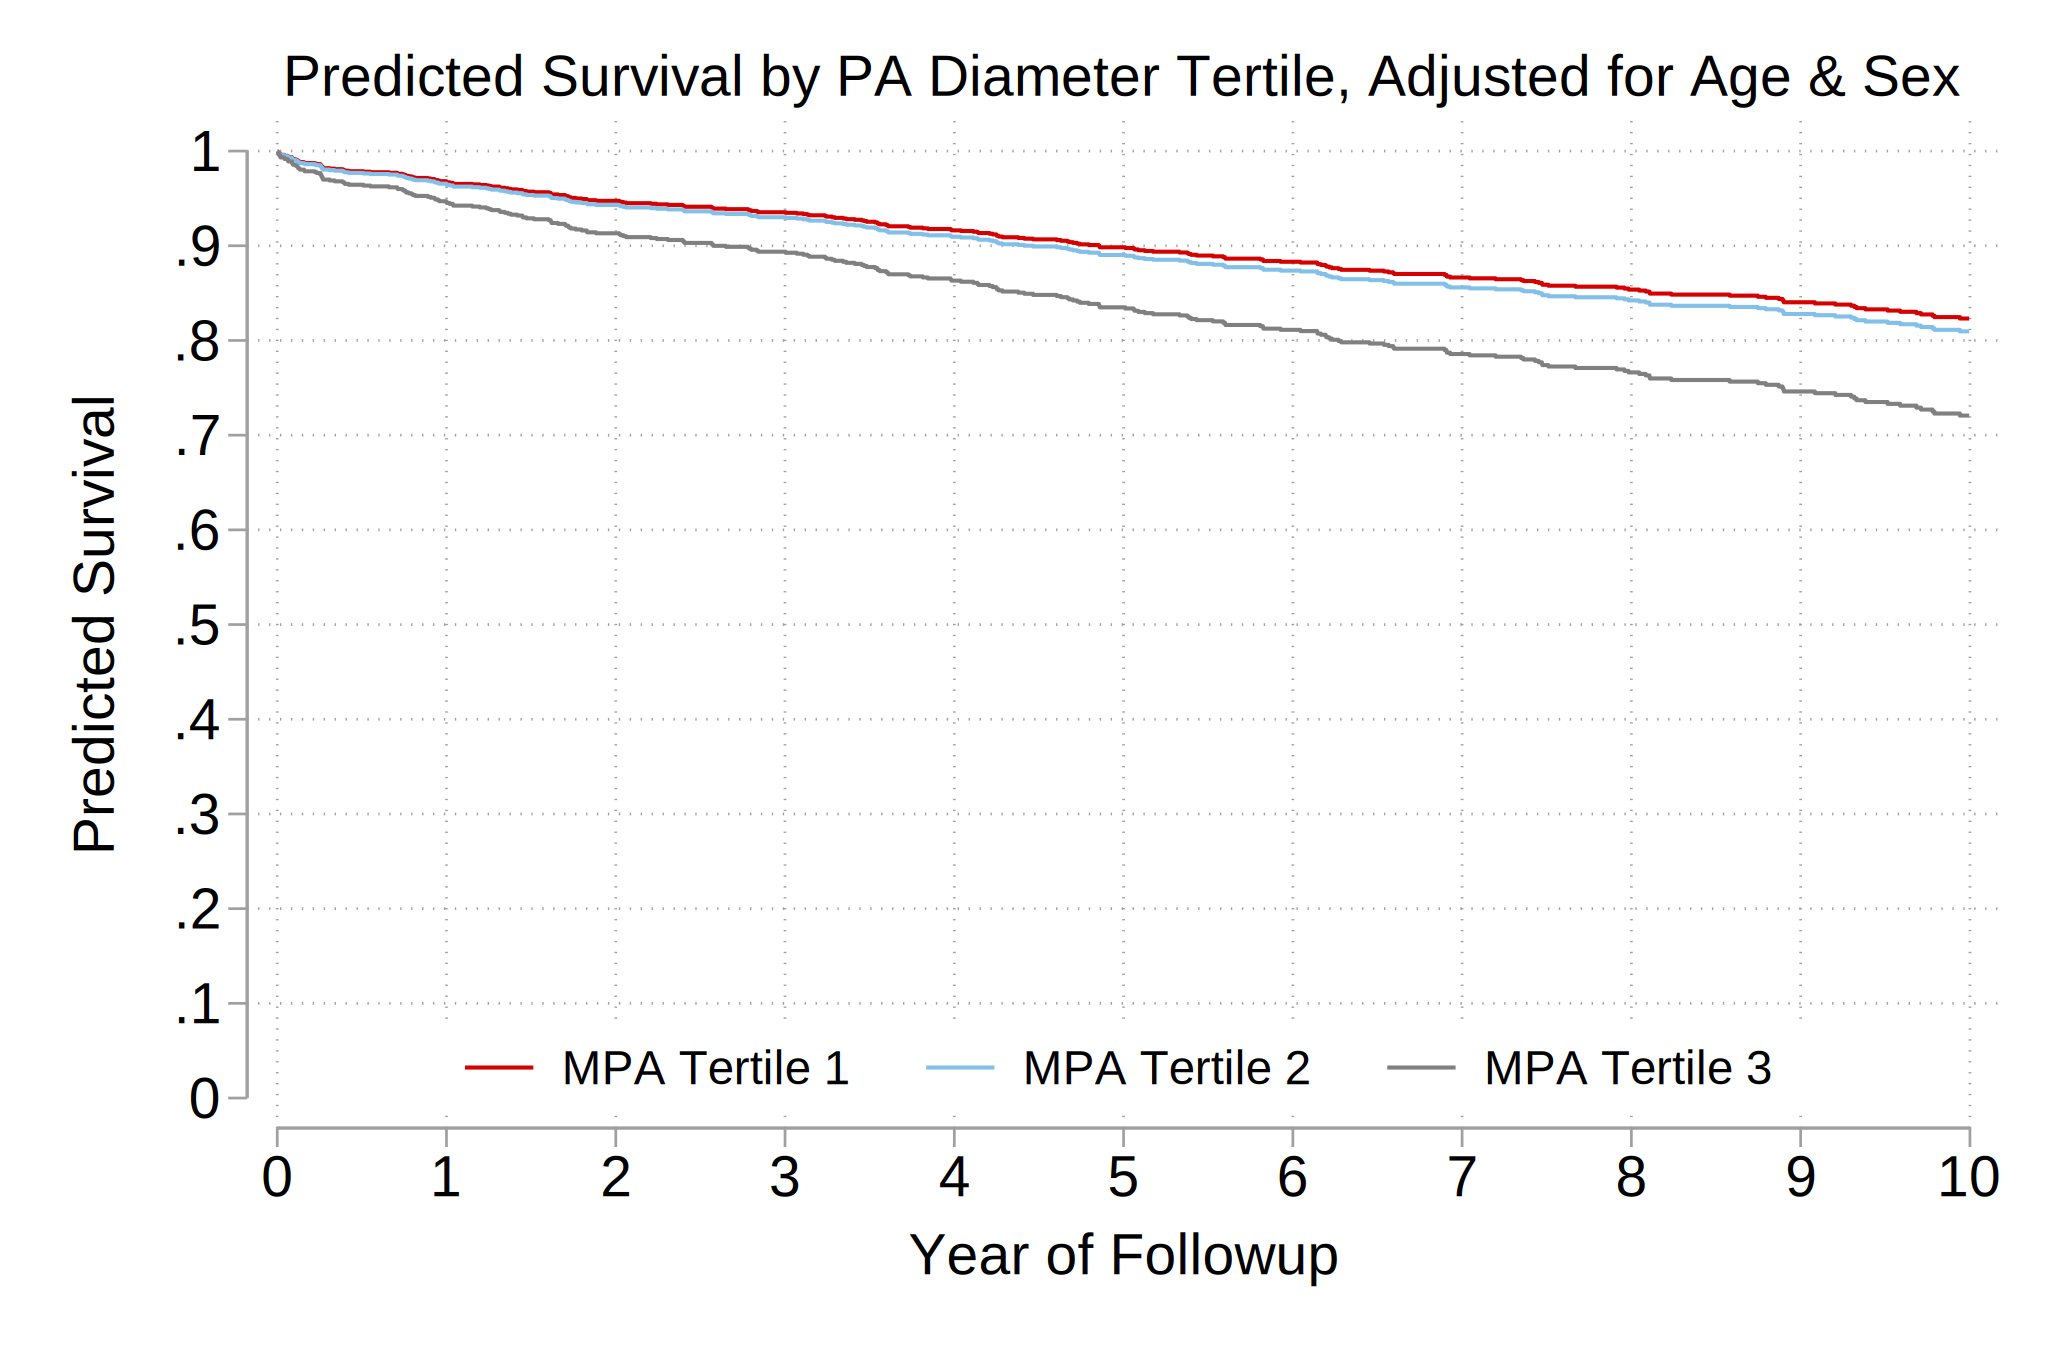

In [39]:
%%stata

stcox i.mpad_pred_tertile c.age male
stcurve, surv at(mpad_pred_tertile=1 male=0.3737 age=52) /// at mean values
          at(mpad_pred_tertile=2 male=0.3737 age=52) ///
          at(mpad_pred_tertile=3 male=0.3737 age=52) ///
          range(0 10) ///
          xlabel(0(1)10, labsize(medlarge)) ///
          ylabel(0(.1)1,labsize(medlarge)) ///
          xtitle("Year of Followup", size(medlarge)) ///
          ytitle("Predicted Survival", size(medlarge)) ///
          title("Predicted Survival by PA Diameter Tertile, Adjusted for Age & Sex", size(medlarge)) ///
          legend(order(1 "MPA Tertile 1" 2 "MPA Tertile 2" 3 "MPA Tertile 3") ///
                 position(6) ring(0) rows(1) size(medsmall)) 

In [40]:
%%stata

stcox i.mpad_pred_tertile c.age i.male
estat concordance

/* -----
Brier Score for MPAD Tertile Model
-----*/ 
stbrier i.mpad_tertile c.age i.male, bt(12.4819)



. 
. stcox i.mpad_pred_tertile c.age i.male

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood =  -1568.304
Iteration 2:  Log likelihood = -1567.7946
Iteration 3:  Log likelihood = -1567.7944
Refining estimates:
Iteration 0:  Log likelihood = -1567.7944

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(4)    = 251.14
Log likelihood = -1567.7944                             Prob > chi2   = 0.0000

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpad_pred_~e |
MPAD Pred..  |   1.085267   .1750404     0.51   0.612     .7911304    1.48876

Overall - this is pretty similar in performance to the non-standardized version

#### Takeaway: not much in the way of accuracy boost from age-sex standardizing PA size. 

## PA to AA ratio

Considering all the same methods with PA:AA gives us... 


. 
. /* MPA:AA */ 
. ridgeline mpaaa, by(age_decade) yline ylw(0.2) overlap(1.7) ylc(blue) ylp(dot
> ) ////
>         labpos(right) bwid(0.05) laboffset(-0.05) showstats xlabel(0.6(.1)1.3
> ) ///
>         palette(CET C6) alpha(75) xtitle("PA:AA Ratio")

. 


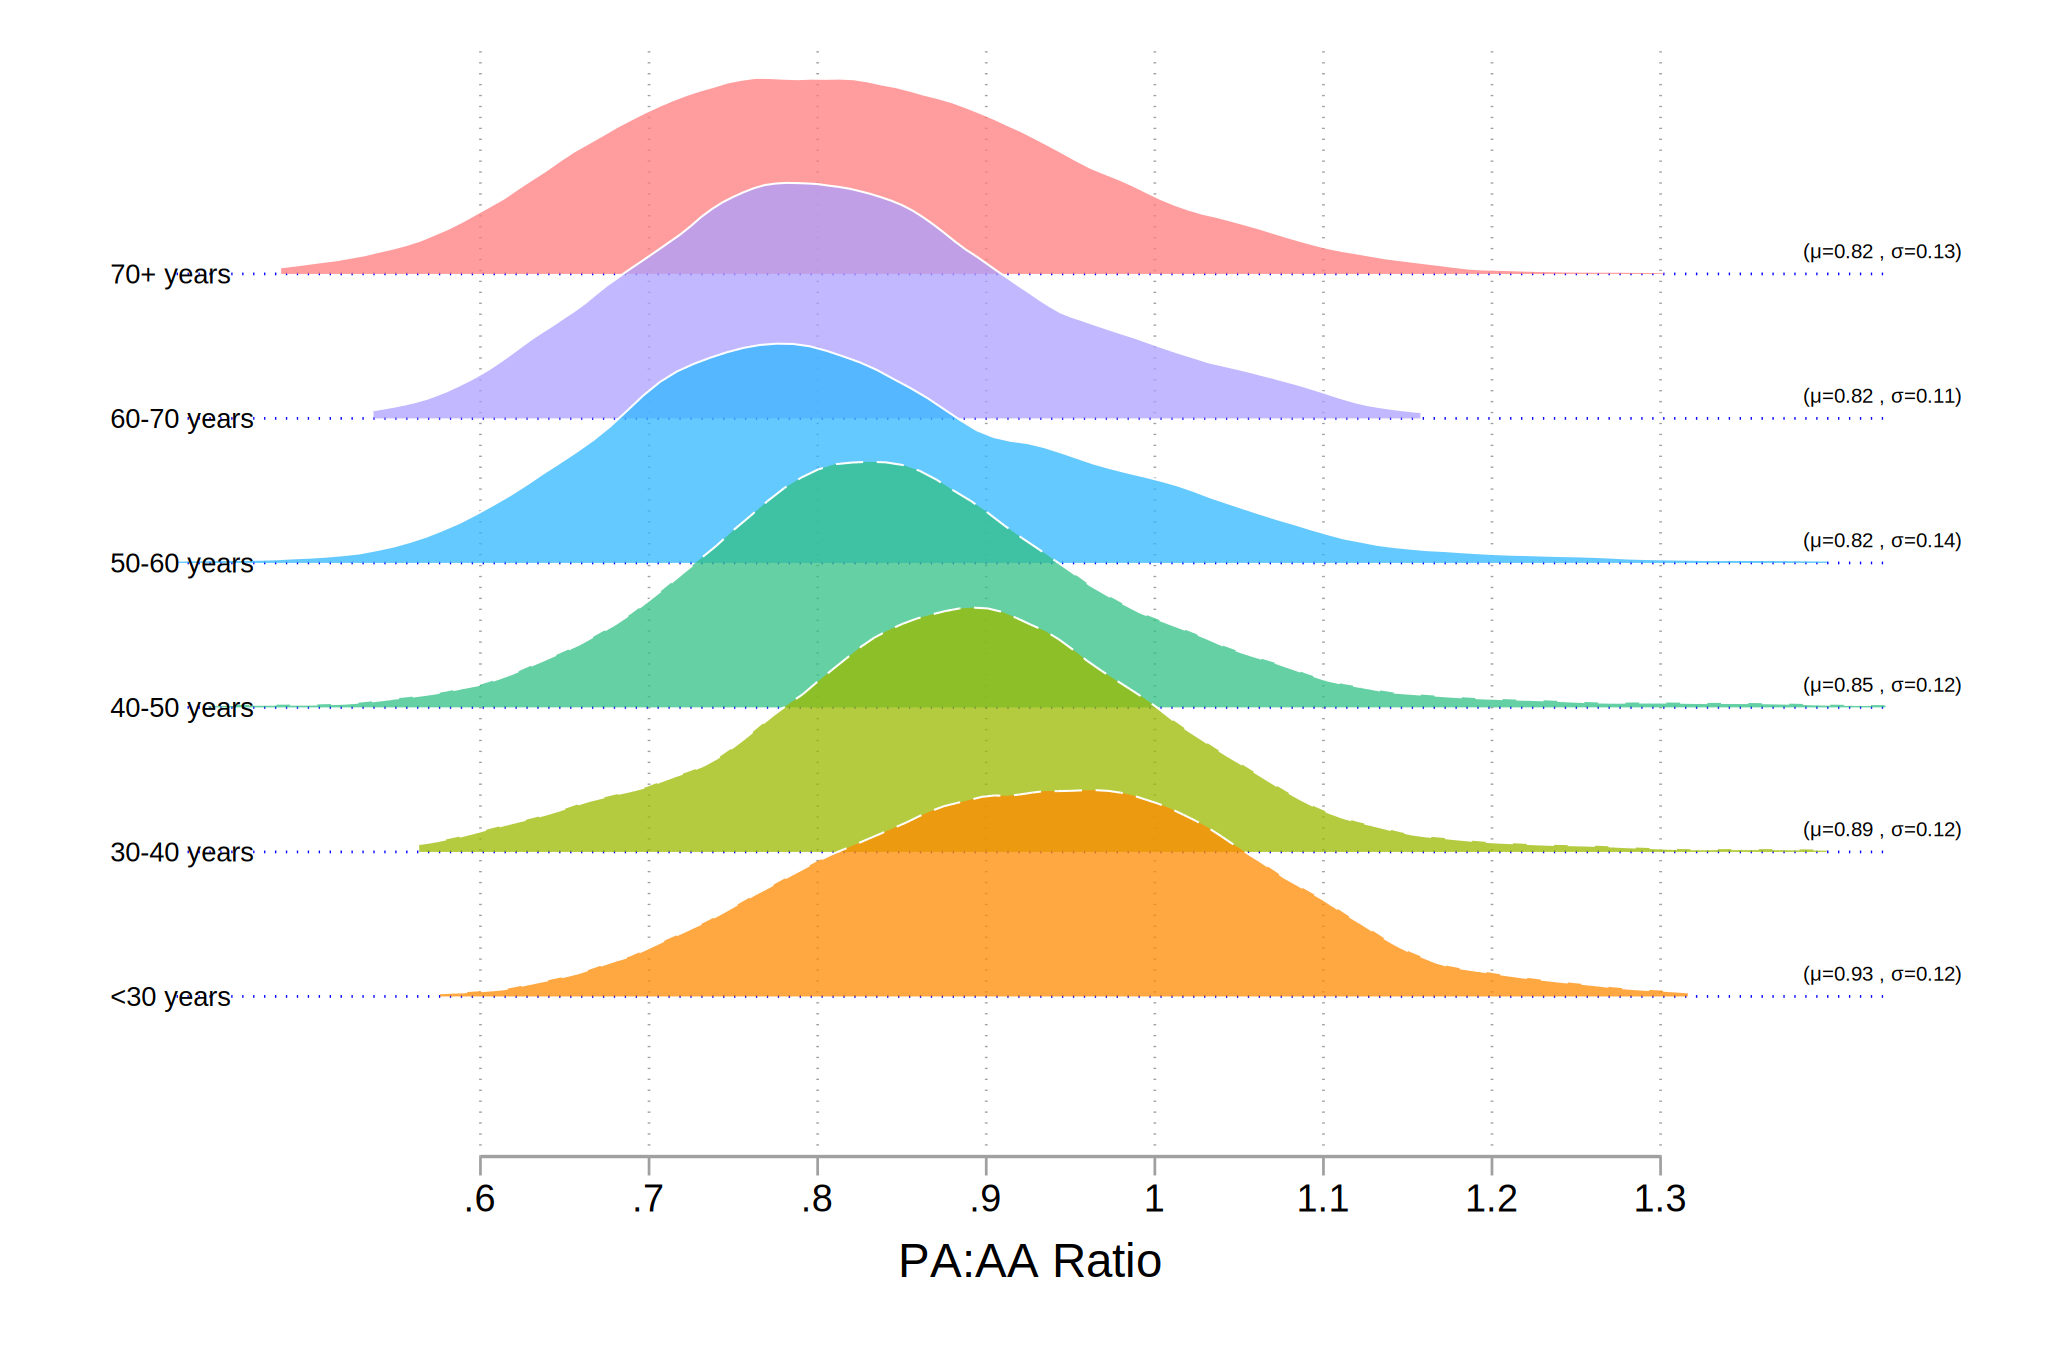

In [41]:
%%stata 

/* MPA:AA */ 
ridgeline mpaaa, by(age_decade) yline ylw(0.2) overlap(1.7) ylc(blue) ylp(dot) ////
	labpos(right) bwid(0.05) laboffset(-0.05) showstats xlabel(0.6(.1)1.3) ///
	palette(CET C6) alpha(75) xtitle("PA:AA Ratio")


. 
. * Ridgeline plot for Females (male == 0) - PA:AA Ratio
. ridgeline mpaaa if male == 0, by(age_decade) yline ylw(0.2) overlap(1.7) ///
>     ylc(blue) ylp(dot) labpos(right) bwid(0.05) laboffset(-0.05) ///
>     showstats xlabel(0.6(.1)1.3) palette(CET C6) alpha(75) ///
>     xtitle("PA:AA Ratio") ///
>     title("PA:AA Ratio by Age Group - Female") ///
>     saving(ridgeline_mpaaa_female, replace)

. 
. * Ridgeline plot for Males (male == 1) - PA:AA Ratio
. ridgeline mpaaa if male == 1, by(age_decade) yline ylw(0.2) overlap(1.7) ///
>     ylc(red) ylp(dot) labpos(right) bwid(0.05) laboffset(-0.05) ///
>     showstats xlabel(0.6(.1)1.3) palette(CET C6) alpha(75) ///
>     xtitle("PA:AA Ratio") ///
>     title("PA:AA Ratio by Age Group - Male") ///
>     saving(ridgeline_mpaaa_male, replace)

. 
. graph combine ridgeline_mpaaa_female.gph ridgeline_mpaaa_male.gph, ///
>     title("Ridgeline Plot of PA:AA Ratio by Age & Sex")
(note:  named style i not found in class symbol, default a

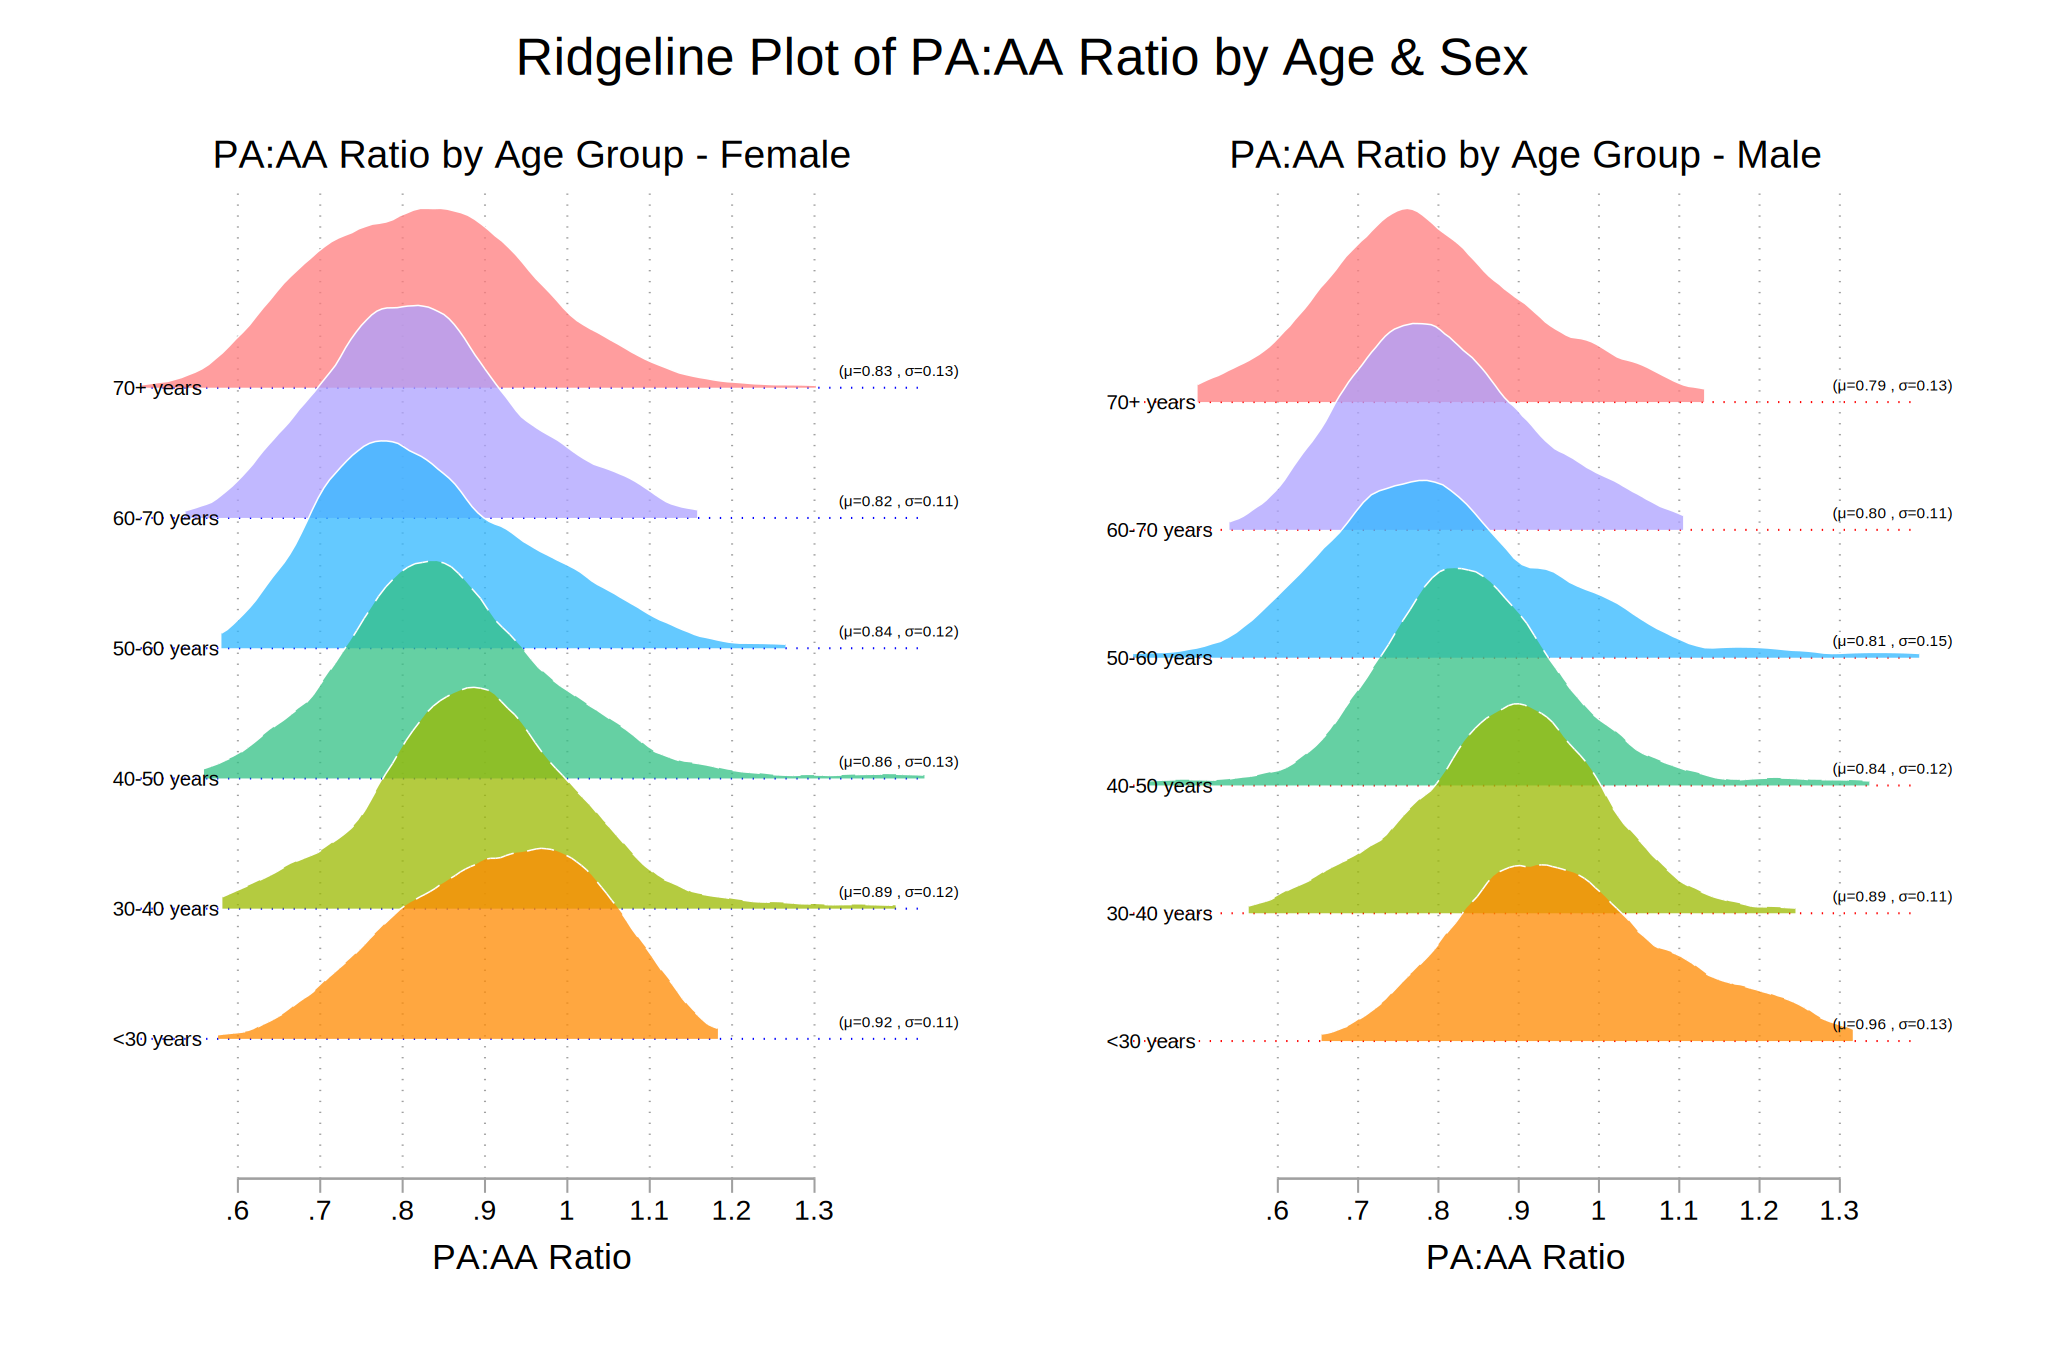

In [42]:
%%stata

* Ridgeline plot for Females (male == 0) - PA:AA Ratio
ridgeline mpaaa if male == 0, by(age_decade) yline ylw(0.2) overlap(1.7) ///
    ylc(blue) ylp(dot) labpos(right) bwid(0.05) laboffset(-0.05) ///
    showstats xlabel(0.6(.1)1.3) palette(CET C6) alpha(75) ///
    xtitle("PA:AA Ratio") ///
    title("PA:AA Ratio by Age Group - Female") ///
    saving(ridgeline_mpaaa_female, replace)

* Ridgeline plot for Males (male == 1) - PA:AA Ratio
ridgeline mpaaa if male == 1, by(age_decade) yline ylw(0.2) overlap(1.7) ///
    ylc(red) ylp(dot) labpos(right) bwid(0.05) laboffset(-0.05) ///
    showstats xlabel(0.6(.1)1.3) palette(CET C6) alpha(75) ///
    xtitle("PA:AA Ratio") ///
    title("PA:AA Ratio by Age Group - Male") ///
    saving(ridgeline_mpaaa_male, replace)

graph combine ridgeline_mpaaa_female.gph ridgeline_mpaaa_male.gph, ///
    title("Ridgeline Plot of PA:AA Ratio by Age & Sex")
	

In [43]:
%%stata 

/* Run Bootstrap Quantile Regressions for the Full Population */
bsqreg mpaaa c.age, quantile(50) reps(500) // 50th Percentile
bsqreg mpaaa c.age, quantile(90) reps(500) // 90th Percentile
bsqreg mpaaa c.age, quantile(95) reps(500) // 95th Percentile


. 
. /* Run Bootstrap Quantile Regressions for the Full Population */
. bsqreg mpaaa c.age, quantile(50) reps(500) // 50th Percentile
(fitting base model)

Bootstrap replications (500): .........10.........20.........30.........40.....
> ....50.........60.........70.........80.........90.........100.........110...
> ......120.........130.........140.........150.........160.........170........
> .180.........190.........200.........210.........220.........230.........240.
> ........250.........260.........270.........280.........290.........300......
> ...310.........320.........330.........340.........350.........360.........37
> 0.........380.........390.........400.........410.........420.........430....
> .....440.........450.........460.........470.........480.........490.........
> 500 done

Median regression, bootstrap(500) SEs               Number of obs =        990
  Raw sum of deviations  50.6267 (about .84615385)
  Min sum of deviations 47.96687                    Pseudo R2


. 
. 
. /* Extract Colors from Spectral Palette */
. colorpalette Spectral, n(6) nograph  

. local color6 `"`r(p1)'"' // Reverse order

. local color5 `"`r(p2)'"'

. local color4 `"`r(p3)'"'

. local color3 `"`r(p4)'"'

. local color2 `"`r(p5)'"'

. local color1 `"`r(p6)'"'

. 
. /* Run Quantile Regressions for the Full Population */
. qreg mpaaa c.age, quantile(50) // 50th Percentile

Iteration 1:  WLS sum of weighted deviations =   48.15387

Iteration 1:  Sum of abs. weighted deviations =  48.165025
Iteration 2:  Sum of abs. weighted deviations =  48.068058
Iteration 3:  Sum of abs. weighted deviations =  47.966871

Median regression                                   Number of obs =        990
  Raw sum of deviations  50.6267 (about .84615385)
  Min sum of deviations 47.96687                    Pseudo R2     =     0.0525

------------------------------------------------------------------------------
       mpaaa | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
----

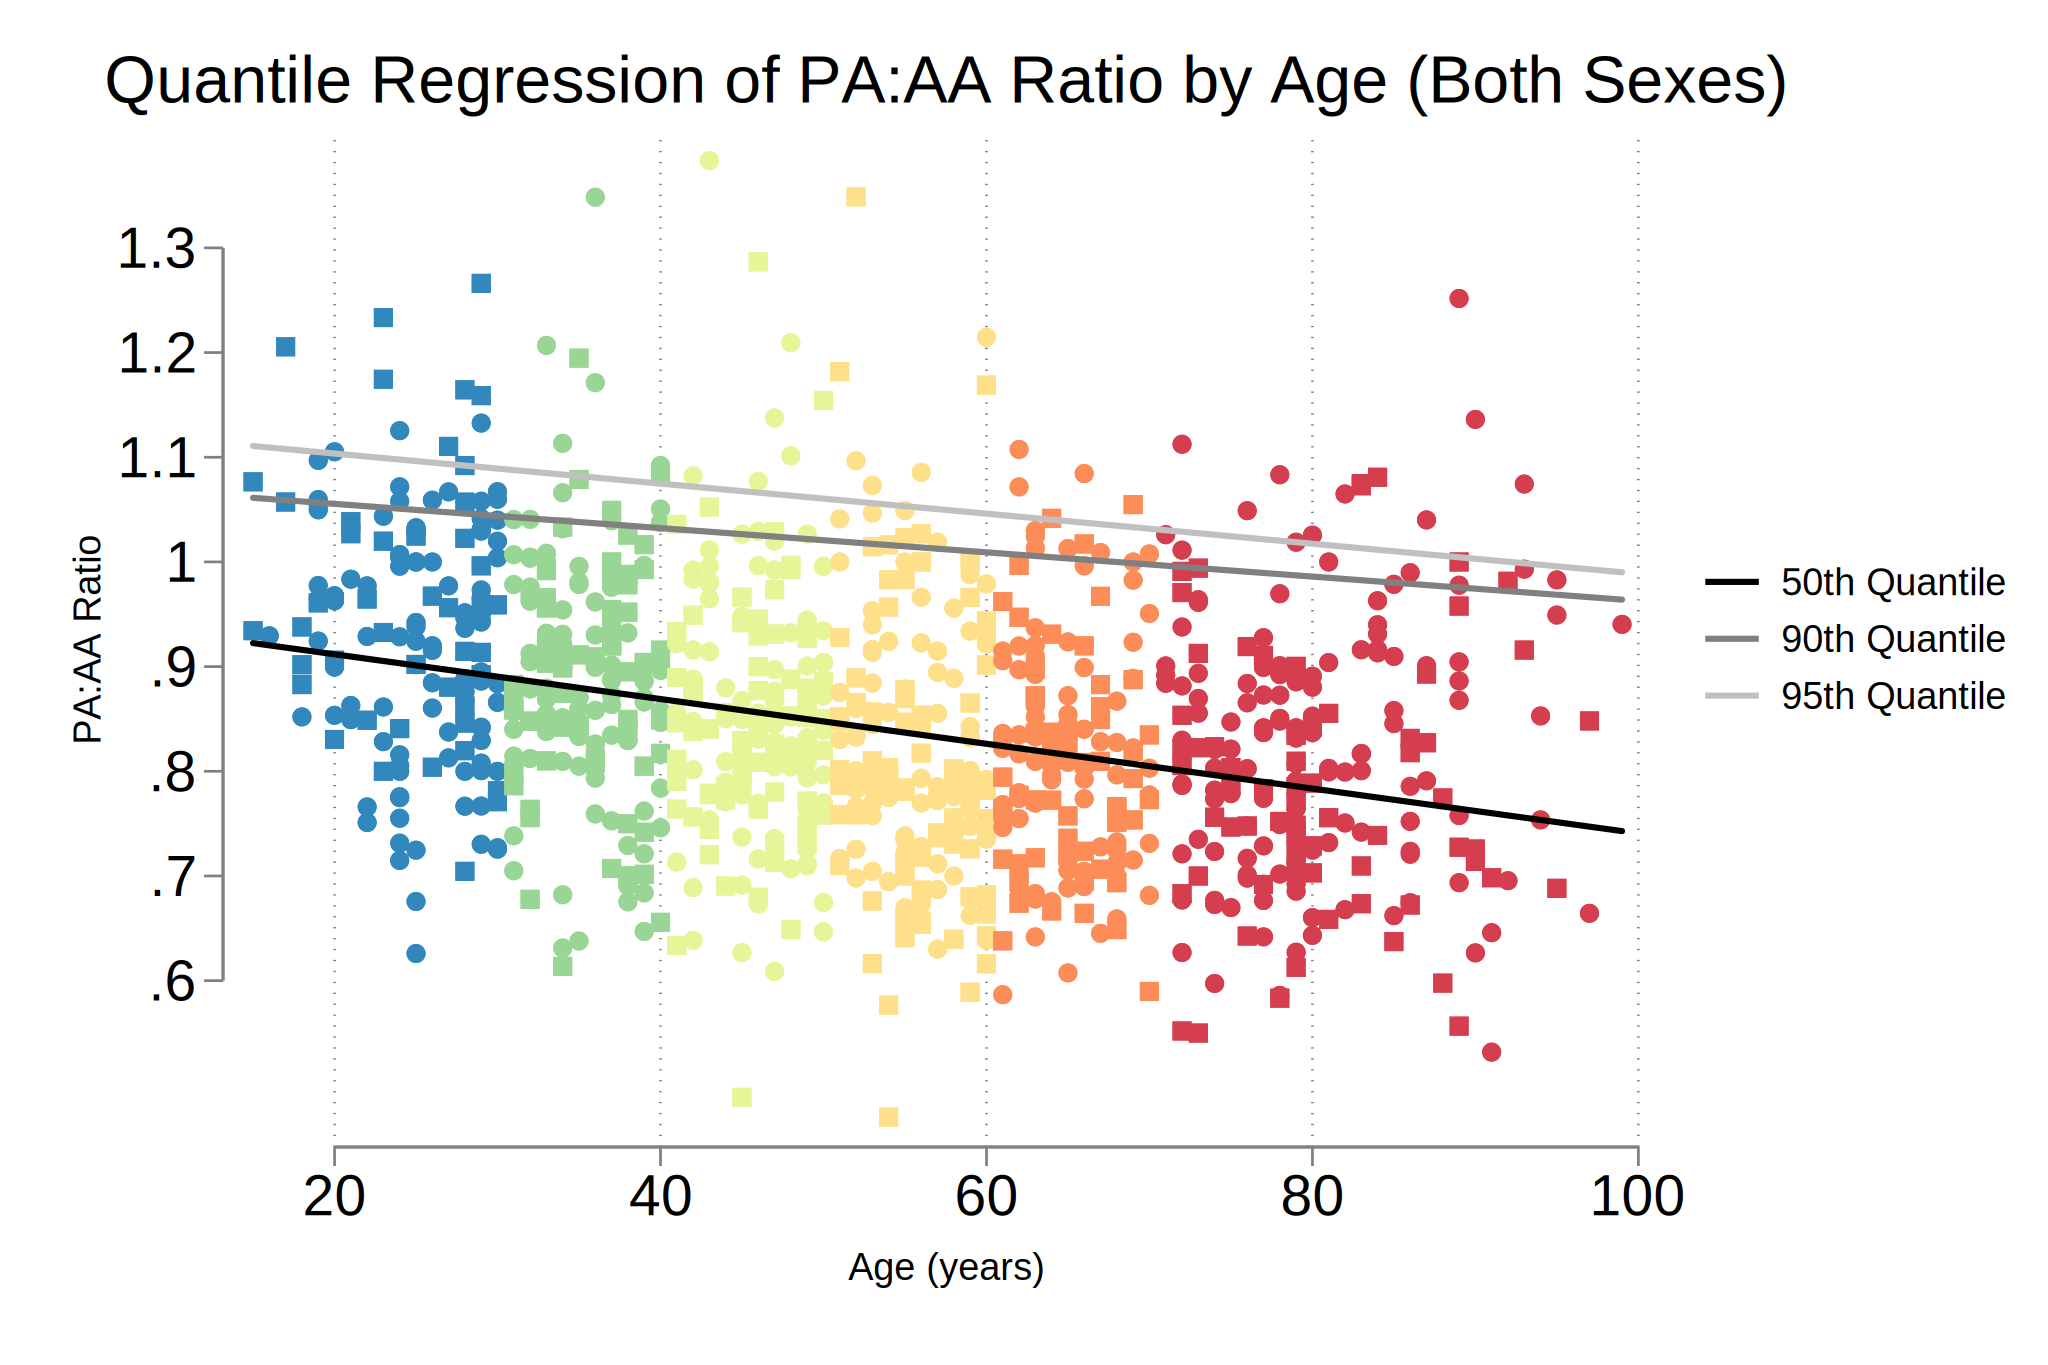

In [44]:
%%stata 


/* Extract Colors from Spectral Palette */
colorpalette Spectral, n(6) nograph  
local color6 `"`r(p1)'"' // Reverse order
local color5 `"`r(p2)'"'
local color4 `"`r(p3)'"'
local color3 `"`r(p4)'"'
local color2 `"`r(p5)'"'
local color1 `"`r(p6)'"'

/* Run Quantile Regressions for the Full Population */
qreg mpaaa c.age, quantile(50) // 50th Percentile
predict mpaaa_q50_all, xb

qreg mpaaa c.age, quantile(90) // 90th Percentile
predict mpaaa_q90_all, xb

qreg mpaaa c.age, quantile(95) // 95th Percentile
predict mpaaa_q95_all, xb

/* Scatter Plot with Both Genders + Quantile Regression Lines */
twoway ///
    (scatter mpaaa age if age_decade == 0 & male == 0, mcolor("`color1'") msymbol(O)) || /// <30 years, Female
    (scatter mpaaa age if age_decade == 0 & male == 1, mcolor("`color1'") msymbol(S)) || /// <30 years, Male
    (scatter mpaaa age if age_decade == 1 & male == 0, mcolor("`color2'") msymbol(O)) || /// 30-40 years, Female
    (scatter mpaaa age if age_decade == 1 & male == 1, mcolor("`color2'") msymbol(S)) || /// 30-40 years, Male
    (scatter mpaaa age if age_decade == 2 & male == 0, mcolor("`color3'") msymbol(O)) || /// 40-50 years, Female
    (scatter mpaaa age if age_decade == 2 & male == 1, mcolor("`color3'") msymbol(S)) || /// 40-50 years, Male
    (scatter mpaaa age if age_decade == 3 & male == 0, mcolor("`color4'") msymbol(O)) || /// 50-60 years, Female
    (scatter mpaaa age if age_decade == 3 & male == 1, mcolor("`color4'") msymbol(S)) || /// 50-60 years, Male
    (scatter mpaaa age if age_decade == 4 & male == 0, mcolor("`color5'") msymbol(O)) || /// 60-70 years, Female
    (scatter mpaaa age if age_decade == 4 & male == 1, mcolor("`color5'") msymbol(S)) || /// 60-70 years, Male
    (scatter mpaaa age if age_decade == 5 & male == 0, mcolor("`color6'") msymbol(O)) || /// 70+ years, Female
    (scatter mpaaa age if age_decade == 5 & male == 1, mcolor("`color6'") msymbol(S)) || /// 70+ years, Male
    (line mpaaa_q50_all age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 50th quantile
    (line mpaaa_q90_all age, lcolor(gs8) lpattern(solid) lwidth(medthick)) || /// 90th quantile
    (line mpaaa_q95_all age, lcolor(gs12) lpattern(solid) lwidth(medthick)), /// 95th quantile
    legend(order(13 "50th Quantile" 14 "90th Quantile" 15 "95th Quantile")) ///
    xtitle("Age (years)") ytitle("PA:AA Ratio") ///
    title("Quantile Regression of PA:AA Ratio by Age (Both Sexes)") ///
    xlabel(, labsize(medlarge)) ylabel(0.6(0.1)1.3, nogrid labsize(medlarge)) ///
    scheme(white_w3d)
	


. 
.         
. /* -----
> Sex-Stratified Quantile Regression Scatter Plots for PA:AA Ratio
> -----*/ 
. 
. /* Run Bootstrap Quantile Regressions for the Men */
. bsqreg mpaaa c.age if male == 1, quantile(50) reps(500) // 50th Percentile
(fitting base model)

Bootstrap replications (500): .........10.........20.........30.........40.....
> ....50.........60.........70.........80.........90.........100.........110...
> ......120.........130.........140.........150.........160.........170........
> .180.........190.........200.........210.........220.........230.........240.
> ........250.........260.........270.........280.........290.........300......
> ...310.........320.........330.........340.........350.........360.........37
> 0.........380.........390.........400.........410.........420.........430....
> .....440.........450.........460.........470.........480.........490.........
> 500 done

Median regression, bootstrap(500) SEs               Number of obs =        370
  Raw su

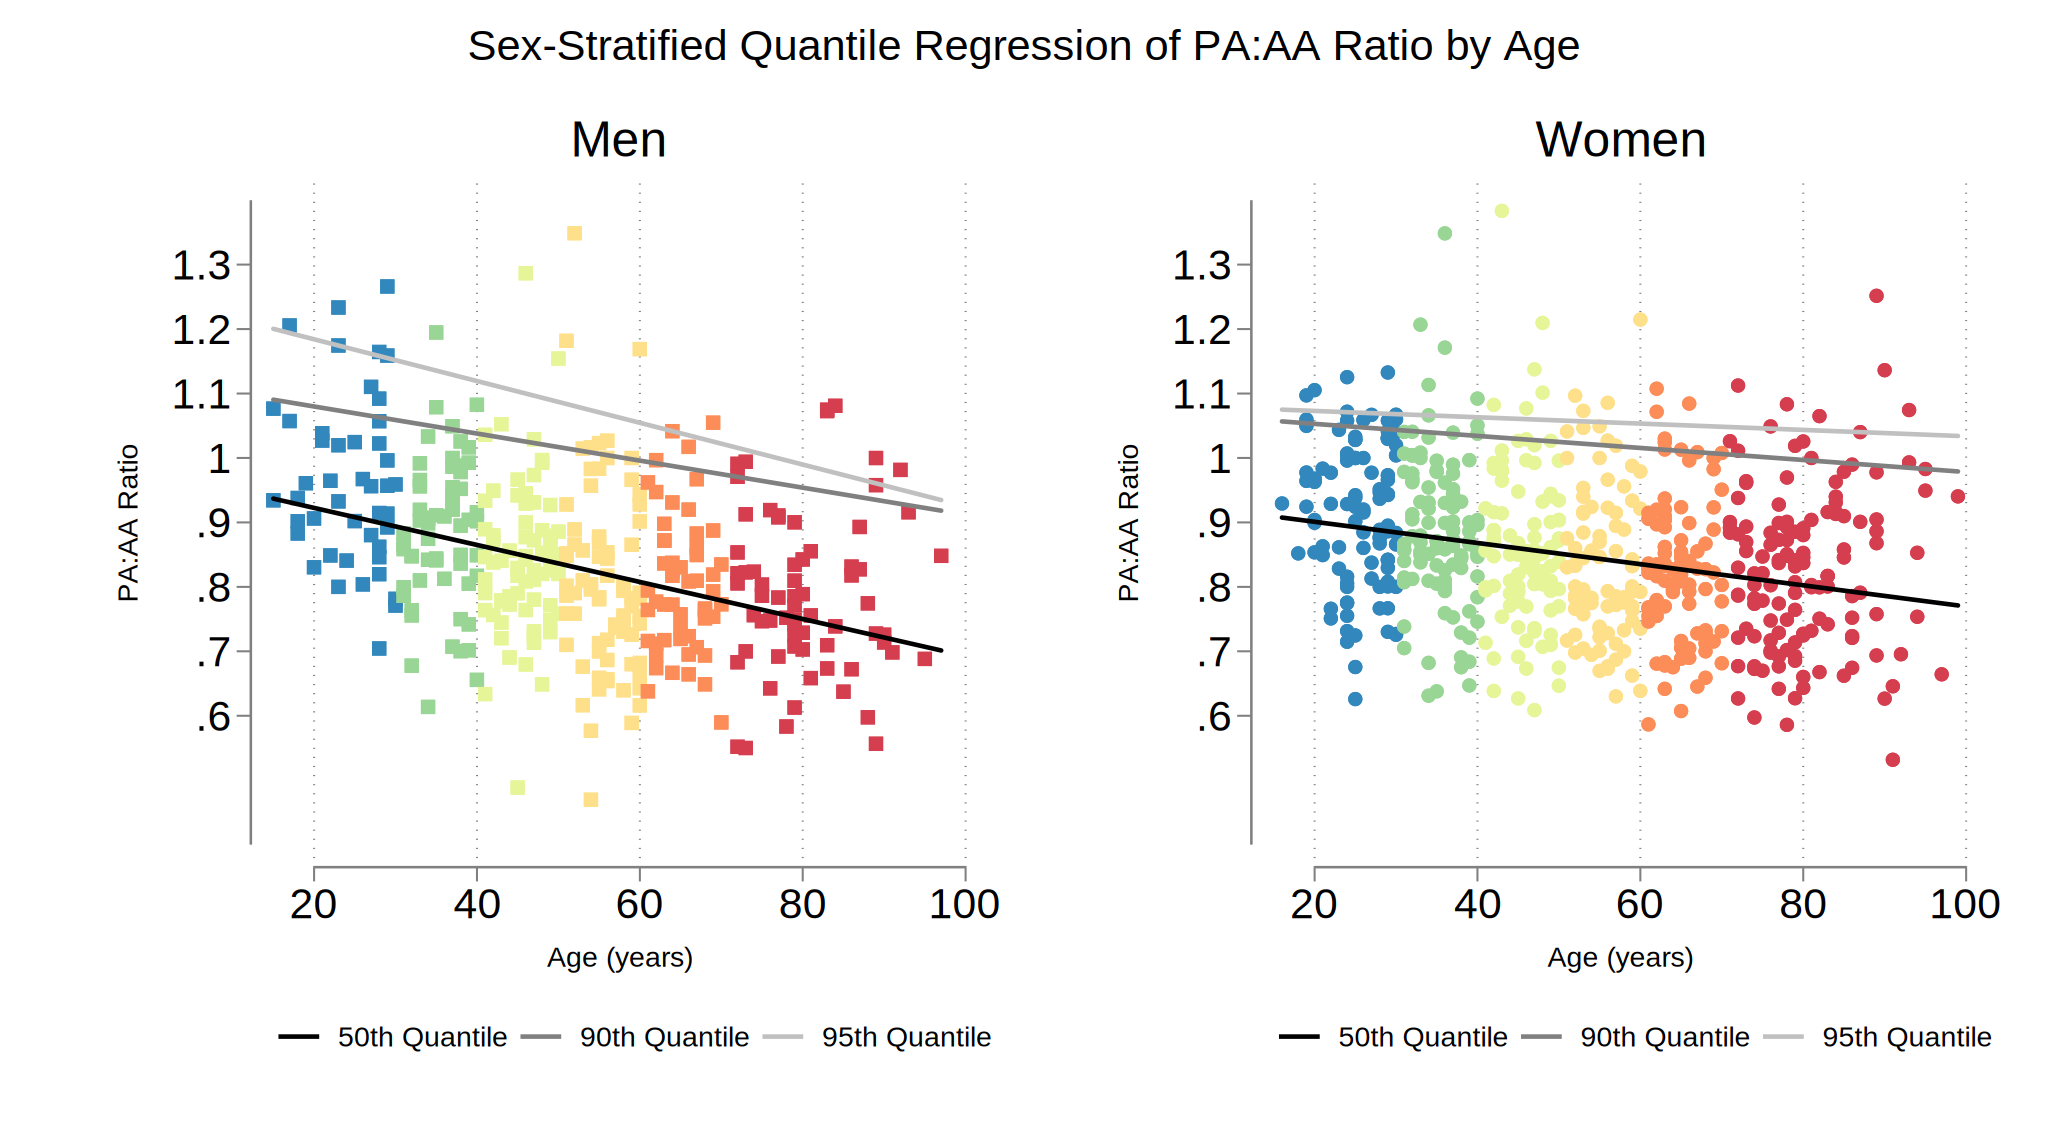

In [45]:
%%stata 

	
/* -----
Sex-Stratified Quantile Regression Scatter Plots for PA:AA Ratio
-----*/ 

/* Run Bootstrap Quantile Regressions for the Men */
bsqreg mpaaa c.age if male == 1, quantile(50) reps(500) // 50th Percentile
bsqreg mpaaa c.age if male == 1, quantile(90) reps(500) // 90th Percentile
bsqreg mpaaa c.age if male == 1, quantile(95) reps(500) // 95th Percentile

/* Extract Colors from Spectral Palette */
colorpalette Spectral, n(6) nograph  
local color6 `"`r(p1)'"' // Reverse order
local color5 `"`r(p2)'"'
local color4 `"`r(p3)'"'
local color3 `"`r(p4)'"'
local color2 `"`r(p5)'"'
local color1 `"`r(p6)'"'

/* -----
Generate Quantile Regression Predictions for Males
-----*/ 
qreg mpaaa c.age if male == 1, quantile(50) // Male
predict mpaaa_q50_male if male == 1, xb
qreg mpaaa c.age if male == 1, quantile(90) // Male
predict mpaaa_q90_male if male == 1, xb
qreg mpaaa c.age if male == 1, quantile(95) // Male
predict mpaaa_q95_male if male == 1, xb

/* -----
Male Scatter Plot
-----*/ 
twoway ///
    (scatter mpaaa age if age_decade == 0 & male == 1, mcolor("`color1'") msymbol(S)) || /// <30 years
    (scatter mpaaa age if age_decade == 1 & male == 1, mcolor("`color2'") msymbol(S)) || /// 30-40 years
    (scatter mpaaa age if age_decade == 2 & male == 1, mcolor("`color3'") msymbol(S)) || /// 40-50 years
    (scatter mpaaa age if age_decade == 3 & male == 1, mcolor("`color4'") msymbol(S)) || /// 50-60 years
    (scatter mpaaa age if age_decade == 4 & male == 1, mcolor("`color5'") msymbol(S)) || /// 60-70 years
    (scatter mpaaa age if age_decade == 5 & male == 1, mcolor("`color6'") msymbol(S)) || /// 70+ years
    (line mpaaa_q50_male age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 50th percentile line
    (line mpaaa_q90_male age, lcolor(gs8) lpattern(solid) lwidth(medthick)) || /// 90th percentile line
    (line mpaaa_q95_male age, lcolor(gs12) lpattern(solid) lwidth(medthick)), /// 95th percentile line
    ///
    legend(order(7 "50th Quantile" 8 "90th Quantile" 9 "95th Quantile") pos(6) row(1)) /// Only quantile labels in legend
    xtitle("Age (years)") ytitle("PA:AA Ratio", margin(medlarge)) ///
    title("Men") ///
    xlabel(, labsize(medlarge)) ylabel(0.6(0.1)1.3, nogrid labsize(medlarge)) /// Adjusted Y-axis range
    scheme(white_w3d) yscale(range(0.6 1.3)) ///
    saving(male_qreg_plot, replace)


/* Run Bootstrap Quantile Regressions for the Women */
bsqreg mpaaa c.age if male == 0, quantile(50) reps(500) // 50th Percentile
bsqreg mpaaa c.age if male == 0, quantile(90) reps(500) // 90th Percentile
bsqreg mpaaa c.age if male == 0, quantile(95) reps(500) // 95th Percentile

/* -----
Generate Quantile Regression Predictions for Females
-----*/ 
qreg mpaaa c.age if male == 0, quantile(50) // Female
predict mpaaa_q50_female if male == 0, xb
qreg mpaaa c.age if male == 0, quantile(90) // Female
predict mpaaa_q90_female if male == 0, xb
qreg mpaaa c.age if male == 0, quantile(95) // Female
predict mpaaa_q95_female if male == 0, xb

/* -----
Female Scatter Plot
-----*/ 
twoway ///
    (scatter mpaaa age if age_decade == 0 & male == 0, mcolor("`color1'") msymbol(O)) || /// <30 years
    (scatter mpaaa age if age_decade == 1 & male == 0, mcolor("`color2'") msymbol(O)) || /// 30-40 years
    (scatter mpaaa age if age_decade == 2 & male == 0, mcolor("`color3'") msymbol(O)) || /// 40-50 years
    (scatter mpaaa age if age_decade == 3 & male == 0, mcolor("`color4'") msymbol(O)) || /// 50-60 years
    (scatter mpaaa age if age_decade == 4 & male == 0, mcolor("`color5'") msymbol(O)) || /// 60-70 years
    (scatter mpaaa age if age_decade == 5 & male == 0, mcolor("`color6'") msymbol(O)) || /// 70+ years
    (line mpaaa_q50_female age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 50th percentile line
    (line mpaaa_q90_female age, lcolor(gs8) lpattern(solid) lwidth(medthick)) || /// 90th percentile line
    (line mpaaa_q95_female age, lcolor(gs12) lpattern(solid) lwidth(medthick)), /// 95th percentile line
    ///
    legend(order(7 "50th Quantile" 8 "90th Quantile" 9 "95th Quantile") pos(6) row(1)) /// Only quantile labels in legend
    xtitle("Age (years)") ytitle("PA:AA Ratio", margin(medlarge)) ///
    title("Women") ///
    xlabel(, labsize(medlarge)) ylabel(0.6(0.1)1.3, nogrid labsize(medlarge)) /// Adjusted Y-axis range
    scheme(white_w3d) yscale(range(0.6 1.3)) ///
    saving(female_qreg_plot, replace)

/* -----
Combine the Two Plots into a Single Figure
-----*/ 
graph combine male_qreg_plot.gph female_qreg_plot.gph, ///
    title("Sex-Stratified Quantile Regression of PA:AA Ratio by Age") ///
    ycommon xcommon ///
    iscale(*1.2) ///
    rows(1) ///
    graphregion(margin(2 2 2 2)) ///
    xsize(9) ysize(5)

overall - we can see the PA:AA is expected to get smaller with age, and that there is a less pronounced sex difference than in PA_d

### Unadjusted Survival Analysis

In [46]:
%%stata 

/* -----
PA:AA Ratio (MPAAA) Tertiles and Survival Analysis
-----*/ 

* Generate tertile cutoffs for MPAAA
xtile mpaaa_tertile = mpaaa, n(3)  // Divides into 3 equal-sized groups

* Label the tertile groups
label define mpaaa_tertile_lbl 1 "MPAAA Tertile 1" 2 "MPAAA Tertile 2" 3 "MPAAA Tertile 3"
label values mpaaa_tertile mpaaa_tertile_lbl

* Verify the tertile distribution
tab mpaaa_tertile

/* -----
Survival Analysis by MPAAA Tertile
-----*/ 

* Log-rank test for survival differences across MPAAA tertiles
sts test mpaaa_tertile, logrank 


. 
. /* -----
> PA:AA Ratio (MPAAA) Tertiles and Survival Analysis
> -----*/ 
. 
. * Generate tertile cutoffs for MPAAA
. xtile mpaaa_tertile = mpaaa, n(3)  // Divides into 3 equal-sized groups

. 
. * Label the tertile groups
. label define mpaaa_tertile_lbl 1 "MPAAA Tertile 1" 2 "MPAAA Tertile 2" 3 "MPA
> AA Tertile 3"

. label values mpaaa_tertile mpaaa_tertile_lbl

. 
. * Verify the tertile distribution
. tab mpaaa_tertile

 3 quantiles of |
          mpaaa |      Freq.     Percent        Cum.
----------------+-----------------------------------
MPAAA Tertile 1 |        330       33.33       33.33
MPAAA Tertile 2 |        330       33.33       66.67
MPAAA Tertile 3 |        330       33.33      100.00
----------------+-----------------------------------
          Total |        990      100.00

. 
. /* -----
> Survival Analysis by MPAAA Tertile
> -----*/ 
. 
. * Log-rank test for survival differences across MPAAA tertiles
. sts test mpaaa_tertile, logrank 

        Failure _d: dea

not a good mortality risk predictor at all - I suspect this confounding by age runs the other way on this one (larger PA:AA is worse, but the normal range drops with age while general mortality risk increases)


. 
. * Kaplan-Meier Survival Curve by MPAAA Tertile
. sts graph, by(mpaaa_tertile) tmax(10) ci surv ///
>  plotopts(lwidth(thick)) ///
>  risktable(0(1)10, order(1 "MPAAA Tertile 1" 2 "MPAAA Tertile 2" 3 "MPAAA Ter
> tile 3") title("Number Eligible", size(medium)) size(medsmall)) ///
>  xlabel(0(1)10, labsize(medlarge)) ///
>  ylabel(,labsize(medlarge)) ///
>  xtitle("Year of Followup", size(medlarge)) ///
>  ytitle("Survival", size(medlarge)) ///
>  legend(order(2 "MPAAA Tertile 1" 4 "MPAAA Tertile 2" 6 "MPAAA Tertile 3") po
> sition(6) ring(0) rows(1) size(medsmall)) ///
>  title("Survival by PA:AA Ratio Tertile", size(large))

        Failure _d: death==1
  Analysis time _t: _t
(note:  named style i not found in class symbol, default attributes used)

. 


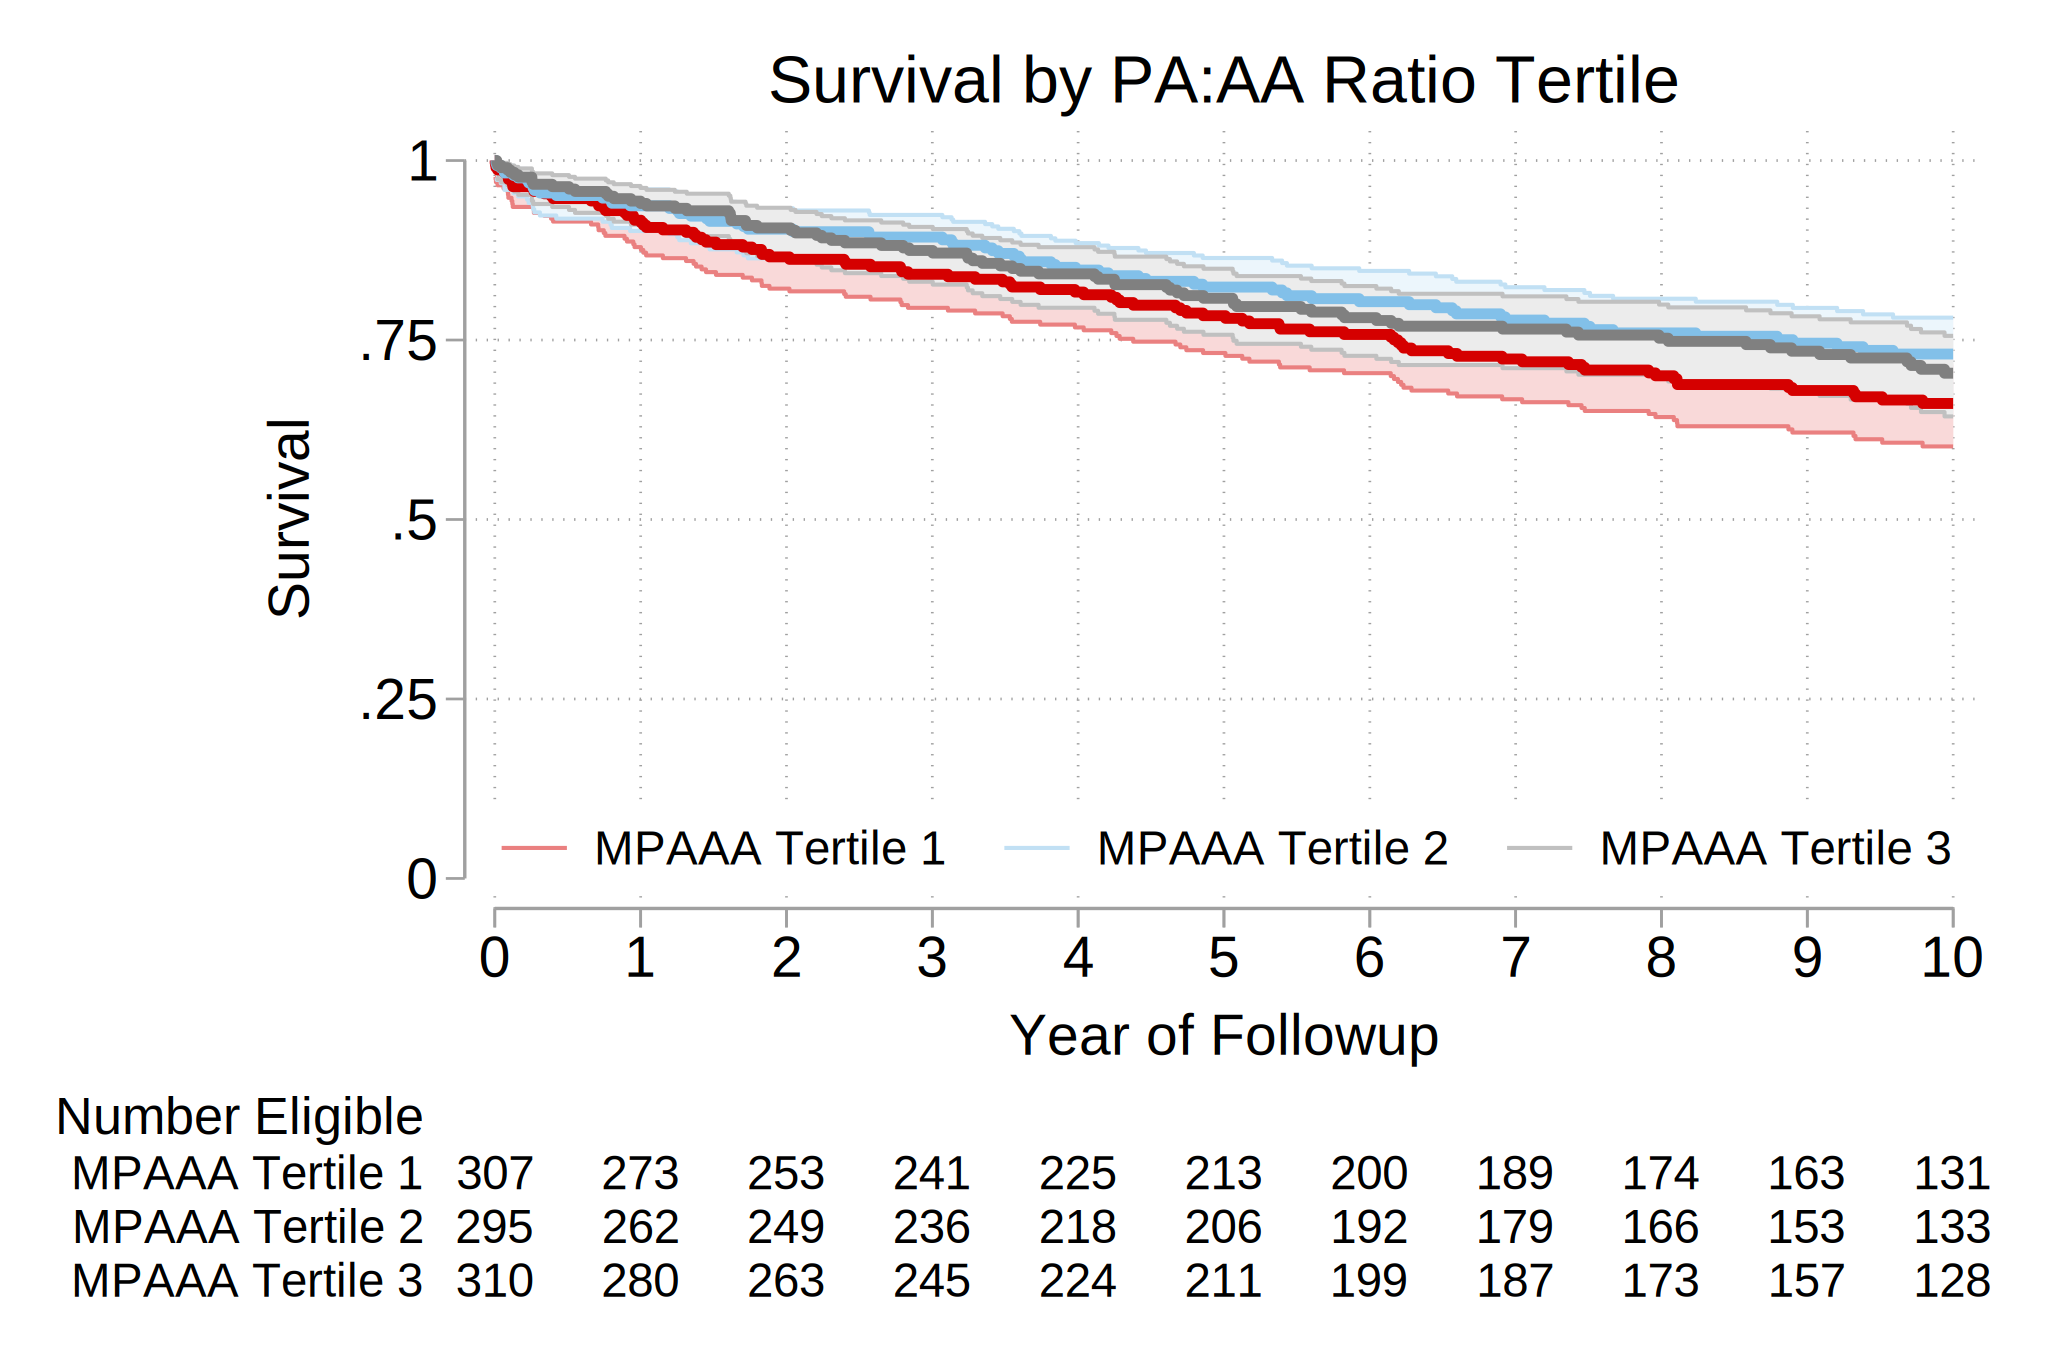

In [47]:
%%stata

* Kaplan-Meier Survival Curve by MPAAA Tertile
sts graph, by(mpaaa_tertile) tmax(10) ci surv ///
 plotopts(lwidth(thick)) ///
 risktable(0(1)10, order(1 "MPAAA Tertile 1" 2 "MPAAA Tertile 2" 3 "MPAAA Tertile 3") title("Number Eligible", size(medium)) size(medsmall)) ///
 xlabel(0(1)10, labsize(medlarge)) ///
 ylabel(,labsize(medlarge)) ///
 xtitle("Year of Followup", size(medlarge)) ///
 ytitle("Survival", size(medlarge)) ///
 legend(order(2 "MPAAA Tertile 1" 4 "MPAAA Tertile 2" 6 "MPAAA Tertile 3") position(6) ring(0) rows(1) size(medsmall)) ///
 title("Survival by PA:AA Ratio Tertile", size(large))

From the original analysis (and repeated, though not included here), the gist is: 

PA:AA falls with age because

AA increases with age faster than PA (though both increase with age)

In [48]:
%%stata

/* -----
Cox Proportional Hazards Model by MPAAA Tertile
-----*/ 
stcox i.mpaaa_tertile
estat concordance

/* -----
Brier Score for MPAAA Tertile Model
-----*/ 
stbrier i.mpaaa_tertile, bt(12.4819)


. 
. /* -----
> Cox Proportional Hazards Model by MPAAA Tertile
> -----*/ 
. stcox i.mpaaa_tertile

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood =  -1691.864
Iteration 2:  Log likelihood =  -1691.862
Refining estimates:
Iteration 0:  Log likelihood =  -1691.862

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(2)    =   3.01
Log likelihood = -1691.862                              Prob > chi2   = 0.2226

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpaaa_tert~e |
MPAAA Ter..  |   .7728009   .1173687    -1.70   0.090     .57384

In [ ]:
%%stata 

stcox i.mpaaa_tertile c.age i.male
estat concordance

/* -----
Brier Score for MPAAA Tertile Model
-----*/ 
stbrier i.mpaaa_tertile c.age i.male, bt(12.4819)


. 
. 
. stcox i.mpaaa_tertile c.age i.male

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood = -1570.7149
Iteration 2:  Log likelihood = -1569.3077
Iteration 3:  Log likelihood = -1569.3064
Refining estimates:
Iteration 0:  Log likelihood = -1569.3064

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(4)    = 248.12
Log likelihood = -1569.3064                             Prob > chi2   = 0.0000

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpaaa_tert~e |
MPAAA Ter..  |   1.199892   .1848864     1.18   0.237     .8871237    1.622932

add age and sex to the model makes it pretty good again - and highest tertile is associated with mortality once controlling for age

### Age, Sex adjusted MPA:AA

In [ ]:
%%stata 

/* -----
Define Colors for MPAAA Predicted Tertiles
-----*/ 

colorpalette Spectral, n(3) nograph  
local color3 `"`r(p1)'"'  // MPAAA Tertile 3 (High)
local color2 `"`r(p2)'"'  // MPAAA Tertile 2 (Middle)
local color1 `"`r(p3)'"'  // MPAAA Tertile 1 (Low)

/* -----
Generate Quantile Regression Predictions for Males
-----*/ 

qreg mpaaa c.age if male == 1, quantile(0.333) // Male
predict mpaaa_33_male if male == 1, xb
qreg mpaaa c.age if male == 1, quantile(0.666) // Male
predict mpaaa_66_male if male == 1, xb
qreg mpaaa c.age if male == 1, quantile(0.95) // Male
predict mpaaa_95_male if male == 1, xb

/* -----
Male Scatter Plot (Color by MPAAA Predicted Tertile)
-----*/ 
twoway ///
    (scatter mpaaa age if male == 1 & mpaaa_tertile == 1, mcolor("`color1'") msymbol(S)) || /// MPAAA Tertile 1 (Low)
    (scatter mpaaa age if male == 1 & mpaaa_tertile == 2, mcolor("`color2'") msymbol(S)) || /// MPAAA Tertile 2 (Middle)
    (scatter mpaaa age if male == 1 & mpaaa_tertile == 3, mcolor("`color3'") msymbol(S)) || /// MPAAA Tertile 3 (High)
    (line mpaaa_33_male age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 33rd percentile line
    (line mpaaa_66_male age, lcolor(gs8) lpattern(dash) lwidth(medthick)) || /// 66th percentile line
    (line mpaaa_95_male age, lcolor(gs12) lpattern(longdash) lwidth(medthick)), /// 95th percentile line
    ///
    legend(order(4 "1st-2nd Age-Sex Tertile" 5 "2nd-3rd Age-Sex Tertile" 6 "95th Age-Sex Percentile" ///
                 1 "MPAAA Tertile 1" 2 "MPAAA Tertile 2" 3 "MPAAA Tertile 3") ///
           pos(6) row(2)) ///
    xtitle("Age (years)") ytitle("PA:AA Ratio", margin(medlarge)) ///
    title("Men") ///
    xlabel(, labsize(medlarge)) ylabel(0.6(0.1)1.3, nogrid labsize(medlarge)) /// Adjusted Y-axis range
    scheme(white_w3d) yscale(range(0.6 1.3)) ///
    saving(male_qreg_plot, replace)


/* -----
Generate Quantile Regression Predictions for Females
-----*/ 

qreg mpaaa c.age if male == 0, quantile(0.333) // Female
predict mpaaa_33_female if male == 0, xb
qreg mpaaa c.age if male == 0, quantile(0.666) // Female
predict mpaaa_66_female if male == 0, xb
qreg mpaaa c.age if male == 0, quantile(0.95) // Female
predict mpaaa_95_female if male == 0, xb

/* -----
Female Scatter Plot (Color by MPAAA Predicted Tertile)
-----*/ 
twoway ///
    (scatter mpaaa age if male == 0 & mpaaa_tertile == 1, mcolor("`color1'") msymbol(O)) || /// MPAAA Tertile 1 (Low)
    (scatter mpaaa age if male == 0 & mpaaa_tertile == 2, mcolor("`color2'") msymbol(O)) || /// MPAAA Tertile 2 (Middle)
    (scatter mpaaa age if male == 0 & mpaaa_tertile == 3, mcolor("`color3'") msymbol(O)) || /// MPAAA Tertile 3 (High)
    (line mpaaa_33_female age, lcolor(black) lpattern(solid) lwidth(medthick)) || /// 33rd percentile line
    (line mpaaa_66_female age, lcolor(gs8) lpattern(dash) lwidth(medthick)) || /// 66th percentile line
    (line mpaaa_95_female age, lcolor(gs12) lpattern(longdash) lwidth(medthick)), /// 95th percentile line
    ///
    legend(order(4 "1st-2nd Age-Sex Tertile" 5 "2nd-3rd Age-Sex Tertile" 6 "95th Age-sex Quantile" ///
                 1 "MPAAA Tertile 1" 2 "MPAAA Tertile 2" 3 "MPAAA Tertile 3") ///
           pos(6) row(2)) ///
    xtitle("Age (years)") ytitle("PA:AA Ratio", margin(medlarge)) ///
    title("Women") ///
    xlabel(, labsize(medlarge)) ylabel(0.6(0.1)1.3, nogrid labsize(medlarge)) /// Adjusted Y-axis range
    scheme(white_w3d) yscale(range(0.6 1.3)) ///
    saving(female_qreg_plot, replace)


/* -----
Combine the Two Plots into a Single Figure
-----*/ 
graph combine male_qreg_plot.gph female_qreg_plot.gph, ///
    title("Sex-Stratified Quantile Regression of PA:AA Ratio by Predicted Tertile") ///
    ycommon xcommon ///
    iscale(*1.2) ///
    rows(1) ///
    graphregion(margin(2 2 2 2)) ///
    xsize(9) ysize(5)

In [52]:
%%stata 


* Run Quantile Regression Separately for Males
qreg mpaaa c.age if male == 1, quantile(0.333)
predict mpaaa_q33_male if male == 1, xb

qreg mpaaa c.age if male == 1, quantile(0.666)
predict mpaaa_q66_male if male == 1, xb

* Run Quantile Regression Separately for Females
qreg mpaaa c.age if male == 0, quantile(0.333)
predict mpaaa_q33_female if male == 0, xb

qreg mpaaa c.age if male == 0, quantile(0.666)
predict mpaaa_q66_female if male == 0, xb

/* -----
Step 2: Categorize Individuals Into Predicted Tertiles for MPAAA
-----*/

* Create an empty variable for tertile classification
gen mpaaa_pred_tertile = .

* Assign individuals into tertiles based on their predicted quantile cutoffs
replace mpaaa_pred_tertile = 1 if male == 1 & mpaaa < mpaaa_q33_male
replace mpaaa_pred_tertile = 2 if male == 1 & mpaaa >= mpaaa_q33_male & mpaaa < mpaaa_q66_male
replace mpaaa_pred_tertile = 3 if male == 1 & mpaaa >= mpaaa_q66_male

replace mpaaa_pred_tertile = 1 if male == 0 & mpaaa < mpaaa_q33_female
replace mpaaa_pred_tertile = 2 if male == 0 & mpaaa >= mpaaa_q33_female & mpaaa < mpaaa_q66_female
replace mpaaa_pred_tertile = 3 if male == 0 & mpaaa >= mpaaa_q66_female

/* -----
Step 3: Label the Categories for MPAAA Predicted Tertiles
-----*/

label define mpaaa_pred_tertile_lbl 1 "PA:AA Pred Tertile 1" 2 "PA:AA Pred Tertile 2" 3 "PA:AA Pred Tertile 3"
label values mpaaa_pred_tertile mpaaa_pred_tertile_lbl

* Verify the tertile distribution
tab mpaaa_pred_tertile mpaaa_tertile

	


. 
. 
. * Run Quantile Regression Separately for Males
. qreg mpaaa c.age if male == 1, quantile(0.333)

Iteration 1:  WLS sum of weighted deviations =  17.631278

Iteration 1:  Sum of abs. weighted deviations =  17.821262
Iteration 2:  Sum of abs. weighted deviations =  16.957048
Iteration 3:  Sum of abs. weighted deviations =    15.8715
Iteration 4:  Sum of abs. weighted deviations =  15.867128

.333 Quantile regression                            Number of obs =        370
  Raw sum of deviations 17.43487 (about .77903683)
  Min sum of deviations 15.86713                    Pseudo R2     =     0.0899

------------------------------------------------------------------------------
       mpaaa | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
         age |  -.0027043   .0003659    -7.39   0.000    -.0034239   -.0019847
       _cons |   .9340505    .020431    45.72   0.000     .8938743    .9

In [53]:
%%stata 

kappaetc mpaaa_pred_tertile mpaaa_tertile


. 
. kappaetc mpaaa_pred_tertile mpaaa_tertile

Interrater agreement                             Number of subjects =     990
                                                Ratings per subject =       2
                                        Number of rating categories =       3
------------------------------------------------------------------------------
                     |   Coef.  Std. Err.    t    P>|t|   [95% Conf. Interval]
---------------------+--------------------------------------------------------
   Percent Agreement |  0.7818    0.0131  59.53   0.000     0.7560     0.8076
Brennan and Prediger |  0.6727    0.0197  34.15   0.000     0.6341     0.7114
Cohen/Conger's Kappa |  0.6727    0.0197  34.16   0.000     0.6341     0.7114
    Scott/Fleiss' Pi |  0.6727    0.0197  34.16   0.000     0.6341     0.7114
           Gwet's AC |  0.6727    0.0197  34.15   0.000     0.6341     0.7114
Krippendorff's Alpha |  0.6729    0.0197  34.16   0.000     0.6342     0.7115
------------

interestingly, even lower agreement (= more reclassification) than in the MPA diameter case

In [54]:
%%stata 

tab3way mpaaa_pred_tertile mpaaa_tertile age_decade


. 
. tab3way mpaaa_pred_tertile mpaaa_tertile age_decade


Table entries are cell frequencies
Missing categories ignored

------------------------------------------------------------------------
                     |     Age (by decade) and 3 quantiles of mpaaa     
                     | ------------------- <30 years -------------------
  mpaaa_pred_tertile | MPAAA Tertile 1  MPAAA Tertile 2  MPAAA Tertile 3
---------------------+--------------------------------------------------
PA:AA Pred Tertile 1 |              18               25                 
PA:AA Pred Tertile 2 |                               15               24
PA:AA Pred Tertile 3 |                                                65
------------------------------------------------------------------------

------------------------------------------------------------------------
                     |     Age (by decade) and 3 quantiles of mpaaa     
                     | ------------------ 30-40 years ------------------


In [55]:
%%stata 

/* -----
Log-Rank Test for Survival Differences Across PA:AA Predicted Tertiles
-----*/ 
sts test mpaaa_pred_tertile, logrank 



. 
. /* -----
> Log-Rank Test for Survival Differences Across PA:AA Predicted Tertiles
> -----*/ 
. sts test mpaaa_pred_tertile, logrank 

        Failure _d: death==1
  Analysis time _t: _t

Equality of survivor functions
Log-rank test

                     |  Observed       Expected
mpaaa_pred~e         |    events         events
---------------------+-------------------------
PA:AA Pred Tertile 1 |        74          92.17
PA:AA Pred Tertile 2 |        79          86.99
PA:AA Pred Tertile 3 |       110          83.84
---------------------+-------------------------
               Total |       263         263.00

                               chi2(2) =  12.49
                               Pr>chi2 = 0.0019

. 



. 
. /* -----
> Kaplan-Meier Survival Curve by PA:AA Predicted Tertile
> -----*/ 
. sts graph, by(mpaaa_pred_tertile) tmax(10) ci surv ///
>  plotopts(lwidth(thick)) ///
>  risktable(0(1)10, order(1 "Age-Sex PA:AA Tertile 1" 2 "Age-Sex PA:AA Tertile
>  2" 3 "Age-Sex PA:AA Tertile 3") title("Number Eligible", size(medium)) size(
> medsmall)) ///
>  xlabel(0(1)10, labsize(medlarge)) ///
>  ylabel(,labsize(medlarge)) ///
>  xtitle("Year of Followup", size(medlarge)) ///
>  ytitle("Survival", size(medlarge)) ///
>  legend(order(2 "Age-Sex PA:AA Tertile 1" 4 "Age-Sex PA:AA Tertile 2" 6 "Age-
> Sex PA:AA Tertile 3") position(6) ring(0) rows(3) size(medsmall)) ///
>  title("Survival by Age-Sex PA:AA Tertile", size(large))

        Failure _d: death==1
  Analysis time _t: _t

. 


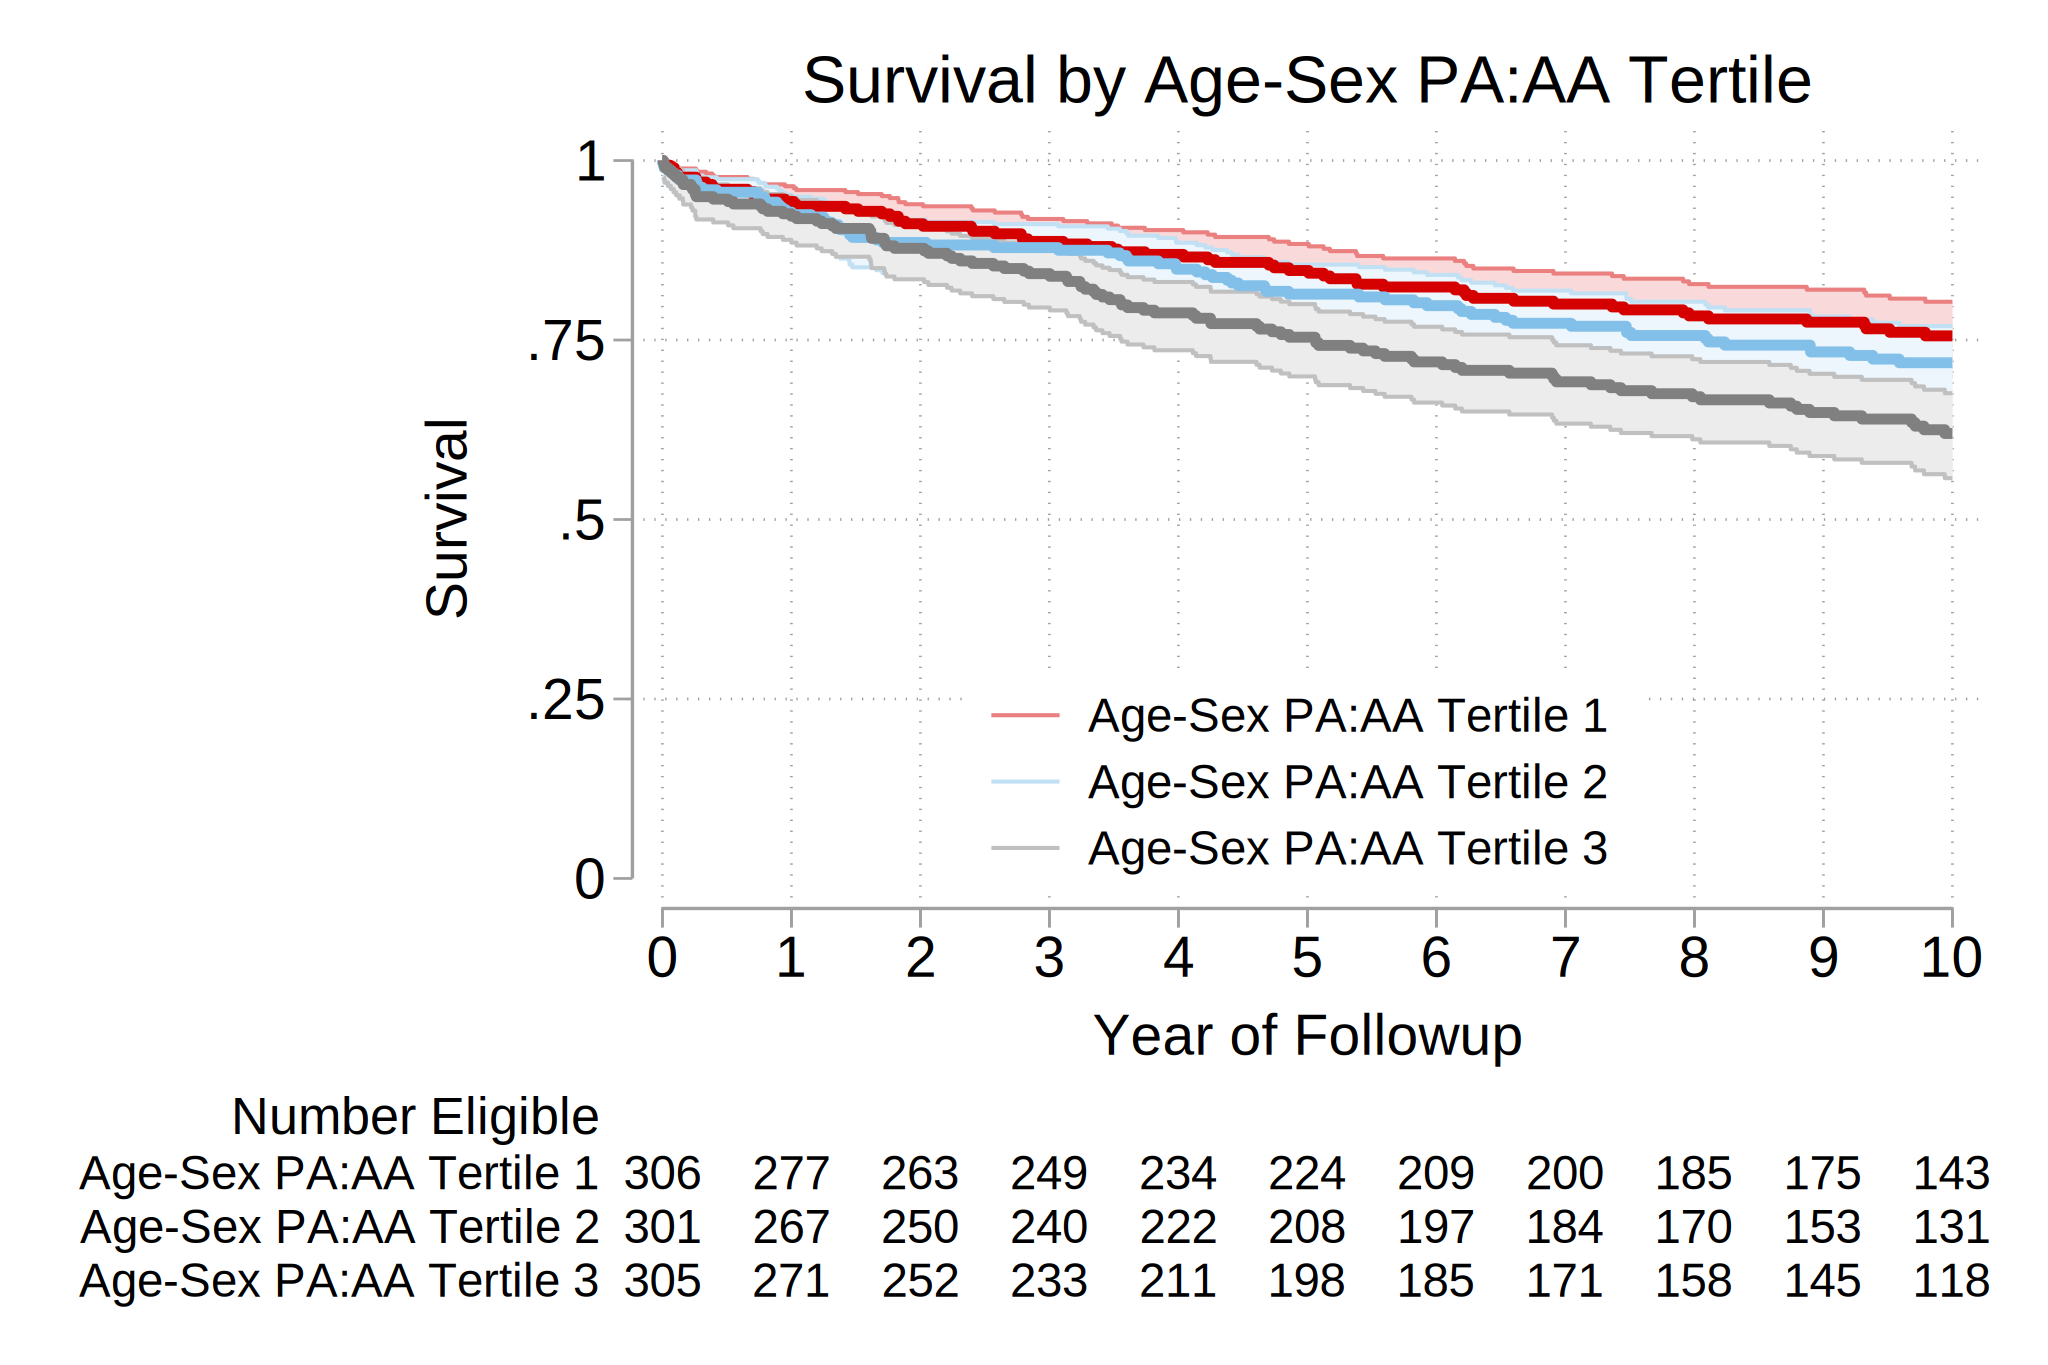

In [56]:
%%stata 

/* -----
Kaplan-Meier Survival Curve by PA:AA Predicted Tertile
-----*/ 
sts graph, by(mpaaa_pred_tertile) tmax(10) ci surv ///
 plotopts(lwidth(thick)) ///
 risktable(0(1)10, order(1 "Age-Sex PA:AA Tertile 1" 2 "Age-Sex PA:AA Tertile 2" 3 "Age-Sex PA:AA Tertile 3") title("Number Eligible", size(medium)) size(medsmall)) ///
 xlabel(0(1)10, labsize(medlarge)) ///
 ylabel(,labsize(medlarge)) ///
 xtitle("Year of Followup", size(medlarge)) ///
 ytitle("Survival", size(medlarge)) ///
 legend(order(2 "Age-Sex PA:AA Tertile 1" 4 "Age-Sex PA:AA Tertile 2" 6 "Age-Sex PA:AA Tertile 3") position(6) ring(0) rows(3) size(medsmall)) ///
 title("Survival by Age-Sex PA:AA Tertile", size(large))

definitely a better predictor than the unadjusted version - though not amazingly so

In [57]:
%%stata
	
/* -----
Cox Proportional Hazards Model by PA:AA Predicted Tertile
-----*/ 
	stcox i.mpaaa_pred_tertile
	estat concordance

/* -----
Brier Score for PA:AA Tertile Model
-----*/ 
stbrier i.mpaaa_tertile, bt(12.4819)



.         
. /* -----
> Cox Proportional Hazards Model by PA:AA Predicted Tertile
> -----*/ 
.         stcox i.mpaaa_pred_tertile

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood = -1687.3764
Iteration 2:  Log likelihood = -1687.3465
Iteration 3:  Log likelihood = -1687.3465
Refining estimates:
Iteration 0:  Log likelihood = -1687.3465

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(2)    =  12.04
Log likelihood = -1687.3465                             Prob > chi2   = 0.0024

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
mpaaa_

In [58]:
%%stata

/* -----
Cox Proportional Hazards Model by PA:AA Predicted Tertile with Age and Sex Adjustment
-----*/ 
stcox i.mpaaa_pred_tertile c.age i.male
estat concordance

/* -----
Brier Score for PA:AA Tertile Model
-----*/ 
stbrier i.mpaaa_tertile, bt(12.4819)
	


. 
. /* -----
> Cox Proportional Hazards Model by PA:AA Predicted Tertile with Age and Sex Ad
> justment
> -----*/ 
. stcox i.mpaaa_pred_tertile c.age i.male

        Failure _d: death==1
  Analysis time _t: _t

Iteration 0:  Log likelihood = -1693.3646
Iteration 1:  Log likelihood = -1570.1557
Iteration 2:  Log likelihood = -1569.1491
Iteration 3:  Log likelihood = -1569.1491
Refining estimates:
Iteration 0:  Log likelihood = -1569.1491

Cox regression with Breslow method for ties

No. of subjects =        912                            Number of obs =    912
No. of failures =        263
Time at risk    = 6,981.3588
                                                        LR chi2(4)    = 248.43
Log likelihood = -1569.1491                             Prob > chi2   = 0.0000

------------------------------------------------------------------------------
          _t | Haz. ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------+-------------------------------------------

overall - not super accurate as a predictor

## Summary and Next steps

- In comparison to the chest paper, we have a much broader spectrum of patients - with both pulmonary vascular diasease and not
- like the TTE CTPA paper, we find that PA size increases with age by quantile regression (and other methods)
- however, AA also increases with age even faster, so expected MPA:AA drops with age. - not reported in TTE paper or evaluated in Chest PH Paper

Re-creating the analysis as they did doesn't work as well because the tertile's blend together a lot of the exposure risk - especially in our group where moderate enlargement isn't as important as extreme enlargmenent. 

Thus, appraoches could be: 

- we could ask them to do MPA:AA - is it more predictive?
- we could ask them about the age confounding issue that we see in the more general population (e.g. is increased mortality risk because MPA enlarges as you get older? seems like probably not, since no univariate association in their paper) 
- we could ask if they think age-correcting would be additionally predictive in their cohort or not? 
- we could cook up more models and see if there is a difference in predictiveness (we can't do Reveal, but could adjust for comorbidities, etc. )


My TODO: 

- play around with using pulm artery size and aorta, independently, as predictors - (this may be better)
- construct a variety of models with all the covariates we used in the original manuscript and see if additional info more predictive or not.